> In statistics, **multicollinearity** (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. In this situation the coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data. Multicollinearity does not reduce the predictive power or reliability of the model as a whole, at least within the sample data set; it only affects calculations regarding individual predictors. That is, a multivariate regression model with collinear predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others. - From <a href="https://en.wikipedia.org/wiki/Multicollinearity" target="_blank">Wikipedia</a>

Data scientists love linear regression due to its high model interpretability. Unlike other complex machine learning models (ex: K-nearest neighbor, random forest, or neural net), the interpretation of model parameters is straightforward. Assume a linear regression model defined by  <span style="font-size: 90% !important">$y = 110 x_1 + 50 x_2$</span>. Then, increasing <span style="font-size: 90% !important">$x_1$</span> by 2 will increase <span style="font-size: 90% !important">$y$</span> by 220, and increasing <span style="font-size: 90% !important">$x_2$</span> by 3 will increase y by 150, controlling the other variable constant. However, it turns out that you can't really <i>"control"</i> the other variable under multicollinearity.

Sometimes the values or signs (+/-) of linear regression coefficients have special meanings. This is the case when a linear regression model is based on a physics model. For illustration, I show <a href="#eq-1">eq (1)</a>, the material balance equation (MBE) used in petroleum engineering to calculate the amount of oil and gas trapped in a geologic hydrocarbon reservoir (source: Eq 14. from this <a href="https://petrowiki.org/Material_balance_in_oil_reservoirs" target="_blank">petrowiki page</a>). 

<div id="eq-1" style="font-size: 1rem;">
$$ F = G_{fgi}x_{1} + N_{foi}x_{2} + W_e \tag{1}$$
</div>

<div class="eq-terms">
    <div class="row eq-terms-where">where</div>
    <div class="row">
        <div class="col-3">$F$</div>
        <div class="col-9">: <i>"Dependent Variable"</i> total net fluid withdrawal or production</div>
    </div>
    <div class="row">
        <div class="col-3">$x_{1}$</div>
        <div class="col-9">: <i>"Independent Variable"</i> composite gas expansivity</div>
    </div>
    <div class="row">
        <div class="col-3">$x_{2}$</div>
        <div class="col-9">: <i>"Independent Variable"</i> composite oil expansivity</div>
    </div>  
    <div class="row">
        <div class="col-3">$G_{fgi}$</div>
        <div class="col-9">: <i>"Regression Coefficient"</i> initial free gas</div>
    </div>
    <div class="row">
        <div class="col-3">$N_{foi}$</div>
        <div class="col-9">: <i>"Regression Coefficient"</i> initial free oil</div>
    </div>
    <div class="row">
        <div class="col-3">$W_{e}$</div>
        <div class="col-9">: <i>"Intercept"</i> cumulative water influx</div>
    </div>
</div>

The individual value of the regression coefficients in <a href="#eq-1">eq (1)</a> is important, because oil <span style="font-size: 90% !important">$N_{foi}$</span> is more expensive than gas <span style="font-size: 90% !important">$G_{fgi}$</span> in the market. Oil & gas companies make decisions about where to drill the next well based on economic projections made from the values of <span style="font-size: 90% !important">$N_{foi}$</span> and <span style="font-size: 90% !important">$G_{fgi}$</span>. However, sometimes the values of <span style="font-size: 90% !important">$N_{foi}$</span> and <span style="font-size: 90% !important">$G_{fgi}$</span> solved with a multiple linear regression model are unreliable due to multicollinearity. I numerically demonstrate this effect in <i>Section 3.1: Model instability with sampling</i> <a href="#Model instability with sampling">below</a>.

This post attempts to help your understanding of multicollinearity and introduce solutions in Python. All sections come with Python code snippets. 

<div id="toc_container">
    <p class="toc_title">Contents</p>
    <ul class="toc_list">
        <li><a href="#Sample data description"><span class="toc_label">0</span>Sample data description</a></li>
        <li><a href="#Key takeaways"><span class="toc_label">1</span>Key takeaways</a></li>
        <li><a href="#Concept"><span class="toc_label">2</span>Concept</a></li>
        <li><a href="#Effects"><span class="toc_label">3</span>Effects</a></li>
        <ul>
            <li><a href="#Model instability with sampling"><span class="toc_label">3.1</span>Model instability with sampling</a></li>
            <li><a href="#Overestimated standard errors"><span class="toc_label">3.2</span>Overestimated standard errors</a></li>
            <li><a href="#Structural multicollinearity with interaction terms"><span class="toc_label">3.3</span>Structural multicollinearity with interaction terms</a></li>
        </ul>
        <li><a href="#Detection"><span class="toc_label">4</span>Detection</a></li>
        <ul>
            <li><a href="#VIF"><span class="toc_label">4.1</span>VIF</a></li>
            <ul>
                <li><a href="#Calculation of VIF assumes a certain structure of a model"><span class="toc_label">Notes:</span>Calculation of VIF assumes a certain structure of a model</a></li>
                <li><a href="#Three ways to compute VIF in Python"><span class="toc_label">Pythonic Tip:</span>Three ways to compute VIF in Python</a></li>
            </ul>
            <li><a href="#Correlation matrix"><span class="toc_label">4.2</span>Correlation matrix</a></li>
            <ul>
                <li><a href="#Partial correlation matrix"><span class="toc_label">Notes:</span>Partial correlation matrix</a></li>
            </ul>
        </ul>
        <li><a href="#Remedies"><span class="toc_label">5</span>Remedies</a></li>
        <ul>
            <li><a href="#Increase sample size"><span class="toc_label">5.1</span>Increase sample size</a></li>
            <ul>
                <li><a href="#Sample size and width of confidence interval"><span class="toc_label">Notes:</span>Sample size and width of confidence interval</a></li>
            </ul>
            <li><a href="#Mean centering"><span class="toc_label">5.2</span>Mean centering</a></li>
            <ul>
                <li><a href="#Statistical significance in linear regression analysis"><span class="toc_label">Notes:</span>Statistical significance in linear regression analysis</a></li>
            </ul>
            <li><a href="#Removal"><span class="toc_label">5.3</span>Elimination</a></li>
            <li><a href="#Principle component regression"><span class="toc_label">5.4</span>Principle component regression</a></li>
        </ul>
        <li><a href="#Excuses for ignoring multicollinearity"><span class="toc_label">6</span>Pitfalls</a></li>
    </ul>
</div>

Statistical significance in linear regression analysis

Notes: Sample size and width of confidence interval

Partial correlation matrix

Width of confidence interval and sample size

Warning! Be careful not to eliminate features just based on VIF score. Use feature ranking knowledge

Notes: Variations of correlation matrix.

Wrong data encoding - dummy variable
            <li><a href="#Calculation of VIF assumes a certain structure of a model."><span class="toc_label">Notes:</span>Calculation of VIF assumes a certain structure of a model.</a></li>

Calculation of VIF assumes a certain structure of a model.

<div id="Sample data description"></div>

## 0. Sample data description

We will generate synthetic linear data sets throughout this post. Note that I chose not to use real-life data, because it is difficult to demonstrate the instability of regression coefficients under multicollinearity; we do not know the <i>true</i> values of regression coefficients. With synthetic data, however, we can control the true values of regression coefficients and the degree of collinearity with <a href="#algorithm-1">Algorithm 1</a>. 

Assume that we want to generate collinear data with three features described by the linear model:  <span style="font-size: 90% !important">$y = 2 x_1 + 4 x_2 + 10 x_3 + 2$</span>. We can set the true values of regression coefficients with <code>true_coefs</code> and <code>true_intercept</code>:

In [1]:
true_coefs = [2, 4, 10]               # true values of the regression coefficients
true_intercept = 2                    # true vale of the intercept

<div style="margin-top: -20px"></div>

We can also control the degree of collinearity. If we want high collinearity, fill the diagonal elemens with <code>1</code>, and fill the non-diagonal elements of the positive semi-definite covariance matrix <code>cov</code> with values close to <code>1</code>:

In [23]:
correlation = 0.95                    # HIGH COLLINEARITY
cov = np.full((len(true_coefs), len(true_coefs)), correlation)
np.fill_diagonal(cov, 1)

In [24]:
cov

array([[1.  , 0.95, 0.95],
       [0.95, 1.  , 0.95],
       [0.95, 0.95, 1.  ]])

<div style="margin-top: -20px"></div>

If low collinearity is desired, fill the non-diagonal elements of <code>cov</code> with values close to 0:

In [25]:
correlation = 0.01                    # LOW COLLINEARITY
cov = np.full((len(true_coefs), len(true_coefs)), correlation)
np.fill_diagonal(cov, 1)

In [26]:
cov

array([[1.  , 0.01, 0.01],
       [0.01, 1.  , 0.01],
       [0.01, 0.01, 1.  ]])

<div style="margin-top: -20px"></div>

We generate collinear independent variables (features) with <a href="https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html" target="_blank">np.random.multivariate_normal</a>. The function takes <code>cov</code> as one of the argument, which makes it easy to generate collinear features. The below code snippet simulates <code>n = 100</code> observations of highly collinear data points, sampled from the population described by the linear model <span style="font-size: 90% !important">$y = 2 x_1 + 4 x_2 + 10 x_3 + 2$</span> with Gaussian noise.

<p id="algorithm-1"><u>Algorithm 1: Random generation of highly collinear data</u></p>

In [2]:
import numpy as np

# settings 
n = 100                               # sample size
true_coefs = [2, 4, 10]               # linear regression coefficients, 3 features
true_intercept = 2                    # y-intercept
feature_means = [5, 1, 12]            # means of gaussian features. This is not important
correlation = 0.01                    # degree of collinearity (LOW)

# positive semi-definite covariance matrix. 
cov = np.full((len(true_coefs), len(true_coefs)), correlation)
np.fill_diagonal(cov, 1)

# random generation of 3D gaussian collinear features. 100 x 3 numpy array
X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

# generate gaussian white noise. mean = 0, standard deviation = 2. 100 x 1 numpy array
gaussian_noise = np.random.normal(loc=0, scale=2, size=n)

# make the outcome. 100 x 1 numpy array
y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + true_coefs[2] * X[:, 2] + gaussian_noise

<div id="Key takeaways"></div>

## 1. Key takeaways

<div class="highlights" id="key1">
    <div class="highlights-title">1. Confidence interval quantifies uncertainty of statistical estimation</div>
    <div class="highlights-content">Confidence interval qunatifies the uncertainty related to a statistical estimation to mitigate the issue of <a href="#population_vs_samples">Population vs. Samples</a>. It is always expressed in a range like — $\text{C.I.}: \quad \bar{x} \pm 3.43$ or $-51.4 < \bar{x} < -43.2$</div>
</div>

<div class="highlights" id="key2">
    <div class="highlights-title">2. Confidence interval is the basis of parametric hypothesis tests</div>
    <div class="highlights-content">Confidence interval is the basis of parametric hypothesis tests. For example, <a href="https://www.investopedia.com/terms/t/t-test.asp" target="_blank">t-test</a> computes its p-value using the <a href="#conf_int_of_diff_in_mean">confidence interval of difference in mean</a>. When samples follow a normal distribution, and therefore their centeral tendency can be described by their means, t-test can be used to conclude if two distributions are significantly different from each other. 
    </div>
</div>

However, the model fit statistics, such as adjusted R-squared and RMSE are not affected by multicollinearity.

It’s entirely possible that the variable with the the insignificant p-value should actually be significant. A classic hallmark of multicollinearity is that it makes variables appear to be insignificant even when they’re not

The goal of remedial procedures are to increase precision. 

<div id="Concept"></div>

## 2. Concept

<a href="https://en.wikipedia.org/wiki/Multicollinearity" target="_blank">Wikipedia</a> has a good & concise definition of collinearity and multicollinearity. 

**Collinearity** is a linear association between two explanatory variables. Two variables are perfectly collinear if there is an exact linear relationship between them. For example, <span style="font-size: 90% !important">$X_1$</span> and <span style="font-size: 90% !important">$X_2$</span> are perfectly collinear if there exist parameters <span style="font-size: 90% !important">$\lambda_0$</span> and <span style="font-size: 90% !important">$\lambda_1$</span> such that, for all observations <span style="font-size: 90% !important">$i$</span>, we have:

<div id="eq-2" style="font-size: 1rem;">
$$ X_{2i} = \lambda_0 + \lambda_1 X_{1i} \tag{2}$$
</div>

**Multicollinearity** refers to a situation in which two or more explanatory variables in a multiple regression model are linearly related. A feature does not have to be directly linearly related to a response variable, if it affects an another feature that is linearly related to the response variable. For example in <a href="#fig-1">figure (1-C)</a>, we see that although <span style="font-size: 90% !important">$X_2$</span> is not related to <span style="font-size: 90% !important">$Y$</span>, <span style="font-size: 90% !important">$X_2$</span> is related to <span style="font-size: 90% !important">$X_1$</span>, which in turn affects <span style="font-size: 90% !important">$Y$</span>.

<a href="eq-2">Eq (2)</a> shows the case of perfect collinearity, in which the correlation between <span style="font-size: 90% !important">$X_1$</span> and <span style="font-size: 90% !important">$X_2$</span> is equal to 1 or -1. In practice, we rarely face perfect multicollinearity in a data set. More commonly, the issue of multicollinearity arises when there is an approximate linear relationship among two or more independent variables. For example in <a href="#fig-1">figure (1-B)</a>, we see that most of the variability of the Venn diagram can be explained by just <span style="font-size: 90% !important">$X_1$</span> and <span style="font-size: 90% !important">$Y$</span>, and that we don't really need <span style="font-size: 90% !important">$X_2$</span>, due to the high degree of multicollinearity between <span style="font-size: 90% !important">$X_1$</span> and <span style="font-size: 90% !important">$X_2$</span>, represented by the area of overlap (yellow color).

<div id="fig-1" class="row give-margin-inline-big-plot mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_venn_diagram.png"></div>
    <div class="col-12"><p class="image-description">Figure 1: Multicollinearity Venn diagram. Yellow regions represent the degree of multicollinearity between the independent variables <span style="font-size: 90% !important">$X_1$</span> and <span style="font-size: 90% !important">$X_2$</span></p></div>
</div>

<div><hr></div>

Let's try to understand multicollinearity in greater detail with thought experiments. Consider the following two scenarios.

**Scenario 1**

As a microbiologist, you want to fix the number of bacteria A growing in a petri dish to be <span style="font-size: 90% !important">$Y = 10,000$</span>. The number of bacteria A is a function of temperature and the amount of toxic chemical, described by the following linear model:

<div id="eq-3" style="font-size: 1rem;">
$$ Y = \beta_1 \cdot \text{temperature} - \beta_2 \cdot \text{toxic chemical} + \beta_0 \tag{3}$$
</div>

Based on this linear model, you can make an informed decision about how to manipulate the features (temperature and the amount of toxic chemicals) to control the number of bacteria in the petri dish. 

With <a href="eq-3">eq (3)</a>, you have full control of the number of bacteria, because the impact of each features is understood by their respective regression coefficients (<span style="font-size: 90% !important">$\beta_1$</span> for temperature, and <span style="font-size: 90% !important">$\beta_2$</span> for toxic chemicals), and the features are independent (no multicollinearity). In the other words, temperature does not affect the amount of toxic chemicals, and vice versa.

**Scenario 2**

Now, let’s assume a scenario in which the features are not independent from each other. You are growing bacteria A and bacteria B together in the same petri dish, and want to fix the number of bacteria A to be <span style="font-size: 90% !important">$Y = 10,000$</span>. The following information is known:

<ol class="rounded-list" style="margin-bottom: 40px !important; margin-top: 40px! important;">
    <li><p>Bacteria B preys on bacteria A.</p></li>
    <li><p>Temperature increases the number of the both bacteria groups.</p></li>
    <li><p>Each bacteria group emits different amount of methane. Methane traps heat, and increases temperature.</p></li>
    <li><p>Toxic chemical negatively affects bacteria A. The impact of the toxic chemical on bacteria B is unknown.</p></li>
</ol>

The number of bacteria A is a function of temperature, the amount of toxic chemical, and the number of bacteria B, described by the following linear model:

<div id="eq-4" style="font-size: 1rem;">
$$ Y = \beta_1 \cdot \text{temperature} - \beta_2 \cdot \text{toxic chemical} -\beta_3 \cdot \text{bacteria B} + \beta_0 \tag{4}$$
</div>

It is difficult to make an informed decision about how to manipulate the features to get the target number <span style="font-size: 90% !important">$Y = 10,000$</span>, because the features are correlated with one another. For example, increased temperature results in increased number of bacteria A, but it also results in increased number of bacteria B which in turn decreases the number of bacteria A. On the other hand, increasing the number of bacteria B decreases the number of bacteria A, but it affects the total amount of methane emitted, which in turn affects temperature. 

Furthermore, we do not understand the net impact of the toxic chemical, since its relationship with the number of bacteria B is unknown. This blackbox relationship among features is quite common in real-life applications, which makes it difficult to understand the impact of individual regression coefficients on the response variable.

<div><hr></div>

The situation in which features are correlated with one another is called multicollinearity. Under multicollinearity, the impact of individual regression coefficients on a response variable is obfuscated, and the values of the individual regression coefficiens are unreliable. I demonstrate the effects of multicollinearity in Python in <i>Section 4: Effects</i> <a href="#">below</a>.

<div class="highlights red-theme" id="prediction-power-warning">
    <div class="highlights-title red-theme">WARNING!</div>
    <div class="highlights-content red-theme"><b>Multicollinearity does not reduce the predictive power or reliability of the model as a whole.</b> That is, a multiple regression model with collinear features can indicate how well the <i>"entire bundle"</i> of features predicts the response variable, but it may not give valid results for individual features in which the features are somewhat redundant with each other. Multicollinearity is an issue only for problems in which the values of the individual regression coefficients has special meanings. If predicting the response varialbe is your only interest, you can safely ignore multicollinearity. I discuss more situations in which you can ignore multicollinearity <a href="#">below</a>.
    </div>
</div>

<div id="Effects"></div>

## 3. Effects

This section discusses & demonstrates the effects of multicollinearity in Python.

<ol class="rounded-list" style="margin-top: 20px! important;">
    <li><p><a href="#Model instability with sampling">Model instability with sampling</a></p></li>
    <li><p><a href="#Overestimated standard errors">Overestimated standard errors</a></p></li>
    <li><p><a href="#Structural multicollinearity with interaction terms">Structural multicollinearity with interaction terms</a></p></li>
</ol>

<div id="Model instability with sampling"></div>

### 3.1. Model instability with sampling

Under multicollinearity, the regression coefficients of features change erratically in response to small changes in the sample data. Assume that you trained the following linear regression model with your current data set:
    
<div id="eq-5" style="font-size: 1rem;">
$$ y = 11.7 x_1 - 0.47 x_2 + 540 \tag{5}$$
</div>

You obtain a few additional samples and re-train your regression model. This time, you observe drastic change in the values of the individual regression coefficient:

<div id="eq-6" style="font-size: 1rem;">
$$ y = 14.1 x_1 + 0.74 x_2 + 231 \tag{6}$$
</div>

The change was so drastic that the sign of the coefficient for <span style="font-size: 90% !important">$x_2$</span> changed from negative (-) to positive (+). This is unacceptable if you wish to know whether a particular feature negatively or positively affects a response variable by the sign of its coefficient. I show how multicollinearity causes such instability in regression coefficients with sampling through a Python simulation. 

For the simulation, we fit many multiple linear regression models with 2 features and an intercept. We generate synthetic data set with the procedures described in <i>Section 0. Sample data description</i> <a href="#Sample data description">above</a>, for both low and high multicollinearity populations. We set <code>true_coefs = [13, 0.5]</code> and <code>true_intercept = 2</code>, and add Gaussian noise to the model. For each model, we use <code>n = 100</code> data points to fit coefficients and an intercept. We fit <code>m = 2000</code> different models. This essentially mimicks drawing samples from a population described by the true model   <span style="font-size: 90% !important">$y = 13 x_1 + 0.5 x_2 + 2$</span> with Gaussian noise. This is a type of <a href="https://aegis4048.github.io/comprehensive_confidence_intervals_for_python_developers#monte-carlo" target="_blank">Monte-Carlo method</a>, in which the simulation relies on repeated generation of random numbers to investigate some characteristic of a statistic which is hard to derive analytically.

The result is shown in <a href="#fig-2">figure (2)</a>. Note that the population with low multicollinearity forms a tight circular cluster of regression coefficiens around the true coefficient values <code>true_coefs = [13, 0.5]</code>, whereas the population with high multicollinearity shows greater variance, represented by its wider elliptical cluster. You can see that the values of coefficient for <span style="font-size: 90% !important">$x_2$</span> ranges between -1.5 to 2. This explains the sign change of the regression coefficient for <span style="font-size: 90% !important">$x_2$</span> between <a href="#eq-5">eq (5)</a> and <a href="#eq-6">eq (6)</a>.

<div id="fig-2" class="row give-margin-inline-big-plot mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_sampling_instability.png"></div>
    <div class="col-12"><p class="image-description">Figure 2: Model instability due to multicollinearity</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (2)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import numpy as np
                from sklearn import linear_model
                import matplotlib.pyplot as plt

                def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

                    # random generation of 3D gaussian collinear features.
                    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                    # generate gaussian white noise.
                    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                    # make the outcome.
                    y = true_intercept + gaussian_noise
                    for i in range(len(true_coefs)):
                        y += true_coefs[i] * X[:, i]

                    return X, y

                # settings
                m = 2000                                 # number of simulations
                correlation_lo = 0.01                    # degree of collinearity (LOW)
                correlation_hi = 0.98                    # degree of collinearity (HIGH)

                kwargs = {
                    'n': 100,                            # sample size
                    'true_coefs': [13, 0.5],             # linear regression coefficients, 2 features
                    'true_intercept': 2,                 # y-intercept
                    'feature_means': [0, 0],             # means multivariate normal distribution. This is not important
                    'loc': 0,                            # mean of gaussian noise
                    'scale': 1                           # standard deviation of gaussian noise
                }

                # high collinearity covariance matrix
                cov_hi = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation_hi)
                np.fill_diagonal(cov_hi, 1)

                # low collinearity covariance matrix
                cov_lo = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation_lo)
                np.fill_diagonal(cov_lo, 1)

                # simulation
                model_hi_col_coefs = []
                model_lo_col_coefs = []
                for i in range(m):

                    X_hi, y_hi = generate_collinear_data(cov_hi, **kwargs)
                    ols_hi = linear_model.LinearRegression()
                    model_hi = ols_hi.fit(X_hi, y_hi)
                    model_hi_col_coefs.append(model_hi.coef_)

                    X_lo, y_lo = generate_collinear_data(cov_lo, **kwargs)
                    ols_lo = linear_model.LinearRegression()
                    model_lo = ols_lo.fit(X_lo, y_lo)
                    model_lo_col_coefs.append(model_lo.coef_)

                # list to numpy array conversion
                model_hi_col_coefs = np.array(model_hi_col_coefs)
                model_lo_col_coefs = np.array(model_lo_col_coefs)

                # plotting
                plt.style.use('default')
                plt.style.use('ggplot')

                fig, ax = plt.subplots(figsize=(8, 4.5))

                ax.scatter(model_hi_col_coefs[:, 0], model_hi_col_coefs[:, 1], s=10, label='High multicollinearity',
                           edgecolor='red', facecolor='firebrick', alpha=0.7)
                ax.scatter(model_lo_col_coefs[:, 0], model_lo_col_coefs[:, 1], s=10, label='Low multicollinearity',
                           edgecolor='dimgrey', facecolor='k', alpha=0.7)

                ax.set_xlim(10.5, 15.5)
                ax.set_ylim(-2, 3)
                ax.set_xlabel('$x_1$ coefficient values', fontsize=16)
                ax.set_ylabel('$x_2$ coefficient values', fontsize=16)
                ax.set_title('Model instability due to multicollinearity', fontsize=20)
                ax.legend(facecolor='white', fontsize=11)
                ax.text(0.2, 0.1, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
                         transform=ax.transAxes, color='grey', alpha=0.5)

                fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

The above scatter plot shows the effect of multicollinearity for linear models with two features. How does multicollinearity affect regression coefficients when there are more than two features? In <a href="fig-3">figure (3)</a>, I simulated 10,000 linear models with five features and an intercept: <code>'true_coefs': [13, 0.5, 5, -1, -24]</code>, and <code>'true_intercept': 2</code>. Similar to <a href="fig-2">figure (2)</a>, linear models trained from low multicollinearity population showed narrower range of coefficients than those of high multicollinearity population. Note that multicollinearity does not affect the range of intercepts.

<div id="fig-3" class="row" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_range_of_coefficients_low_vs_high.png"></div>
    <div class="col-12"><p class="image-description">Figure 3: Model instability due to multicollinearity, 5 features.</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (3)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import numpy as np
                import statsmodels.api as sm
                import matplotlib.pyplot as plt

                def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

                    # random generation of 3D gaussian collinear features.
                    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                    # generate gaussian white noise.
                    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                    # make the outcome.
                    y = true_intercept + gaussian_noise
                    for i in range(len(true_coefs)):
                        y += true_coefs[i] * X[:, i]

                    return X, y

                # settings
                m = 10000                                   # number of simulations
                correlation_lo = 0.01                       # degree of collinearity (LOW)
                correlation_hi = 0.98                       # degree of collinearity (HIGH)

                kwargs = {
                    'n': 100,                               # sample size
                    'true_coefs': [13, 0.5, 5, -1, -24],    # linear regression coefficients, 2 features
                    'true_intercept': 2,                    # y-intercept
                    'feature_means': [0, 0, 0, 0, 0],       # means multivariate normal distribution. This is not important
                    'loc': 0,                               # mean of gaussian noise
                    'scale': 1                              # standard deviation of gaussian noise
                }

                # high collinearity covariance matrix
                cov_hi = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation_hi)
                np.fill_diagonal(cov_hi, 1)

                # low collinearity covariance matrix
                cov_lo = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation_lo)
                np.fill_diagonal(cov_lo, 1)

                # simulation
                hi_col_params = []
                lo_col_params = []
                for i in range(m):

                    # high collinearity data
                    X_hi, y_hi = generate_collinear_data(cov_hi, **kwargs)
                    X_st_hi = sm.add_constant(X_hi)
                    model_hi = sm.OLS(y_hi, X_st_hi).fit()
                    hi_col_params.append(model_hi.params)                       

                    # low collinearity data
                    X_lo, y_lo = generate_collinear_data(cov_lo, **kwargs)
                    X_st_lo = sm.add_constant(X_lo)
                    model_lo = sm.OLS(y_lo, X_st_lo).fit()
                    lo_col_params.append(model_lo.params)                               

                # list to numpy conversion
                hi_col_params = np.asarray(hi_col_params)
                lo_col_params = np.asarray(lo_col_params)

                # plotting
                def styling(ax):
                    ax.set_facecolor('#eeeeee')
                    ax.grid(True, linestyle='--', color='#acacac')
                    ax.tick_params(color='grey')
                    _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]
                    ax.text(0.5, 0.1, 'aegis4048.github.io', fontsize=12, ha='center', va='center',
                            transform=ax.transAxes, color='grey', alpha=0.5)
                    ax.set_xticklabels(['High', 'Low'], fontsize=15)

                boxplot_styling = {
                    'sym': '',
                    'whis': [2.5, 97.5],
                    'showfliers': False,
                    'boxprops': dict(linewidth=2.0, color='#4e98c3'),
                    'whiskerprops': dict(linewidth=2.0, color='#4e98c3', linestyle='--'), 
                    'vert': True,
                    'capprops': dict(linewidth=2.0, color='k'),
                    'medianprops': dict(linewidth=2.0, color='#ad203e'),
                    'widths': (0.4, 0.4)
                }

                labels = ['Intercept', '$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_5$']

                fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

                for i, (ax, label) in enumerate(zip(axes, labels)):
                    ax.boxplot([list(hi_col_params[:, i]), list(lo_col_params[:, i])], **boxplot_styling)
                    styling(ax)
                    ax.set_title(label, fontsize=20, y=-0.2)

                fig.tight_layout(rect=[0, 0.05, 1, 0.91])
                fig.suptitle('Range of coefficients with low & high multicollinearity - 10,000 simulations', fontsize=25);
            </code>
        </pre>
    </div>
</div>

<div id="Overestimated standard errors"></div>

### 3.2. Overestimated standard errors

(Notes: There is a version conflict between Scipy and Statsmodel. You need Scipy version 1.2 or below or 1.4 or above to use Statsmodel. In my virtual environment, I have <code>statsmodels==0.10.2</code> and <code>scipy==1.4.1</code>)

In this section, I demonstrate the the unreliability of linear regression analysis report due to multicollinearity by comparing the analytical solutions of the report, and the actual parameter values obtained with numerical simulations.

Throughout your study of multiple linear regression, you have probably encountered the linear regression analysis report that looks like <a href="#fig-4">figure (4)</a>, which is generated with <a href="https://www.statsmodels.org/stable/regression.html" target="_blank">statsmodels</a> Python library (the figure is generated with the same simulation settings of <a href="#fig-3">figure (3)</a>'s high multicollinearity data). The problem is that multicollinearity makes this report unreliable, especially with the standard errors of the individual regression coefficients. Note that this is not the problem of statsmodels library, but the inherent statistical problem caused by multicollinearity. Problems with standard errors sequentially cause problems with the t-statistic <code>t</code>, p-value <code>P>|t|</code>, and 95% confidence interval <code>[0.025   0.975]</code> of the regression coefficients. This is because standard error is used to compute a confidence interval, and confidence interval is closely related to hypothesis testing, which involves t-statistic and p-value (if you are curious about the relationship between confidence interval and hypothesis testing, check <i>Section 4.2: Confidence interval of difference in mean</i> of my <a href="https://aegis4048.github.io/comprehensive_confidence_intervals_for_python_developers#4.2.-Confidence-interval-of-difference-in-mean" target="_blank">previous post</a>). Overestimated standard errors sometimes result in failure to reject the null hypothesis on coefficient significance, when it shouldn't be rejected.

Note that the overestimated standard errors affect the significance test and confidence intervals of coefficients, but do not affect the coefficients themselves. However, recall that the coefficients are already unstable due to multicollinearity, as explained in <i>Section 3.1: Model instability with sampling</i> <a href="#Model instability with sampling">above</a>. So now you have two sources of pain; not only you can't trust the values of the coefficient themselves, but also their significance test results and confidence intervals. Check <i>Section 4.1: VIF</i> <a href="#VIF">below</a> to understand mathematical relationship between multicollinearity and standard errors.

<div id="fig-4" class="row give-margin-inline-big-plot mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_statsmodel_report_unreliable.png"></div>
    <div class="col-12"><p class="image-description">Figure 4: Linear regression analysis becomes unreliable with multicollinearity.</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (4)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import numpy as np
                import statsmodels.api as sm
                import matplotlib.pyplot as plt

                def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

                    # random generation of 3D gaussian collinear features.
                    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                    # generate gaussian white noise.
                    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                    # make the outcome.
                    y = true_intercept + gaussian_noise
                    for i in range(len(true_coefs)):
                        y += true_coefs[i] * X[:, i]

                    return X, y

                # settings
                m = 10000                                   # number of simulations
                correlation_hi = 0.98                       # degree of collinearity (HIGH)

                kwargs = {
                    'n': 100,                               # sample size
                    'true_coefs': [13, 0.5, 5, -1, -24],    # linear regression coefficients, 2 features
                    'true_intercept': 2,                    # y-intercept
                    'feature_means': [0, 0, 0, 0, 0],       # means multivariate normal distribution. This is not important
                    'loc': 0,                               # mean of gaussian noise
                    'scale': 1                              # standard deviation of gaussian noise
                }

                # high collinearity covariance matrix
                cov_hi = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation_hi)
                np.fill_diagonal(cov_hi, 1)

                X, y = generate_collinear_data(cov_hi, **kwargs)
                X_st = sm.add_constant(X)
                model = sm.OLS(y, X_st).fit()                     

                print(model.summary())
            </code>
        </pre>
    </div>
</div>

Let's try to understand this with numerical simulations. The idea of using numerical simulations is based on the Law of Large Numbers (LLM): the result of performing the same experiment a large number of times will converge to a single value. That is, we should be able to obtain the true confidence interval of the linear regression coefficients for high multicollinearity data. Recall that this is impossible with analytical solutions reported by linear regression analysis result shown in <a href="#fig-4">figure (4)</a> due to multicollinearity. 

I generated 100,000 high multicollinearity data sets with the procedures described in <i>Section 0. Sample data description</i> <a href="#Sample data description">above</a>, with five features and an intercept: <code>'true_coefs': [13, 0.5, 5, -1, -24]</code>, and <code>'true_intercept': 2</code>. Then, I trained 100,000 different linear models. In <a href="#fig-5">figure (5)</a>, we observe that the 50th percentiles of the analytical C.I. are always off from the true value, where as those of the numerical C.I. correctly guess the true value. These offsets are consistent with the effects of multicollinearity I discussed in <i>Section 3.1: Model instability with sampling</i> <a href="#Model instability with sampling">above</a>.

According to LLM, we know that the C.I. of numerical solution must be true, and that anything not consistent with the numerical C.I. is wrong. In <a href="#fig-6">figure (6)</a>, we observe that the widths of the analytical C.I. are wider than those of the numerical C.I. This is because multicollinearity increases the analytically computed standard errors, which in turn increases the widths of the C.I. But to be fair, the issues with the overestimated standard error is not that big of a deal; it only adds a small problem, on the top of the big problem, which is the actual offset of the coefficients. Furthermore, sometimes the analytical C.I. of high multicollinearity data is narrower than its true confidence interval, which is the case for the feature $X_1$. While it is <i>generally</i> the case that multicollinearity widens the confidence interval, its not always the case.

<div id="fig-5" class="row" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_std_err_errorbar.png"></div>
    <div class="col-12"><p class="image-description">Figure 5: Unstable model parameters due to high multicollinearity</p></div>
</div>

<div id="fig-6" class="row" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_std_err_barchart.png"></div>
    <div class="col-12"><p class="image-description">Figure 6: Overestimated confidence intervals due to high multicollinearity</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (5) and (6)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import numpy as np
                import statsmodels.api as sm
                import matplotlib.pyplot as plt

                def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

                    # random generation of 3D gaussian collinear features.
                    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                    # generate gaussian white noise.
                    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                    # make the outcome.
                    y = true_intercept + gaussian_noise
                    for i in range(len(true_coefs)):
                        y += true_coefs[i] * X[:, i]

                    return X, y

                # simulation settings
                m = 100000                                 # number of simulations. WARNING!!! Large m makes execution time very long
                correlation = 0.98                          # degree of collinearity (HIGH)
                kwargs = {
                    'n': 50,                                # sample size
                    'true_coefs': [13, 0.5, 5, -1, -24],    # linear regression coefficients, 2 features
                    'true_intercept': 2,                    # y-intercept
                    'feature_means': [0, 0, 0, 0, 0],       # means multivariate normal distribution. This is not important
                    'loc': 0,                               # mean of gaussian noise
                    'scale': 1                              # standard deviation of gaussian noise
                }

                # high collinearity covariance matrix
                cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
                np.fill_diagonal(cov, 1)

                ######################################### numerical solution ################################################

                params = []
                for i in range(m):
                    X, y = generate_collinear_data(cov, **kwargs)         # generate high collinearity data
                    X_st = sm.add_constant(X)
                    model = sm.OLS(y, X_st).fit()
                    params.append(model.params)

                params = np.asarray(params)                               # list to numpy conversion

                numerical_means = np.mean(params, axis=0)                 # solution
                numerical_lo = np.percentile(params, 2.5, axis=0)         # lower bound of 95% confidence interval
                numerical_hi = np.percentile(params, 97.5, axis=0)        # upper bound of 95% confidence interval
                numerical_width = abs(numerical_hi - numerical_lo)        # width of confidence interval

                ######################################### analytical solution ###############################################

                X, y = generate_collinear_data(cov, **kwargs)   # generate high collinearity data
                X_st = sm.add_constant(X)
                model = sm.OLS(y, X_st).fit()

                analytical_means = model.params                           # solution
                analytical_lo = model.conf_int(alpha=0.05)[:, 0]          # lower bound of 95% confidence interval
                analytical_hi = model.conf_int(alpha=0.05)[:, 1]          # upper bound of 95% confidence interval
                analytical_width = abs(analytical_hi - analytical_lo)     # width of confidence interval

                ######################################### Plotting:  Error bars ##############################################

                def styling(ax, label):
                    ax.set_xlabel(label, fontsize=25)
                    ax.set_facecolor('#eeeeee')
                    ax.grid(True, linestyle='--', color='#acacac', axis='y')
                    ax.tick_params(color='grey')
                    ax.set_xticklabels([])
                    ax.set_xlim(0, 2)
                    _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]
                    ax.text(0.5, 0.1, 'aegis4048.github.io', fontsize=12, ha='center', va='center',
                            transform=ax.transAxes, color='grey', alpha=0.5)

                labels = ['Intercept', '$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_5$']
                true_params = [kwargs['true_intercept']] + kwargs['true_coefs']
                x = np.array([1, 2])

                fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

                for i, (ax, label, true_param) in enumerate(zip(axes, labels, true_params)):
                    yerr_numerical = [[abs(numerical_lo[i] - numerical_means[i])], [abs(numerical_hi[i] - numerical_means[i])]]
                    yerr_analytical = [[abs(analytical_lo[i] - analytical_means[i])], [abs(analytical_hi[i] - analytical_means[i])]]

                    ax.errorbar(1 - 0.25, numerical_means[i], yerr=yerr_numerical,
                               fmt='o', label='95% numerical C.I.', color='k', markersize=8, capsize=8, elinewidth=2.5, markeredgewidth=2.5)
                    ax.errorbar(1 + 0.25, analytical_means[i], yerr=yerr_analytical,
                               fmt='o', label='95% analytical C.I.', color='grey', markersize=8, capsize=8, elinewidth=2.5, markeredgewidth=2.5)
                    ax.axhline(true_param, linestyle='-.', color='#ad203e', label='True value')
                    styling(ax, label)

                axes[0].set_ylabel('Range of 95% C.I.', fontsize=30)

                fig.legend(*ax.get_legend_handles_labels(), loc='lower center', ncol=3, borderaxespad=0.7, fontsize=17)

                fig.suptitle('Effect of overestimated standard errors - %.f simulations' % m, fontsize=25);
                fig.tight_layout(rect=[0, 0.10, 1, 0.9])
                
                ######################################### Plotting:  Bar chart ###############################################

                x = np.array([i for i in range(len(analytical_width))])

                fig, ax = plt.subplots(figsize=(16, 6))

                ax.bar(x - 0.15, numerical_width, align='center', alpha=0.75, width=0.28, color='k', label='Numerical Sol.')
                ax.bar(x + 0.15, analytical_width, align='center', width=0.28, color='grey', label='Analytical Sol.')

                ax.text(0.1, 0.65, 'aegis4048.github.io', fontsize=17, ha='center', va='center', 
                        transform=ax.transAxes, color='grey', alpha=0.5)
                ax.set_ylabel('Width of 95% C.I.', fontsize=30)
                ax.legend(fontsize=17, loc='upper left')
                ax.set_xticks(x)
                ax.set_xticklabels([str(label) for label in labels], fontsize=25)
                ax.set_facecolor('#eeeeee')
                ax.grid(True, linestyle='--', color='#acacac', axis='y')
                ax.tick_params(color='grey')
                _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]

                fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

<div class="highlights red-theme" id="numerical-simulations-warning">
    <div class="highlights-title red-theme">WARNING!</div>
    <div class="highlights-content red-theme">When training real-life models, you don't have an access to the numerical solutions as in <a href="#fig-5">figure (5)</a> and <a href="#fig-6">figure (6)</a>, because you only have one sample. This means that you have to rely on linear regression analysis report like <a href="#fig-5">figure (4)</a>, which is unreliable under multicollinearity. This is why you need remedial procedures, which I discuss in <i>Section 5: Remedies</i> <a href="#Remedies">below</a>.
    </div>
</div>

<div id="Structural multicollinearity with interaction terms"></div>

### 3.3. Structural multicollinearity with interaction terms

*<u>Structural multicollinearity</u>* occurs when you create synthetic features from the original features. It is a byproduct of the model we specify rather than being present in the data itself. For example, imagine a population modeled by  <span style="font-size: 90% !important">$y = \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_0$</span> with gaussian noise. Let's say that you (a data scientist) don't like the model, and want to add an *<u>interaction term</u>* to increase statistical power of the model. Your new model becomes <span style="font-size: 90% !important">$y = \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_1^2 + \beta_5 (x_2 x_3) + \beta_0$</span>. But there's an obvious problem here. If you add the square of <span style="font-size: 90% !important">$x_1$</span> to the model, naturally there is a high correlation between <span style="font-size: 90% !important">$x_1$</span> and <span style="font-size: 90% !important">$x_1^2$</span>. The same idea goes between <span style="font-size: 90% !important">$x_2$</span> and <span style="font-size: 90% !important">$x_2x_3$</span>.

For demonstraction, I use real-life data: rock properties and natural gas production. Please refer to <i>Section 0: Sample data description</i> of my <a href="https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python#0.-Sample-data-description" target="_blank">previous post</a> for more information of this dataset. I also use VIF to quantify the degree of multicollinearity (refer to <i>Section 4.1: VIF</i> <a href="#VIF">below</a> if you are not familiar with VIF). I added interaction terms for features <code>Por</code>, <code>Perm</code>, and <code>AI</code>. In <a href="#fig-7">figure (7)</a>, we observe massive increase in VIF for features with their interaction term counterparts. Considering VIF bigger than 10 is considered very severe multicollinearity, this is unacceptable. While mean centering, which I discuss in <i>Section 5.2: Mean centering</i> <a href="#centering_2">below</a>, has an effect of reducing high VIF due to interaction terms, it turns out to be useless for real-life applications.

<div id="fig-7" class="row full_screen_margin_70 mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_interaction.png"></div>
    <div class="col-12"><p class="image-description">Figure 7: Effect of interaction terms on VIF</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (7)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import pandas as pd
                import numpy as np
                from sklearn.preprocessing import StandardScaler

                ############################################# import data #############################################

                # data source: https://github.com/GeostatsGuy/GeoDataSets/blob/master/unconv_MV_v5.csv
                file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
                features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
                df = pd.read_csv(file)
                df = df[features]

                ####################################### VIFs with original data #######################################

                vifs_orig = np.linalg.inv(df.corr().values).diagonal()

                df_vif_orig = pd.DataFrame()
                df_vif_orig['Features'] = df.columns
                df_vif_orig['VIF'] = vifs_orig

                ##################################### VIFs with interaction terms #####################################

                df['Perm $\cdot$ AI'] = df['Perm'].values * df['AI'].values
                df['Por$^2$'] = df['Por'].values ** 2

                vifs_inter = np.linalg.inv(df.corr().values).diagonal()

                df_vif_inter = pd.DataFrame()
                df_vif_inter['Features'] = df.columns
                df_vif_inter['VIF'] = vifs_inter

                print(df_vif_orig)
                print()
                print(df_vif_inter)
            </code>
        </pre>
    </div>
</div>

<div id="Sample data description"></div>

## 4. Detection

This section discusses two ways to detect multicollinearity with a dataset. You can assess one-to-one relationships of features with correlation matrix. You can assess one-to-many relationships of features with VIF score. 

<ol class="rounded-list" style="margin-top: 20px! important;">
    <li><p><a href="#VIF">VIF</a></p></li>
    <li><p><a href="#Correlation matrix">Correlation matrix</a></p></li>
</ol>

For demonstration, I use real-life data: rock properties and natural gas production. Please refer to <i>Section 0: Sample data description</i> of my <a href="https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python#0.-Sample-data-description" target="_blank">previous post</a> for more information of this dataset. 

<div id="VIF"></div>

### 4.1. VIF

Variance inflation factor (VIF) represents how much the standard error (SE) of an estimated regression coefficient is increased due to multicollinearity. High value of VIF is undesirable, because it is interpreted as high instability of the value of the regression coefficient. In <a href="#fig-2">figure (2)</a>, high SE coefficients are shown as red dots, and the low SE coefficients are shown as black dots. <a href="#eq-7">Eq (7)</a> shows the mathematical components that contribute to the instability (SE) of regression coefficients (source: <a href="https://en.wikipedia.org/wiki/Variance_inflation_factor" target="_blank">Wikipedia</a>). Note that the symbol $\widehat{ }$ means "estimated value". 

<div id="eq-7" style="font-size: 1rem;">
$$ \widehat{SE}^2 (\hat{\beta_j}) = \widehat{var} (\hat{\beta_j}) = \frac{s^2}{(n-1)\widehat{var}(X_j)} \cdot VIF (\hat{\beta_j}) \tag{7}$$
</div>

<div class="eq-terms">
    <div class="row eq-terms-where">where</div>
    <div class="row">
        <div class="col-3">$\widehat{SE}$</div>
        <div class="col-9">: Estimated standard error</div>
    </div>
    <div class="row">
        <div class="col-3">$\widehat{var}$</div>
        <div class="col-9">: Estimated variance</div>
    </div>
    <div class="row">
        <div class="col-3">$\hat{\beta_j}$</div>
        <div class="col-9">: Estimated regression coefficient of the $j$-th independent variable</div>
    </div>
    <div class="row">
        <div class="col-3">$s^2$</div>
        <div class="col-9">: Mean squared error. Represents the scatter of data</div>
    </div>  
    <div class="row">
        <div class="col-3">$n$</div>
        <div class="col-9">: Sample size</div>
    </div>
    <div class="row">
        <div class="col-3">$X_j$</div>
        <div class="col-9">: $j$-th independent variable</div>
    </div>
    <div class="row">
        <div class="col-3">$VIF$</div>
        <div class="col-9">: Variance inflation factor</div>
    </div>
</div>

The interpretation of <a href="#eq-7">eq (7)</a> is actually very straightforward. Big scatter of data <span style="font-size: 90% !important">$s^2$</span> increases SE. On the other hand, obtaining more number of samples <span style="font-size: 90% !important">$n$</span> or increasing <span style="font-size: 90% !important">$\widehat{var} (\hat{X_j})$</span> reduces SE. This intuitively makes sense because the power of statistical estimation increases with greater sample size and variability of samples — your model can be trained for more possible number of scenarios. As a result, you are more confident with the values of your regression coefficients, reducing SE.

The remaining source that contributes to the instability of coefficients in <a href="#eq-7">eq (7)</a> is the degree of multicollinearity, represented as <span style="font-size: 90% !important">$VIF (\hat{\beta_j})$</span>. It is computed with the following equation:

<div id="eq-8" style="font-size: 1rem;">
$$ VIF (\hat{\beta_j}) = \frac{1}{1 - R^2_j} \tag{8}$$
</div>

<span style="font-size: 90% !important">$R^2_j$</span> is calculated by taking a j-th feature, and regressing it against every other features in the model. This is very similar to the traditional <code>R-squared</code> that most people are familiar with; high <code>R-squared</code> means that a response variable can be well-predicted from its features. In terms of multicollinearity, high <span style="font-size: 90% !important">$R^2_j$</span> $\longleftrightarrow$ high VIF is undesirable, as it means that a feature can be linearly predicted from the other features.

**Rules of thumb for VIF**

- <p style="margin-top: 5px !important"><span style="font-size: 90% !important">$VIF (\hat{\beta_j}) = 1$</span> : A feature <span style="font-size: 90% !important">$X_j$</span> is orthogonal to all other features. It exibits no sign of multicollinearity.</p>
- <p style="margin-top: 5px !important"><span style="font-size: 90% !important">$1 < VIF (\hat{\beta_j}) < 5$</span> : There is some degree of multicollinearity, but it is not significantly high.</p>
- <p style="margin-top: 5px !important"><span style="font-size: 90% !important">$5 < VIF (\hat{\beta_j}) < 10$</span> : The degee of multicollinearity is high enough to cause troubles.</p>
- <p style="margin-top: 5px !important"><span style="font-size: 90% !important">$10 < VIF (\hat{\beta_j})$</span> : Multicollineartiy does cause problems. Remedial procedures may be needed.</p>

<div id="Calculation of VIF assumes a certain structure of a model"></div>

<div class="alert alert-info">
    <h4>Notes: Calculation of VIF assumes a certain structure of a model</h4>
    <p>VIF just shows to what extent a feature can be predicted from the other features by its use of R-squared. While VIF is traditionally understood as a tool to assess how much a feature can be <i>"linearly"</i> predicted from the other features, the relationship doesn't have to be strictly linear. Depending on your choice design for VIF calculation, it can assess the degree of nonlinear correlation among features using non-linear models, such as polynomial regression, random forest, neural network, and many more. In <i>Python implementation from scratch</i> <a href="#Python implementation from scratch">below</a>, I forced the VIF to measure the degree of linear relationships among features by using <code>sklearn.linear_model.LinearRegression</code>. If I want it to capture nonlinear relationships, I can force other models, such as <code>sklearn.tree.DecisionTreeClassifier</code>.</p>
    <p>Note that most softwares assess linear relationships among features with VIF. This, on the other hand, means that VIF in those softwares does not capture non-linear relationships among features.</p>
</div>

---------------------------

<div id="Three ways to compute VIF in Python"></div>
<p style="color: #666"><b>Pythonic Tip:</b> Three ways to compute VIF in Python</p>
    
This section shows the procedures to calculate VIF in Python. I highly recommend you to check out this <a href="https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python" target="_blank">stackoverflow thread</a> for detailed discussions of python implementation of VIF.

<div id="Python implementation from scratch"></div>

**Python implementation from scratch**

While there exists a library in statsmodels that calculates VIF, I thought it would help your understanding of VIF by showing the code implementation from scratch. <code>exog</code> stands for exogenous (independent) variables. Note that I assigned <code>target = 'prod'</code> even if its never used. I wrote it to emphasize the distinction between <code>y</code> and <code>prod</code>. <code>y</code> temporarily assumes a current feature to be a target variable to compute the feature's VIF. <code>'prod'</code> is a target variable that we ultimately want to predict with our linear model at the end, but it is not needed to calculated VIF.

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# data source: https://github.com/GeostatsGuy/GeoDataSets/blob/master/unconv_MV_v5.csv
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']      
target = 'Prod'              

vifs = []

for feature in features:
    
    exog = feature
    not_exog = [item for item in features if item is not exog]
    
    X = df[not_exog]
    y = df[exog]
    
    r_squared_j = LinearRegression().fit(X, y).score(X, y)
    vif = 1 / (1 - r_squared_j)
    vifs.append(vif)
    
df_vif = pd.DataFrame()
df_vif['Features'] = features
df_vif['VIF'] = vifs

In [5]:
df_vif

,Features,VIF
0,Por,4.329838
1,Perm,2.862487
2,AI,7.660318
3,Brittle,2.165476
4,TOC,7.365773
5,VR,7.057671


<div style="margin-top: -20px"></div>

We observe significant degree of multicollinearity, as VIFs are bigger than 5 for <code>AI</code>, <code>TOC</code>, and <code>VR</code>. This explains the cause of instability of coefficients in <a href="#fig-8">figure (8)</a>.

**Statsmodel's <code>variance_inflation_factor</code>**

VIF is implemented in statsmodels with <a href="https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html" target="_blank">statsmodels.stats.outliers_influence.variance_inflation_factor</a>. Two things to note here. 

First, as I mentioned in <i>Notes: Calculation of VIF assumes a certain structure of a model</i> <a href="#Calculation of VIF assumes a certain structure of a model">above</a>, VIF implemented in most softwares assume linear relationships among features. While VIF function of statsmodels saves a few lines of code, if you suspect the presence of non-linearity among features, you should design your own code that assumes a non-linear model.

Second, a constant must be added to the design matrix before calculating VIF. This is a very common & big mistake. Not adding a constant term results in VIF function assuming a linear model without y-intercept. "Generally it is essential to include the constant in a regression model", because "the constant (y-intercept) absorbs the bias for the regression model", as Jim Frost says in his <a href="https://statisticsbyjim.com/regression/interpret-constant-y-intercept-regression/" target="_blank">post</a>. The <a href="https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python/48819434#48819434" target="_blank">stackoverflow answer by Alexander</a> suggests two ways to add a constant term. Failing to add the constant term has an effect of making the VIFs of features abnormally high.

<span class="label" style="background-color:#1ABB9C">Correct</span>

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import pandas as pd

# data source: https://github.com/GeostatsGuy/GeoDataSets/blob/master/unconv_MV_v5.csv
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
df = pd.read_csv(file)
df = df[features]

df = add_constant(df)       # alternatively, df = df.assign(const=1)

vifs = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

df_vif = pd.DataFrame()
df_vif['Features'] = df.columns
df_vif['VIF'] = vifs

In [15]:
df_vif

,Features,VIF
0,const,161.797377
1,Por,4.329838
2,Perm,2.862487
3,AI,7.660318
4,Brittle,2.165476
5,TOC,7.365773
6,VR,7.057671


<div style="margin-top: -20px"></div>

<span class="label" style="background-color: red">Incorrect</span>

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd

# data source: https://github.com/GeostatsGuy/GeoDataSets/blob/master/unconv_MV_v5.csv
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
df = pd.read_csv(file)
df = df[features]

vifs = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

df_vif = pd.DataFrame()
df_vif['Features'] = df.columns
df_vif['VIF'] = vifs

In [10]:
df_vif

,Features,VIF
0,Por,62.645242
1,Perm,16.887354
2,AI,122.734765
3,Brittle,19.370696
4,TOC,33.668133
5,VR,259.597778


**Linear algebra implementation**

VIFs can also be computed with linear algebra taking the inverse of a correlation matrix. One problem with this method is that sometimes the data's numerical instability can cause the correlation matrix be not invertible. This is usually the case when the non-diagonal elements of a correlation matrix approximates zero (this means that the data shows no sign of pairwise collinearity) with values like 1.1e-16, -1.2e-17, or 1.3e-16. Such small decimal values cause floating point errors with Python. This problem can be avoided by replacing near-zero values with zero.

However, **this is the shortest and simplest way to compute VIFs**, since you don't have to worry about adding a constant term, which is required if you were to compute VIF with statsmodels. However, just like the statsmodels <code>variance_inflation_factor</code>, it does not capture non-linear relationships among feature. This is because the correlation matrix <code>df.corr()</code> captures only pairwise linearity between two features. Note that it assumes Pearson's correlation matrix, according to the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html" target="_blank">Pandas documentation</a>.

In [7]:
import numpy as np
import pandas as pd

# data source: https://github.com/GeostatsGuy/GeoDataSets/blob/master/unconv_MV_v5.csv
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
df = pd.read_csv(file)
df = df[features]

vifs = np.linalg.inv(df.corr().values).diagonal()

df_vif = pd.DataFrame()
df_vif['Features'] = df.columns
df_vif['VIF'] = vifs

In [8]:
df_vif

,Features,VIF
0,Por,4.329838
1,Perm,2.862487
2,AI,7.660318
3,Brittle,2.165476
4,TOC,7.365773
5,VR,7.057671


<div class="highlights red-theme" id="vif-power-warning">
    <div class="highlights-title red-theme">WARNING!</div>
    <div class="highlights-content red-theme"><b>VIF is sensitive to outliers/influential poins</b>. This is because VIF is usually computed with multiple linear regression or Pearson's correlation matrix, which are techniques known to be sensitive to outliers/influential points. If you suspect presense of outliers, you must either 1) remove outliers, or 2) use outlier-robust techniques, such as robust regression or Kendall's rank correlation matrix.
    </div>
</div>

<div id="Correlation matrix"></div>

### 4.2. Correlation matrix

One of the remedial procedures for multicollinearity is to drop collinear features, which I discuss in <i>Section 5.1: Elimination</i> <a href="#Elimination">below</a>. This method requires knowing which features are linearly correlated with each other. While VIF checks for the presence of overall multicollinearity among features, it does not tell you which features are linearly correlated. This is where correlation matrix comes in.

A correlation matrix is a square table of correlation coefficients. Each elements in the table measures a degree of linear relationship between two variables. The values range between -1 ~ 1. A negative value means negative relationship (increasing <span style="font-size: 90% !important">$X_1$</span> decreases <span style="font-size: 90% !important">$X_2$</span>), and a positive value means positive relationship (increasing <span style="font-size: 90% !important">$X_1$</span> increases <span style="font-size: 90% !important">$X_2$</span>). We usually don't care about the sign of correlation coefficients; we care about the absolute magnitidue of the correlation coefficients. The absolute value of a correlation coefficient close to 1 means strong linearity, and a value close to 0 means random scatter of two features with no linearity. Note that the diagonal elements of a correlation matrix always have a value of 1. This is because we are comparing, for instance, <span style="font-size: 90% !important">$X_1$</span> against <span style="font-size: 90% !important">$X_1$</span> itself, which are identical.

Check <a href="#fig-8">figure (8)</a> for bivariate scatter plots and their respective correlation coefficient. We see considerable degree of linearity between <span style="font-size: 90% !important">$X_3 \leftrightarrow X_5$</span>. If you choose to drop collinear features to remedy the effects of multicollinearty, you may consider dropping one of them, as they show large degree of linearity with each other. But beaware, dropping a feature results in loss of overall prediction power of a model. Make sure that the feature you are dropping does not add much prediction power to a model with feature ranking method, such as permutation feature ranking shown in <a href="#fig-7">figure (?????????????????????)</a>.

<div id="fig-8" class="row" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_pairplot_kendall.png"></div>
    <div class="col-12"><p class="image-description">Figure 8: Bivariate pairplots and their correlation coefficients</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (8)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import matplotlib.pyplot as plt
                import pandas as pd
                import seaborn as sns

                df = pd.read_csv('https://aegis4048.github.io/downloads/notebooks/sample_data/collinear.csv')
                corr = df.corr(method='kendall').values

                g = sns.pairplot(df, diag_kind="kde",
                                 plot_kws=dict(s=50, linewidth=1, alpha=0.3, color='k', edgecolor='grey'),
                                 diag_kws=dict(shade=True, color='grey'),
                                 height=2, aspect=1.6)

                fontsize = 22
                for i in range(len(df.columns)):
                    for j in range(len(df.columns)):
                        if i == 0:
                            g.axes[j,i].yaxis.set_label_text(df.columns[j], fontsize=fontsize)
                        if j == len(df.columns) - 1:
                            g.axes[j,i].xaxis.set_label_text(df.columns[i], fontsize=fontsize)

                        g.axes[j, i].text(0.05, 0.8, r'$\tau$ = %.2f' % corr[j, i], fontsize=15, transform=g.axes[j, i].transAxes)
                        g.axes[j, i].grid(True, linestyle='--', color='#acacac')
                        g.axes[j, i].text(0.25, 0.1, 'aegis4048.github.io', fontsize=8, ha='center', va='center',
                        transform=g.axes[j, i].transAxes, color='grey', alpha=0.5)

                g.fig.suptitle('Kendall\'s rank correlation coefficients', fontsize=30)
                g.fig.tight_layout(rect=[0, 0, 1, 0.94])
            </code>
        </pre>
    </div>
</div>

A correlation matrix is often visualized in heatmaps, as shown in <a href="#fig-9">figure (9)</a>. Note that all correlation matrices are symmetric with respect to their diagonal elements, and that one side of a diagonal is a duplicate of the other side. For this reason, half of a correlation matrix is often masked <a href="https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python#fig-8" target="_blank">like this</a>.

<div id="fig-9" class="row full_screen_margin_60 mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_heatmap.png"></div>
    <div class="col-12"><p class="image-description">Figure 9: Heatmap visualization of a correlation matrix</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (9)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import matplotlib.pyplot as plt
                import pandas as pd
                import seaborn as sns

                df = pd.read_csv('https://aegis4048.github.io/downloads/notebooks/sample_data/collinear.csv')
                corr = df.corr(method='kendall').values

                fig, ax = plt.subplots(figsize=(6, 5))
                cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
                sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)
                fig.suptitle('Kendall\'s correlation coefficient matrix', fontsize=15)
                ax.set_xticklabels(list(df.columns))
                ax.set_yticklabels(list(df.columns))
                fig.tight_layout(rect=[0, 0, 1, 0.94])
            </code>
        </pre>
    </div>
</div>

<div class="highlights red-theme" id="correlation-matrix-warning">
    <div class="highlights-title red-theme">WARNING!</div>
    <div class="highlights-content red-theme"><b>Do not use correlation matrix as a measure of multicollinearity!</b> Correlation matrix captures pairwise correlations. In the other words, it only captures one-to-one collinearity. It fails to capture one-to-many multicollinearity. A bunch of pairwise low to medium correlations is not a sufficient test for lack of multicollinearity. Use correlation matrix only to detect which features are related to which features. For the test of overall multicollinearity, use VIF instead, which I discuss in <i>Section 4.1: VIF</i> <a href="#VIF">above</a>.
    </div>
</div>

I briefly introduce four types of correlation matrices. Note that my intention is to familiarize you with using correlation matrices for the purpose of detecting collinear features. While I highlight some key takeaways, I gloss over some of the details of each types. I recommend you to search more about correlation coefficient on your own.

<ol class="rounded-list" style="margin-top: 20px! important;">
    <li><p><a href="#Covariance">Covariance</a></p></li>
    <li><p><a href="#Pearson's correlation coefficient">Pearson's correlation coefficient</a></p></li>
    <li><p><a href="#Spearman's rank correlation coefficient">Spearman's rank correlation coefficient</a></p></li>
    <li><p><a href="#Kendall's rank correlation coefficient">Kendall's rank correlation coefficient</a></p></li>
</ol>

<div id="Covariance"></div>

#### Covariance

A covariance tells how a feature varies with an another feature. In the matrix diagonal, there are variances, i.e., the covariance of each feature with itself. Unlike correlation coefficient, covariance DOES NOT have a range between -1 ~ 1. Each element in a covariance matrix has a different range of values, depending on the range of two features; a feature ranging between 450 ~ 1150 has much larger variance than a feature ranging between 0.1 ~ 0.9. For this reason, <u>a covariance matrix should not be used to evaluate collinearity</u>. But I still introduced a covariance matrix here for the sake of a cautionary purpose.

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://aegis4048.github.io/downloads/notebooks/sample_data/collinear.csv')      

df.cov()

,$X_1$,$X_2$,$X_3$,$X_4$,$X_5$
$X_1$,1.248995,-0.347574,0.806363,0.922609,0.418243
$X_2$,-0.347574,1.348896,0.542184,-0.538883,0.517330
$X_3$,0.806363,0.542184,1.455418,0.260982,1.245386
$X_4$,0.922609,-0.538883,0.260982,1.493672,-0.035511
$X_5$,0.418243,0.517330,1.245386,-0.035511,1.647068


<div id="Pearson's correlation coefficient"></div>

#### Pearson's correlation coefficient

Pearson's correlation coefficient is essentially a covariance matrix computed from standardized features. All correlation coefficients have the same range of values, spanning -1 ~ 1. However, Pearson's correlation coefficient is sensitive to influential points/outliers and skewness that undermine linearity of data. A single outlier from a tight linear cluster of 1000 observations has a significant impact on the calculated coefficient value. This is because Pearson's correlation coefficient measures strict linearity of ALL observations. It is recommended to stick with either Spearman's or Kendall's rank correlation coefficients. 

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://aegis4048.github.io/downloads/notebooks/sample_data/collinear.csv')      

df.corr(method='pearson')

,$X_1$,$X_2$,$X_3$,$X_4$,$X_5$
$X_1$,1.000000,-0.267780,0.598076,0.675476,0.291603
$X_2$,-0.267780,1.000000,0.386958,-0.379645,0.347075
$X_3$,0.598076,0.386958,1.000000,0.177007,0.804367
$X_4$,0.675476,-0.379645,0.177007,1.000000,-0.022640
$X_5$,0.291603,0.347075,0.804367,-0.022640,1.000000


<div id="Spearman's rank correlation coefficient"></div>

#### Spearman's rank correlation coefficient

Spearman's rank correlation coefficient is essentially a superior version of Pearson's correlation coefficient. It measure monotonic linearity between two features. It is robust to outliers because it uses rank transformation (I highly recommend you to watch this <a href="https://www.coursera.org/lecture/predictive-analytics/outliers-and-rank-transformation-UrSHv" target="_blank">three minute video</a>). When the data are ranked, an outlier will simply be recognized as a case that is ranked one above (or below) the next less extreme case. Regardless of whether there is .01 or 5 standard deviations between the most and second most extreme value, that degree of difference is thrown away when data are ranked.

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://aegis4048.github.io/downloads/notebooks/sample_data/collinear.csv')      

df.corr(method='spearman')

,$X_1$,$X_2$,$X_3$,$X_4$,$X_5$
$X_1$,1.000000,-0.242974,0.603061,0.643429,0.306735
$X_2$,-0.242974,1.000000,0.387898,-0.371947,0.344661
$X_3$,0.603061,0.387898,1.000000,0.170836,0.787571
$X_4$,0.643429,-0.371947,0.170836,1.000000,-0.001172
$X_5$,0.306735,0.344661,0.787571,-0.001172,1.000000


<div id="Kendall's rank correlation coefficient"></div>

#### Kendall's rank correlation coefficient

Kendall's rank correlation coefficient also uses rank transformation. Just like Spearman's Rho, Kendall's Tau is free from no-outlier & normality assumptions. However, researches shown that Kendall's Tau is superior to Spearman's Rho (source: <a href="https://stats.stackexchange.com/questions/3730/pearsons-or-spearmans-correlation-with-non-normal-data/3744#3744" target="_blank">here</a> and <a href="https://www.researchgate.net/post/Does_Spearmans_rho_have_any_advantage_over_Kendalls_tau" target="_blank">here</a>), as Kendall's Tau has smaller confidence intervals than Spearman's Rho. In the other words, Kendall's Tau is more precise than Spearman's Rho. However, Kendall's Tau has higher algorithm complexity than Spearman's Rho, which is not a big issue with the 21st century's computing power. Note that Kendall's Tau tends to be smaller than Spearman's Rho.

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://aegis4048.github.io/downloads/notebooks/sample_data/collinear.csv')      

df.corr(method='kendall')

,$X_1$,$X_2$,$X_3$,$X_4$,$X_5$
$X_1$,1.000000,-0.160984,0.418345,0.463803,0.204653
$X_2$,-0.160984,1.000000,0.260671,-0.259418,0.233468
$X_3$,0.418345,0.260671,1.000000,0.115884,0.599463
$X_4$,0.463803,-0.259418,0.115884,1.000000,0.001342
$X_5$,0.204653,0.233468,0.599463,0.001342,1.000000


<div id="Partial correlation matrix"></div>

<div class="alert alert-info">
    <h4>Notes: Partial correlation matrix</h4>
    <p>There is also another tool that is useful for detecting multicollinearity - partial correlation matrix. I tried to explain it myself, but concluded that I can't conceptually explain it better than Wikipedia. The following description is from <a href="https://en.wikipedia.org/wiki/Partial_correlation" target="_blank">Wikipedia</a>:</p>
    <p>"If we are interested in finding whether or to what extent there is a numerical relationship between two variables of interest, using their correlation coefficient will give misleading results if there is another, confounding, variable that is numerically related to both variables of interest. This misleading information can be avoided by controlling for the confounding variable, which is done by computing the partial correlation coefficient."</p>
    <p>The concept & code snippets for partial correlation is a bit advanced and lengthy. As such, I won't be covering it in this post, but I still wanted to introduce you the presence of this technique. It is implemented in <a href="https://pingouin-stats.org/generated/pingouin.partial_corr.html#pingouin.partial_corr" target="_blank">Pingouin</a>. It is the only library I found that allows you to control variables <i>individually</i> while fitting for partial correlation of two variables. </p>
</div>

<div id="Remedies"></div>

## 5. Remedies

This section discusses four remedial procedures to address multicollinearity. I recommend to try the following remedial procedures in order: increase sample size, mean centering, elimination, and principle component regression (PCR). In the other words, if one remedial procedure doesn't work, try the next one. Note that increasing sample size and mean centering do not have any negative consequences, but elimination and PCR do. Elimination suffers loss in prediction power of a model, and PCR undermines the interpretability of a model.
            
<ol class="rounded-list" style="margin-top: 20px! important;">
    <li><p><a href="#Increase sample size">Increase sample size</a></p></li>
    <li><p><a href="#Mean centering">Mean centering</a></p></li>
    <li><p><a href="#Elimination">Elimination</a></p></li>
    <li><p><a href="#Principle component regression">Principle component regression</a></p></li>
</ol>

what you are looking for are ways to increase precision

<div id="Increase sample size"></div>

### 5.1 Increase sample size

Multicollinearity makes the values of regression coefficients unstable. In the other words, it increases the width of confidence intervals of coefficients, as shown in <a href="#fig-3">figure (3)</a>. The effect of multicollinearity can be reduced by increasing sample size, because increasing sample size has an effect of decreasing standard errors of confidence intervals, which I explain in <i>Notes: sample size and width of confidence interval</i> <a href="#Sample size and width of confidence interval">below</a>.

I demonstrate it with numerical simulations. For the simulations, we fit many multiple linear regression models with 2 features and an intercept. We generate two high-multicollinearity synthetic data sets with the procedures described in <i>Section 0. Sample data description</i> <a href="#Sample data description">above</a>, for sample sizes <code>n = 80</code> and <code>n = 800</code>. We set <code>true_coefs = [13, 0.5]</code> and <code>true_intercept = 2</code>, and add Gaussian noise to the model. We fit <code>m = 2000</code> different models for each data set. This essentially mimicks drawing 2,000 samples, each of size 800, from a population described by the true model   <span style="font-size: 90% !important">$y = 13 x_1 + 0.5 x_2 + 2$</span> with Gaussian noise. This is a type of <a href="https://aegis4048.github.io/comprehensive_confidence_intervals_for_python_developers#monte-carlo" target="_blank">Monte-Carlo method</a>, in which the simulation relies on repeated generation of random numbers to investigate some characteristic of a statistic which is hard to derive analytically.

<a href="#fig-10">Figure (10)</a> shows the simulation result that highlights the effect of sample sizes on the uncertainty of the values of regression coefficients. We observe that models trained with bigger sample size <code>n = 800</code> has narrower range of values (red dots) than the models trained with smaller sample size <code>n = 80</code> (black dots).

<div id="fig-10" class="row give-margin-inline-big-plot mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_sample_sizes.png"></div>
    <div class="col-12"><p class="image-description">Figure 10: Effect of sample size on multicollinearity</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (10)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import numpy as np
                from sklearn import linear_model
                import matplotlib.pyplot as plt

                def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

                    # random generation of 3D gaussian collinear features.
                    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                    # generate gaussian white noise.
                    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                    # make the outcome.
                    y = true_intercept + gaussian_noise
                    for i in range(len(true_coefs)):
                        y += true_coefs[i] * X[:, i]

                    return X, y

                # settings
                m = 2000                                 # number of simulations
                correlation = 0.98                       # degree of collinearity (HIGH)
                size_lo = 80
                size_hi = 800

                kwargs = {
                    'true_coefs': [13, 0.5],             # linear regression coefficients, 2 features
                    'true_intercept': 2,                 # y-intercept
                    'feature_means': [0, 0],             # means multivariate normal distribution. This is not important
                    'loc': 0,                            # mean of gaussian noise
                    'scale': 1                           # standard deviation of gaussian noise
                }

                # high collinearity covariance matrix
                cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
                np.fill_diagonal(cov, 1)

                # simulation
                model_hi_size_coefs = []
                model_lo_size_coefs = []
                for i in range(m):

                    X_hi, y_hi = generate_collinear_data(cov, n=size_hi, **kwargs)
                    ols_hi = linear_model.LinearRegression()
                    model_hi = ols_hi.fit(X_hi, y_hi)
                    model_hi_size_coefs.append(model_hi.coef_)

                    X_lo, y_lo = generate_collinear_data(cov, n=size_lo, **kwargs)
                    ols_lo = linear_model.LinearRegression()
                    model_lo = ols_lo.fit(X_lo, y_lo)
                    model_lo_size_coefs.append(model_lo.coef_)

                # list to numpy array conversion
                model_hi_size_coefs = np.array(model_hi_size_coefs)
                model_lo_size_coefs = np.array(model_lo_size_coefs)

                # plotting
                plt.style.use('default')
                plt.style.use('ggplot')

                fig, ax = plt.subplots(figsize=(8, 4.5))

                ax.scatter(model_lo_size_coefs[:, 0], model_lo_size_coefs[:, 1], s=10, label='High multicollinearity, n = %.f' % size_lo,
                           edgecolor='dimgrey', facecolor='k', alpha=0.7)
                ax.scatter(model_hi_size_coefs[:, 0], model_hi_size_coefs[:, 1], s=10, label='High multicollinearity, n = %.f' % size_hi,
                           edgecolor='red', facecolor='firebrick', alpha=0.7)

                ax.set_xlim(10.5, 15.5)
                ax.set_ylim(-2, 3)
                ax.set_xlabel('$x_1$ coefficient values', fontsize=16)
                ax.set_ylabel('$x_2$ coefficient values', fontsize=16)
                ax.set_title('Effect of sample size on multicollinearity', fontsize=20)
                ax.legend(facecolor='white', fontsize=11)
                ax.text(0.2, 0.1, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
                         transform=ax.transAxes, color='grey', alpha=0.5)

                fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

The above scatter plot shows the effect of multicollinearity for linear models with two features. How does multicollinearity affect regression coefficients when there are more than two features? In <a href="#fig-11">figure (11)</a>, I simulated 10,000 linear models with five features and an intercept: <code>'true_coefs': [13, 0.5, 5, -1, -24]</code>, and <code>'true_intercept': 2</code>. Similar to <a href="#fig-10">figure (10)</a>, linear models trained from bigger sample size showed narrower range of coefficients than those from smaller sample size. In statistics, narrow range of model coefficients are ideal, as it is seen as a stable (good) model.

<div id="fig-11" class="row" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_sample_sizes_five_features.png"></div>
    <div class="col-12"><p class="image-description">Figure 11: Effect of sample size on multicollinearity, 5 features</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (11)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import numpy as np
                import statsmodels.api as sm
                import matplotlib.pyplot as plt

                def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

                    # random generation of 3D gaussian collinear features.
                    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                    # generate gaussian white noise.
                    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                    # make the outcome.
                    y = true_intercept + gaussian_noise
                    for i in range(len(true_coefs)):
                        y += true_coefs[i] * X[:, i]

                    return X, y

                # settings
                m = 10000                                   # number of simulations
                correlation = 0.98                          # degree of collinearity (HIGH)
                size_lo = 80
                size_hi = 800

                kwargs = {
                    'true_coefs': [13, 0.5, 5, -1, -24],    # linear regression coefficients, 2 features
                    'true_intercept': 2,                    # y-intercept
                    'feature_means': [0, 0, 0, 0, 0],       # means multivariate normal distribution. This is not important
                    'loc': 0,                               # mean of gaussian noise
                    'scale': 1                              # standard deviation of gaussian noise
                }

                # high collinearity covariance matrix
                cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
                np.fill_diagonal(cov, 1)

                # simulation
                size_hi_params = []
                size_lo_params = []
                for i in range(m):

                    # high collinearity data
                    X_hi, y_hi = generate_collinear_data(cov, n=size_hi, **kwargs)
                    X_st_hi = sm.add_constant(X_hi)
                    model_hi = sm.OLS(y_hi, X_st_hi).fit()
                    size_hi_params.append(model_hi.params)

                    # low collinearity data
                    X_lo, y_lo = generate_collinear_data(cov, n=size_lo, **kwargs)
                    X_st_lo = sm.add_constant(X_lo)
                    model_lo = sm.OLS(y_lo, X_st_lo).fit()
                    size_lo_params.append(model_lo.params)

                # list to numpy conversion
                size_hi_params = np.asarray(size_hi_params)
                size_lo_params = np.asarray(size_lo_params)

                # plotting
                def styling(ax):
                    ax.set_facecolor('#eeeeee')
                    ax.grid(True, linestyle='--', color='#acacac')
                    ax.tick_params(color='grey')
                    _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]
                    ax.text(0.5, 0.1, 'aegis4048.github.io', fontsize=12, ha='center', va='center',
                            transform=ax.transAxes, color='grey', alpha=0.5)

                boxplot_styling = {
                    'sym': '',
                    'whis': [2.5, 97.5],
                    'showfliers': False,
                    'boxprops': dict(linewidth=2.0, color='#4e98c3'),
                    'whiskerprops': dict(linewidth=2.0, color='#4e98c3', linestyle='--'),
                    'vert': True,
                    'capprops': dict(linewidth=2.0, color='k'),
                    'medianprops': dict(linewidth=2.0, color='#ad203e'),
                    'widths': (0.4, 0.4)
                }

                labels = ['Intercept', '$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_5$']

                fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

                for i, (ax, label) in enumerate(zip(axes, labels)):
                    ax.boxplot([list(size_hi_params[:, i]), list(size_lo_params[:, i])], **boxplot_styling)
                    styling(ax)
                    ax.set_title(label, fontsize=20, y=-0.2)
                    ax.set_xticklabels(['n = %.d' % size_hi, 'n = %.d' % size_lo], fontsize=15)

                fig.tight_layout(rect=[0, 0.05, 1, 0.91])
                fig.suptitle('Range of coefficients with big & small sample sizes - %.f simulations' % m, fontsize=25);
            </code>
        </pre>
    </div>
</div>

<div id="Sample size and width of confidence interval"></div>

<div class="alert alert-info">
    <h4>Notes: Sample size and width of confidence interval</h4>
    <p>A 95% confidence interval means that you are 95% confident that the true parameter value lies within the interval. The width of this interval gets narrower with increasing sample size. This is intuitive in a sense that, the more samples we have, the less uncertainty we have with our statistical estimation. A 95% confidence interval of a normally distributed statistic <span style="font-size: 90% !important">$x$</span> can be described by the following general equation:</p>
    <p><center style="font-size: 0.9rem; margin-top: 20px;">$$CI_{0.95}^{x} = \hat{x} \pm 1.96 \times SE(\hat{x}) $$</center></p>
    <p>where <span style="font-size: 90% !important">$SE(\hat{x})$</span> is the standard error of the statistic of interest <span style="font-size: 90% !important">$x$</span>. Standard errors have different formulas for different statistics of interest. For mean <span style="font-size: 90% !important">$\mu$</span>:</p>
    <p><center style="font-size: 0.9rem; margin-top: 20px;">$$SE(\hat{\mu}) = \frac{\hat{d}}{\sqrt{n}} $$</center></p>
    <p>where <span style="font-size: 90% !important">$\hat{d}$</span> is sample standard deviation, and <span style="font-size: 90% !important">$n$</span> is sample size. For proportion <span style="font-size: 90% !important">$p$</span>: </p> 
    <p><center style="font-size: 0.9rem; margin-top: 20px;">$$SE(\hat{p}) = \sqrt{\frac{\hat{p}(1 - \hat{p})}{n}} $$</center></p>
    <p>For j-th multiple regression coefficient <span style="font-size: 90% !important">$\beta_j$</span>: </p> 
    <p><center style="font-size: 0.9rem; margin-top: 20px;">$$SE(\hat{\beta_j}) = \sqrt{\frac{s^2}{(n-1)\widehat{var}(X_j)} \cdot VIF (\hat{\beta_j})}$$</center></p>
    <p>which I described in <a href="#eq-7">eq (7)</a> above. In all three equations for standard erros, we see one thing in common: sample size <span style="font-size: 90% !important">$n$</span> is always in the denominator. Increasing sample size decreases standard errors, which in turn reduces the width of confidence intervals. This is a mathematical explanation as to why it is better to have large number of samples.</p> 
</div>

<div id="Mean centering"></div>

### 5.2 Mean centering

<div class="highlights red-theme" id="numerical-simulations-warning">
    <div class="highlights-title red-theme">WARNING!</div>
    <div class="highlights-content red-theme">
    <p><b>It is not recommended to use mean centering</b> to deal with multicollinearity, unless numerical stability (=floating point round off error) is a big concern. Quoting EdM from <a href="https://stats.stackexchange.com/a/417159/226588" target="_blank">stats.stackexchange.com</a>, "Back in the dark ages when people did statistical calculations by hand on mechanical (not electronic) calculators having limited precision, there might have been some practical advantages to centering first. But modern computing hardware and software make that unnecessary." Frank Harrel also <a href="https://stats.stackexchange.com/questions/65898/why-could-centering-independent-variables-change-the-main-effects-with-moderatio" target="_blank">commented</a> that "I almost never use centering, finding it completely unncessary and confusing." However, you might consider centering if you want to improve the interpretation of y-intercept.</p>
    <p>And yet I introduce mean centering here, for the purpose of <i>"myth-buster"</i>, because many articles online introduce mean centering as if it's a working solution for multicollinearity, when it is not.</p>
    </div>
</div>

Mean centering is known to reduce VIF (measure of multicollinearity, discussed in <i>Section 4.1: VIF</i> <a href="#VIF">above</a>) in the presence of interaction terms (which causes structural multicollinearity, discussed in <i>Section 3.3: Structural multicollinearity with interaction terms</i> <a href="#Structural multicollinearity with interaction terms">above</a>). In the other words, <b>mean centering is irrelavant unless you add interaction terms</b>. With this in mind, I would like to touch on four key points here.

<div id="centering_1"></div>
<ol class="custom-counter" style="margin-top: 40px;">
  <li><p class="numbering-p"> Mean centering changes the interpretation of coefficients and y-intercept</p></li>
</ol>

<div class="left-pad-border">
    <p>Mean centering subtracts each independent variable's mean from itself. Assume the following arbitrary linear model with three features and an interaction term:

<div id="eq-9" style="font-size: 1rem;">
$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_2 x_3 \tag{9}$$
</div>

Applying mean centering, the model becomes:

<div id="eq-10" style="font-size: 1rem;">
$$ y = \beta_0^* + \beta_1^* (x_1 - \bar{x_1}) + \beta_2^* (x_2 - \bar{x_2}) + \beta_3^* (x_3 - \bar{x_3}) + \beta_4^* (x_2 - \bar{x_2}) (x_3 - \bar{x_3}) \tag{10}$$
</div>

where <span style="font-size: 90% !important">$\bar{x_i}$</span> is the mean of the i-th feature, and <span style="font-size: 90% !important">$\beta_i^*$</span> is the new i-th coefficient of the mean-centered model. Rearranging <a href="#eq-10">eq (10)</a>, it can be algebracially shown that mean centering changes the values of the coefficients:

<div id="eq-11" style="font-size: 1rem;">
$$
\begin{align}
   \beta_0^* &= \beta_0 - \beta_1\bar{x_1} - \beta_2\bar{x_2} - \beta_3\bar{x_3} - \beta_4\bar{x_2}\bar{x_3} \label{}\tag{11}\\
   \beta_1^* &= \beta_1 \label{}\tag{12}\\
   \beta_2^* &= \beta_2 - \beta_4 \bar{x_3} \label{}\tag{13}\\
   \beta_3^* &= \beta_3 - \beta_4 \bar{x_2} \label{}\tag{14}\\
   \beta_4^* &= \beta_4 \label{}\tag{15}\\
\end{align}
$$</div>

From the above derivation of the mean-centered coefficients, we observe that centering:

- <p style="margin-top: 5px !important">changes the intercept value (<span style="font-size: 90% !important">$\beta_0^*$</span>)</p>
- <p style="margin-top: 5px !important">changes the coefficient values of the features (<span style="font-size: 90% !important">$x_2$</span> and <span style="font-size: 90% !important">$x_3$</span>) involved with the interaction term (<span style="font-size: 90% !important">$x_2 x_3$</span>)</p>
- <p style="margin-top: 5px !important">does not change the coefficient value of the feature (<span style="font-size: 90% !important">$x_1$</span>) not involved with the interaction term (<span style="font-size: 90% !important">$x_2 x_3$</span>)</p>
- <p style="margin-top: 5px !important">does not change the coefficient value of the interaction term (<span style="font-size: 90% !important">$x_2 x_3$</span>)</p>

These observations hold true for all mean-centered models with interaction terms.

While centering complicates the interpretation of the coefficients, it **improves the interpretation of the y-intercept.** Consider a person's height as a dependent variable <span style="font-size: 90% !important">$y$</span> and weight as an independent variable <span style="font-size: 90% !important">$x$</span>. Before centering, the y-intercept <span style="font-size: 90% !important">$\beta_0$</span> is the height of a person with weight 0, which doesn't make sense. After centering, <span style="font-size: 90% !important">$\beta_0$</span> is the height of a person with average weight, because <span style="font-size: 90% !important">$x - \bar{x} = 0$</span>. In this case, the numerical value of <span style="font-size: 90% !important">$\beta_0$</span> has a real world interpretation. **This makes the interpretation of the intercept to be the expected values of <span style="font-size: 90% !important">$y$</span> when the features are set to their sample means.**</p>
</div>

<div id="centering_2"></div>
<ol class="custom-counter" style="counter-reset: lis 1;">
  <li><p class="numbering-p">Mean centering reduces structural multicollinearty, but does not reduce data multicollinearity</p></li>
</ol>

<div class="left-pad-border">
    <p>Mean centering is known to lower correlation between interaction terms and independent variables involved with them. On the other hand, it does not affect independent variables that are not used to construct the interaction terms. In <a href="#fig-12">figure (12)</a>, we observe that the correlations among independent variables are unaffected, while the correlations between interaction terms and indepedent variables are reduced. We observe similar phenomenon with VIFs too, as shown in <a href="#fig-13">figure (13)</a>. This tells us that mean centering can only remove multicollinearity caused by one's choice of model, but unable to cure the inherent multicollinearity present in the data itself.</p>
    <p>However, <b>this reduction in VIF and correlation is misleading in a sense that it makes practitioners to believe that mean centering has actual practical remedial effects on multicollinearity, when it doesn't.</b> I show this in the next two key points below.</p>
    <div id="fig-12" class="row" style="margin-top: 15px;">
        <div class="col"><img src="jupyter_images/multicollinearity_mean_centered_kendall.png"></div>
        <div class="col-12"><p class="image-description">Figure 12: Effect of mean centering with interaction terms on correlation matrix</p></div>
    </div>
    <div class="solution_panel closed" style="margin-top: 20px;">
        <div class="solution_title">
            <p class="solution_title_string">Source Code For Figure (12)</p>
            <ul class="nav navbar-right panel_toolbox">
                <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
            </ul>
        <div class="clearfix"></div>
        </div>
        <div class="solution_content">
            <pre>
                <code class="language-python">
                    import matplotlib.pyplot as plt
                    import pandas as pd
                    import seaborn as sns
                    import numpy as np
                    import statsmodels.api as sm
                    from sklearn.preprocessing import StandardScaler

                    ############################################# create collinear data #############################################

                    np.random.seed(1)

                    def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

                        # random generation of 3D gaussian collinear features.
                        X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                        # generate gaussian white noise.
                        gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                        # make the outcome.
                        y = true_intercept + gaussian_noise
                        for i in range(len(true_coefs)):
                            y += true_coefs[i] * X[:, i]

                        return X, y

                    # settings
                    correlation = 0.3                          # degree of collinearity (HIGH)

                    kwargs = {
                        'n': 1000,
                        'true_coefs': [13, 0.5, 5],    # linear regression coefficients, 2 features
                        'true_intercept': 2,                    # y-intercept
                        'feature_means': [15, 1, 8],       # means multivariate normal distribution. This is not important
                        'loc': 0,                               # mean of gaussian noise
                        'scale': 1                              # standard deviation of gaussian noise
                    }

                    # high collinearity covariance matrix
                    cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
                    np.fill_diagonal(cov, 1)

                    X, y = generate_collinear_data(cov, **kwargs)

                    ############################################ Add interaction terms ###############################################

                    features = ['$X_1$', '$X_2$', '$X_3$']

                    # original
                    df_org = pd.DataFrame(X, columns=features)
                    df_org['$X_2 \cdot X_3$'] = df_org['$X_2$'].values * df_org['$X_3$'].values
                    corr_org = df_org.corr(method='kendall').values

                    # mean-centered
                    scaler = StandardScaler(with_mean=True, with_std=False)
                    X_cnt = scaler.fit_transform(X)
                    df_cnt = pd.DataFrame(X_cnt, columns=features)
                    df_cnt['$X_2 \cdot X_3$'] = df_cnt['$X_2$'].values * df_cnt['$X_3$'].values
                    
                    # correlation coefficient matrix
                    corr_cnt = df_cnt.corr(method='kendall').values

                    ###################################################### plot ######################################################

                    fig, axes = plt.subplots(1, 2, figsize=(11.5, 5))
                    cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=60)

                    sns.heatmap(corr_org, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5, ax=axes[0], annot=True)
                    sns.heatmap(corr_cnt, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5, ax=axes[1], annot=True)

                    axes[0].set_xticklabels(list(df_org.columns))
                    axes[0].set_yticklabels(list(df_org.columns))
                    axes[0].set_title('Original', fontsize=15)
                    axes[0].text(0.3, 0.9, 'aegis4048.github.io', fontsize=12, ha='center', va='center',
                                 transform=axes[0].transAxes, color='grey', alpha=0.5)

                    axes[1].set_xticklabels(list(df_cnt.columns))
                    axes[1].set_yticklabels(list(df_cnt.columns))
                    axes[1].set_title('Mean-centered', fontsize=15)
                    axes[1].text(0.3, 0.9, 'aegis4048.github.io', fontsize=12, ha='center', va='center',
                                 transform=axes[1].transAxes, color='grey', alpha=0.5)

                    axes[1].text(-0.3, 0.43, r'$\Longrightarrow$', transform=axes[1].transAxes, fontsize=30)

                    fig.suptitle('Kendall\'s correlation coefficient matrix', fontsize=20)
                    fig.tight_layout(rect=[0, 0, 1, 0.94])
                </code>
            </pre>
        </div>
    </div>    
    <div id="fig-13" class="row full_screen_margin_90 mobile_responsive_plot_full_width">
        <div class="col"><img src="jupyter_images/multicollinearity_mean_centered_vif.png"></div>
        <div class="col-12"><p class="image-description">Figure 13: Effect of mean centering with interaction terms on VIFs</p></div>
    </div> 
    <div class="solution_panel closed" style="margin-top: 20px;">
        <div class="solution_title">
            <p class="solution_title_string">Source Code For Figure (13)</p>
            <ul class="nav navbar-right panel_toolbox">
                <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
            </ul>
        <div class="clearfix"></div>
        </div>
        <div class="solution_content">
            <pre>
                <code class="language-python">
                    import matplotlib.pyplot as plt
                    import pandas as pd
                    import seaborn as sns
                    import numpy as np
                    import statsmodels.api as sm
                    from sklearn.preprocessing import StandardScaler

                    ############################################# create collinear data #############################################

                    np.random.seed(1)

                    def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

                        # random generation of 3D gaussian collinear features.
                        X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                        # generate gaussian white noise.
                        gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                        # make the outcome.
                        y = true_intercept + gaussian_noise
                        for i in range(len(true_coefs)):
                            y += true_coefs[i] * X[:, i]

                        return X, y

                    # settings
                    correlation = 0.3                           # degree of collinearity (LOW)

                    kwargs = {
                        'n': 1000,
                        'true_coefs': [13, 0.5, 5],             # linear regression coefficients, 2 features
                        'true_intercept': 2,                    # y-intercept
                        'feature_means': [15, 1, 8],            # means multivariate normal distribution. This is not important
                        'loc': 0,                               # mean of gaussian noise
                        'scale': 1                              # standard deviation of gaussian noise
                    }

                    # low collinearity covariance matrix
                    cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
                    np.fill_diagonal(cov, 1)

                    X, y = generate_collinear_data(cov, **kwargs)

                    ############################################ Add interaction terms ###############################################

                    features = ['$X_1$', '$X_2$', '$X_3$']

                    # original
                    df_org = pd.DataFrame(X, columns=features)

                    # interaction
                    df_int = pd.DataFrame(X, columns=features)
                    df_int['$X_2 \cdot X_3$'] = df_int['$X_2$'].values * df_int['$X_3$'].values
                    corr_int = df_int.corr(method='kendall').values

                    # mean-centered
                    scaler = StandardScaler(with_mean=True, with_std=False)
                    X_cnt = scaler.fit_transform(X)
                    df_cnt = pd.DataFrame(X_cnt, columns=features)
                    df_cnt['$X_2 \cdot X_3$'] = df_cnt['$X_2$'].values * df_cnt['$X_3$'].values

                    ################################################## Commput VIFs ##################################################

                    vifs_org = np.linalg.inv(df_org.corr().values).diagonal()
                    df_vif_org = pd.DataFrame()
                    df_vif_org['Features'] = df_org.columns
                    df_vif_org['VIF'] = vifs_org
                    print(df_vif_org)

                    print()

                    vifs_int = np.linalg.inv(df_int.corr().values).diagonal()
                    df_vif_int = pd.DataFrame()
                    df_vif_int['Features'] = df_int.columns
                    df_vif_int['VIF'] = vifs_int
                    print(df_vif_int)

                    print()

                    vifs_cnt = np.linalg.inv(df_cnt.corr().values).diagonal()
                    df_vif_cnt = pd.DataFrame()
                    df_vif_cnt['Features'] = df_cnt.columns
                    df_vif_cnt['VIF'] = vifs_cnt
                    print(df_vif_cnt)
                </code>
            </pre>
        </div>
    </div>        
</div>

<div id="centering_3"></div>
<ol class="custom-counter" style="counter-reset: lis 2;">
  <li><p class="numbering-p">Mean centering does not improve the precision of interaction term's coefficient estimate</p></li>
</ol>

<div class="left-pad-border">
    <p>In general, the purpose of remedial procedures of multicollinearity is to improve the stability of a model. In the other wrods, we want to improve the precision of the true coefficient estimate. While it is true that mean centering reduces the VIF of interaction terms, it turns out that it doesn't reduce the width of the confidence interval of the coefficient estimate for interaction terms, as shown in <a href="#fig-14">figure (14)</a>. The figure tells a lot about mean centering in regards to multicollinearity. </p>
    <p><u>First</u>, we observe the changed values of y-intercept and coefficients for features involved with the interaction term (<span style="font-size: 90% !important">$X_2$</span> and <span style="font-size: 90% !important">$X_3$</span>). The simulation was run from a population described by the true model <span style="font-size: 90% !important">$y = 15 + 13 x_1 + 0.5 x_2 + 5 x_3 + 9 x_2 x_3$</span> with Gaussian noise. However, the coefficient estimates obtained from mean centering deviates from the true coefficient (<span style="color: #ad203e">red dotted line</span>), because mean centering alters some mathematical properties of the original model, as described <a href="#centering_1">above</a>. While mean centering does not undermine the prediction power of a model, it has an effect of complicating the interpretation of the coefficients. However, if the interpretation of coefficients are not important, it doesn't matter.</p>
    <p><u>Second</u>, we see that the coefficient estimates of <span style="font-size: 90% !important">$X_1$</span> remain unaffected, because it took no part in constructing the interaction term. This confirms again that mean centering is irrelevant unless you add interaction terms into your model.</p>
    <p><u>Third</u>, while we observe reduction in VIF for coefficient estimates of <span style="font-size: 90% !important">$X_2X_3$</span> after centering, its confidence interval remains unaffected. This tells us that <b>mean centering does not improve precision of coefficient estimates of interaction terms.</b> <a href="https://link.springer.com/article/10.3758/s13428-015-0624-x" target="_blank">Iacobucci, D., Schneider, M.J., Popovich, D.L. et al. (2016)</a> describes this phenomenon as <i>"Mean centering helps alleviate “micro” but not “macro” multicollinearity"</i>. This reduction in VIF, and yet unaffected confidence interval, is the main reason that practitioners often mistakenly think that mean centering helps with multicollinearity, when it doesn't.</p>
    <div id="fig-14" class="row">
        <div class="col"><img src="jupyter_images/multicollinearity_interaction_conf_int.png"></div>
        <div class="col-12"><p class="image-description">Figure 14: Mean centering does not improve precision of interaction term's coefficient estimate</p></div>
    </div>     
    <div class="solution_panel closed" style="margin-top: 20px;">
        <div class="solution_title">
            <p class="solution_title_string">Source Code For Figure (14)</p>
            <ul class="nav navbar-right panel_toolbox">
                <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
            </ul>
        <div class="clearfix"></div>
        </div>
        <div class="solution_content">
            <pre>
                <code class="language-python">
                    import numpy as np
                    import statsmodels.api as sm
                    import matplotlib.pyplot as plt
                    from sklearn.preprocessing import StandardScaler
                    import pandas as pd

                    def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1,
                                                true_coefs_interaction=[0, 0]):

                        # random generation of 3D gaussian collinear features.
                        X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                        # generate gaussian white noise.
                        gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                        # make the outcome.
                        y = true_intercept + gaussian_noise
                        for i in range(len(true_coefs)):
                            y += true_coefs[i] * X[:, i]

                        y += true_coefs_interaction[0] * X[:, 1] * X[:, 2]

                        return X, y

                    # settings
                    m = 10000                                   # number of simulations
                    correlation = 0.98                          # degree of collinearity (HIGH)

                    kwargs = {
                        'n': 50,                                # sample size
                        'true_coefs': [13, 0.5, 5],             # linear regression coefficients, 2 features
                        'true_intercept': 15,                   # y-intercept
                        'feature_means': [-12, 14, 2],          # means multivariate normal distribution. This is not important
                        'loc': 0,                               # mean of gaussian noise
                        'scale': 1,                             # standard deviation of gaussian noise
                        'true_coefs_interaction': [9]           # linear regression coefficients of interaction terms
                    }

                    # high collinearity covariance matrix
                    cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
                    np.fill_diagonal(cov, 1)

                    # simulation
                    org_params = []
                    std_params = []
                    for i in range(m):

                        ################################################ Original ################################################

                        np.random.seed(i)

                        # generate high collinearity data
                        X_org, y_org = generate_collinear_data(cov, **kwargs)

                        # add interaction terms
                        interaction_org_1 = X_org[:, 1].reshape(-1, 1) * X_org[:, 2].reshape(-1, 1)    # x2 * x3
                        X_org = np.concatenate([X_org, interaction_org_1], axis=1)

                        # VIF
                        vifs_org = np.linalg.inv(pd.DataFrame(X_org).corr().values).diagonal()

                        # fit linear regression model
                        X_st_org = sm.add_constant(X_org)
                        model_org = sm.OLS(y_org, X_st_org).fit()
                        org_params.append(model_org.params)

                        ############################################## Mean-centered ##############################################

                        np.random.seed(i)

                        # generate high collinearity data
                        X_std, y_std = generate_collinear_data(cov, **kwargs)

                        # mean-center independent variables
                        scaler = StandardScaler(with_std=False)
                        X_std = scaler.fit_transform(X_std)

                        # add interaction terms
                        interaction_std_1 = X_std[:, 1].reshape(-1, 1) * X_std[:, 2].reshape(-1, 1)    # x2 * x3
                        X_std = np.concatenate([X_std, interaction_std_1], axis=1)

                        # VIF
                        vifs_std = np.linalg.inv(pd.DataFrame(X_std).corr().values).diagonal()

                        # fit linear regression model
                        X_st_std = sm.add_constant(X_std)
                        model_std = sm.OLS(y_std, X_st_std).fit()
                        std_params.append(model_std.params)

                        ##########################################################################################################

                    # list to numpy conversion
                    org_params = np.asarray(org_params)
                    std_params = np.asarray(std_params)

                    #################################################### Plot ####################################################

                    # plotting
                    def styling(ax):
                        ax.set_facecolor('#eeeeee')
                        ax.grid(True, linestyle='--', color='#acacac')
                        ax.tick_params(color='grey')
                        _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]
                        ax.text(0.35, 0.88, 'aegis4048.github.io', fontsize=10.5, ha='center', va='center',
                                transform=ax.transAxes, color='grey', alpha=0.5)

                    boxplot_styling = {
                        'sym': '',
                        'whis': [2.5, 97.5],
                        'showfliers': False,
                        'vert': True,
                        'capprops': dict(linewidth=2.0, color='k'),
                        'medianprops': dict(linewidth=2.0, color='k'),
                        'widths': (0.4),
                        'patch_artist': True,
                        'whiskerprops': dict(linewidth=1.5, color='k', linestyle='--'),
                    }

                    labels = ['Intercept', '$X_1$', '$X_2$', '$X_3$', '$X_2X_3$']
                    true_params = [kwargs['true_intercept']] + kwargs['true_coefs'] + kwargs['true_coefs_interaction']

                    fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

                    for i, (ax, label, true_param) in enumerate(zip(axes, labels, true_params)):
                        bp1 = ax.boxplot(org_params[:, i], positions=[1.0],
                                         boxprops=dict(linewidth=1.5, facecolor='#00bfc4'),
                                         **boxplot_styling)
                        bp2 = ax.boxplot(std_params[:, i], positions=[1.7],
                                         boxprops=dict(linewidth=1.5, facecolor='#f8766d'),
                                         **boxplot_styling)
                        styling(ax)
                        ax.set_title(label, fontsize=20, y=-0.2)
                        if i != 0:
                            ax.set_xticklabels(['VIF = {}'.format(int(vifs_org[i - 1])),
                                                'VIF = {}'.format(int(vifs_std[i - 1]))], fontsize=15)
                        else:
                            ax.set_xticklabels([])

                        ls_handle = ax.axhline(true_param, linestyle='-.', color='#ad203e', label='True value', zorder=9) 

                    fig.legend([bp1["boxes"][0], bp2["boxes"][0], ls_handle], ['Original', 'Mean-centered', 'True coefficient'],
                               loc='lower center', ncol=3, borderaxespad=0.7, fontsize=17)
                    fig.suptitle('Effect of mean centering for interaction terms - %.f simulations' % m, fontsize=25);
                    fig.tight_layout(rect=[0, 0.1, 1, 0.9])
                </code>
            </pre>
        </div>
    </div>        
</div>

<div id="centering_4"></div>
<ol class="custom-counter" style="counter-reset: lis 3;">
  <li><p class="numbering-p">Mean centering changes the result of linear regression analysis summary report</p></li>
</ol>

<div class="left-pad-border">
    <p><a href="#fig-15">Figure (15)</a> shows the statsmodels summary report about linear regression analysis ran on the true population described by <span style="font-size: 90% !important">$y = 15 + 13 x_1 + 0.5 x_2 + 5 x_3 + 9 x_2 x_3$</span> with Gaussian noise. Note that it used the same simulation setting used in <a href="#fig-14">Figure (14)</a> above. Three things I want to point out:</p>
    <p><u>First</u>, we observe reductions in standard errors <code>std err</code> for independent variables involved with interaction terms (<span style="font-size: 90% !important">$x_2$</span> and <span style="font-size: 90% !important">$x_3$</span>). This is because VIF, which is directly related to standard errors as shown in <a href="#eq-7">eq (7)</a>, is reduced after mean centering. However, <b>this has no practical advantage because mean centering changes the interpretation of coefficients.</b> Yes, the standard errors are reduced, but compared to what? Comparing the standad errors of coefficients before & after mean centering is like comparing the size of an apple to the size of an orange.</p>
    <p><u>Second</u>, the warning message about the <a href="https://www.quora.com/What-does-it-mean-by-Condition-Number" target="_blank">condition number</a> disappeared. This is because mean centering has an effect of improving a matrix's numerical stability.</p>
    <p><u>Third</u>, the result of hypothesis testing (<code>t</code> and <code>P>|t|</code>) changes for variables involved with the interaction terms and the intercept (<code>x2</code>, <code>x3</code>, and <code>const</code>). This is because mean centering changes the interpretation of coefficients and y-intercept, as explained <a href="#centering_1">above.</a> After the transformation, instead of testing if <span style="font-size: 90% !important">$\beta_2$</span> is significantly different from zero, the t-test is now testing if <span style="font-size: 90% !important">$\beta_2 - \beta_4 \bar{x_3}$</span> is significantly different from zero (refer to <a href="#eq-10">eq (10-15)</a>). Since the tests are testing different things, their results are different.<p>
    <div id="fig-15" class="row">
        <div class="col"><img src="jupyter_images/multicollinearity_mean_centered_statsmodel.png"></div>
        <div class="col-12"><p class="image-description">Figure 15: Effect on mean centering on statsmodel summary</p></div>
    </div> 
    <div class="solution_panel closed" style="margin-top: 20px;">
        <div class="solution_title">
            <p class="solution_title_string">Source Code For Figure (15)</p>
            <ul class="nav navbar-right panel_toolbox">
                <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
            </ul>
        <div class="clearfix"></div>
        </div>
        <div class="solution_content">
            <pre>
                <code class="language-python">
                    import numpy as np
                    import statsmodels.api as sm
                    import matplotlib.pyplot as plt
                    from sklearn.preprocessing import StandardScaler
                    import pandas as pd

                    ############################################# create collinear data #############################################

                    def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1,
                                                true_coefs_interaction=[0, 0]):

                        # random generation of 3D gaussian collinear features.
                        X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                        # generate gaussian white noise.
                        gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                        # make the outcome.
                        y = true_intercept + gaussian_noise
                        for i in range(len(true_coefs)):
                            y += true_coefs[i] * X[:, i]

                        y += true_coefs_interaction[0] * X[:, 1] * X[:, 2]

                        return X, y

                    # settings
                    m = 10000                                   # number of simulations
                    correlation = 0.85                          # degree of collinearity (HIGH)

                    kwargs = {
                        'n': 50,                                # sample size
                        'true_coefs': [13, 0.5, 5],             # linear regression coefficients, 2 features
                        'true_intercept': 15,                   # y-intercept
                        'feature_means': [-12, 14, 2],          # means multivariate normal distribution. This is not important
                        'loc': 0,                               # mean of gaussian noise
                        'scale': 1,                             # standard deviation of gaussian noise
                        'true_coefs_interaction': [9]           # linear regression coefficients of interaction terms
                    }

                    # high collinearity covariance matrix
                    cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
                    np.fill_diagonal(cov, 1)

                    seed = np.random.randint(1000)

                    #################################################  Original data ################################################

                    np.random.seed(563)

                    # generate high collinearity data
                    X_org, y_org = generate_collinear_data(cov, **kwargs)

                    # add interaction terms
                    interaction_org_1 = X_org[:, 1].reshape(-1, 1) * X_org[:, 2].reshape(-1, 1)    # x2 * x3
                    X_org = np.concatenate([X_org, interaction_org_1], axis=1)

                    # VIF
                    vifs_org = np.linalg.inv(pd.DataFrame(X_org).corr().values).diagonal()

                    # fit linear regression model
                    X_st_org = sm.add_constant(X_org)
                    model_org = sm.OLS(y_org, X_st_org).fit()

                    #################################################  Mean-centered ################################################

                    np.random.seed(563)

                    # generate high collinearity data
                    X_std, y_std = generate_collinear_data(cov, **kwargs)

                    # mean-center independent variables
                    scaler = StandardScaler(with_std=False)
                    X_std = scaler.fit_transform(X_std)

                    # add interaction terms
                    interaction_std_1 = X_std[:, 1].reshape(-1, 1) * X_std[:, 2].reshape(-1, 1)    # x2 * x3
                    X_std = np.concatenate([X_std, interaction_std_1], axis=1)

                    # VIF
                    vifs_std = np.linalg.inv(pd.DataFrame(X_std).corr().values).diagonal()

                    # fit linear regression model
                    X_st_std = sm.add_constant(X_std)
                    model_std = sm.OLS(y_std, X_st_std).fit()

                    #################################################  Print output #################################################

                    print(model_org.summary())
                    print()
                    print()
                    print(model_std.summary())
                </code>
            </pre>
        </div>
    </div>            
</div>

<div id="Statistical significance in linear regression analysis"></div>

<div class="alert alert-info">
    <h4>Notes: Statistical significance in linear regression analysis</h4>
    <p></p> 
</div>

The significance of a regression coefficient is just a number the software can provide you. It tells you whether it is a good fit or not. If the p<0.05 by definition it is a good one. It does not matter whether it is p<0.00000001 or p<0.01 practically they are the same by definition (although some researchers insist former one is better than the other). If p > 0.05 that means the results can be ditched or you can report it is negative findings.


When you run a regression Y = b0 + b1X1 + b2X2 + etc, you get an estimate of b1, which is more or less the estimate of the (linear) effect of X1 on Y (holding X2 etc constant).
Being an estimate, you cannot be sure that your estimate of b1 is the true value of the effect of X1 on Y.

So the lower the pvalue, the more confident you can be that you have actually found an effect.

If we find that the slope of the regression line is significantly different from zero, we will conclude that there is a significant relationship between the independent and dependent variables.

If there is a significant linear relationship between the independent variable X and the dependent variable Y, the slope will not equal zero.

Ho: Β1 = 0

Ha: Β1 ≠ 0

The null hypothesis states that the slope is equal to zero, and the alternative hypothesis states that the slope is not equal to zero.

https://stattrek.com/regression/slope-test.aspx


In general, an F-test in regression compares the fits of different linear models. Unlike t-tests that can assess only one regression coefficient at a time, the F-test can assess multiple coefficients simultaneously.

The F-test of the overall significance is a specific form of the F-test. It compares a model with no predictors to the model that you specify. A regression model that contains no predictors is also known as an intercept-only model.

The hypotheses for the F-test of the overall significance are as follows:

    Null hypothesis: The fit of the intercept-only model and your model are equal.
    Alternative hypothesis: The fit of the intercept-only model is significantly reduced compared to your model.
    
Typically, if you don't have any significant P values for the individual coefficients in your model, the overall F-test won't be significant either. However, in a few cases, the tests could yield different results. For example, a significant overall F-test could determine that the coefficients are jointly not all equal to zero while the tests for individual coefficients could determine that all of them are individually equal to zero.

Option A can be inconsistent, especially if there are categorical variables. Just by changing the reference group can drastically change the p-values of each dummy's and each dummy's interaction term in the regression output.

Option B provides an overall test and it'd be same no matter which reference group is selected.

In [9]:

# fit linear regression model
X_st_s = sm.add_constant(X_org)
model_org = sm.OLS(y_org, X_st_org[:, [1, 4]]).fit()

model_org.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.190e+05
Date:                Wed, 22 Jan 2020   Prob (F-statistic):                   9.14e-105
Time:                        00:43:41   Log-Likelihood:                         -89.761
No. Observations:                  50   AIC:                                      183.5
Df Residuals:                      48   BIC:                                      187.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            11.3754      0.032    355.923      0.000      11.311      11.440
x2             9.4270      0.012    817.851      0.000       9.404       9.450
==============================================================================
Omnibus:                        0.036   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.982   Jarque-Bera (JB):                0.205
Skew:                          -0.038   Prob(JB):                        0.902
Kurtosis:                       2.696   Cond. No.                         5.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

############################################# create collinear data #############################################

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1,
                            true_coefs_interaction=[0, 0]):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]

    y += true_coefs_interaction[0] * X[:, 1] * X[:, 2]

    return X, y

# settings
m = 10000                                   # number of simulations
correlation = 0.85                          # degree of collinearity (HIGH)

kwargs = {
    'n': 50,                                # sample size
    'true_coefs': [13, 0.5, 5],             # linear regression coefficients, 2 features
    'true_intercept': 15,                   # y-intercept
    'feature_means': [-12, 14, 2],          # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1,                             # standard deviation of gaussian noise
    'true_coefs_interaction': [9]           # linear regression coefficients of interaction terms
}

# high collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

seed = np.random.randint(1000)

#################################################  Original data ################################################

np.random.seed(563)

# generate high collinearity data
X_org, y_org = generate_collinear_data(cov, **kwargs)

# add interaction terms
interaction_org_1 = X_org[:, 1].reshape(-1, 1) * X_org[:, 2].reshape(-1, 1)    # x2 * x3
X_org = np.concatenate([X_org, interaction_org_1], axis=1)

# VIF
vifs_org = np.linalg.inv(pd.DataFrame(X_org).corr().values).diagonal()

# fit linear regression model
X_st_org = sm.add_constant(X_org)
model_org = sm.OLS(y_org, X_st_org).fit()

#################################################  Mean-centered ################################################

np.random.seed(563)

# generate high collinearity data
X_std, y_std = generate_collinear_data(cov, **kwargs)

# mean-center independent variables
scaler = StandardScaler(with_std=False)
X_std = scaler.fit_transform(X_std)

# add interaction terms
interaction_std_1 = X_std[:, 1].reshape(-1, 1) * X_std[:, 2].reshape(-1, 1)    # x2 * x3
X_std = np.concatenate([X_std, interaction_std_1], axis=1)

# VIF
vifs_std = np.linalg.inv(pd.DataFrame(X_std).corr().values).diagonal()

# fit linear regression model
X_st_std = sm.add_constant(X_std)
model_std = sm.OLS(y_std, X_st_std).fit()

#################################################  Print output #################################################

print(model_org.summary())
print()
print()
print(model_std.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.641e+05
Date:                Wed, 22 Jan 2020   Prob (F-statistic):           1.08e-97
Time:                        00:14:25   Log-Likelihood:                -73.900
No. Observations:                  50   AIC:                             157.8
Df Residuals:                      45   BIC:                             167.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7341      9.062      1.736      0.0

<div id="Statistical significance in linear regression analysis"></div>

<div class="alert alert-info">
    <h4>Notes: Statistical significance in linear regression analysis</h4>
    <p></p>
</div>

In [28]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

############################################# create collinear data #############################################

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1,
                            true_coefs_interaction=[0, 0]):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]

    y += true_coefs_interaction[0] * X[:, 1] * X[:, 2]

    return X, y

# settings
m = 10000                                   # number of simulations
correlation = 0.85                          # degree of collinearity (HIGH)

kwargs = {
    'n': 50,                                # sample size
    'true_coefs': [13, 0.5, 5],             # linear regression coefficients, 2 features
    'true_intercept': 15,                   # y-intercept
    'feature_means': [-12, 14, 2],          # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1,                             # standard deviation of gaussian noise
    'true_coefs_interaction': [9]           # linear regression coefficients of interaction terms
}

# high collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

seed = np.random.randint(1000)

#################################################  Original data ################################################

np.random.seed(563)

# generate high collinearity data
X_org, y_org = generate_collinear_data(cov, **kwargs)

# add interaction terms
interaction_org_1 = X_org[:, 1].reshape(-1, 1) * X_org[:, 2].reshape(-1, 1)    # x2 * x3
X_org = np.concatenate([X_org, interaction_org_1], axis=1)

# VIF
vifs_org = np.linalg.inv(pd.DataFrame(X_org).corr().values).diagonal()

# fit linear regression model
X_st_org = sm.add_constant(X_org)
model_org = sm.OLS(y_org, X_st_org).fit()

#################################################  Mean-centered ################################################

np.random.seed(563)

# generate high collinearity data
X_std, y_std = generate_collinear_data(cov, **kwargs)

# mean-center independent variables
scaler = StandardScaler(with_std=False)
X_std = scaler.fit_transform(X_std)

# add interaction terms
interaction_std_1 = X_std[:, 1].reshape(-1, 1) * X_std[:, 2].reshape(-1, 1)    # x2 * x3
X_std = np.concatenate([X_std, interaction_std_1], axis=1)

# VIF
vifs_std = np.linalg.inv(pd.DataFrame(X_std).corr().values).diagonal()

# fit linear regression model
X_st_std = sm.add_constant(X_std)
model_std = sm.OLS(y_std, X_st_std).fit()

#################################################  Print output #################################################

print(model_org.summary())
print()
print()
print(model_std.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.641e+05
Date:                Tue, 21 Jan 2020   Prob (F-statistic):           1.08e-97
Time:                        13:24:21   Log-Likelihood:                -73.900
No. Observations:                  50   AIC:                             157.8
Df Residuals:                      45   BIC:                             167.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7341      9.062      1.736      0.0

In [13]:
np.random.randint(1000)

217

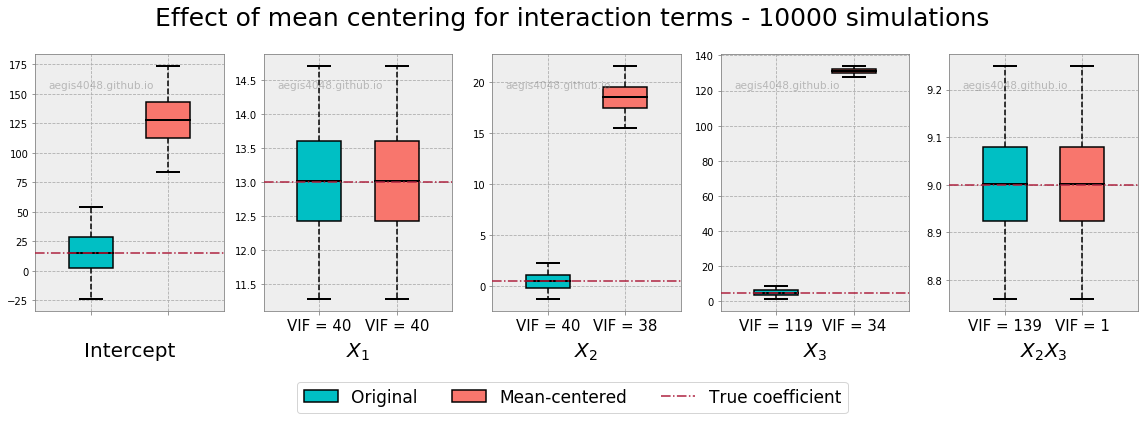

In [4]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1,
                            true_coefs_interaction=[0, 0]):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]

    y += true_coefs_interaction[0] * X[:, 1] * X[:, 2]

    return X, y

# settings
m = 10000                                   # number of simulations
correlation = 0.98                          # degree of collinearity (HIGH)

kwargs = {
    'n': 50,                                # sample size
    'true_coefs': [13, 0.5, 5],             # linear regression coefficients, 2 features
    'true_intercept': 15,                   # y-intercept
    'feature_means': [-12, 14, 2],          # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1,                             # standard deviation of gaussian noise
    'true_coefs_interaction': [9]           # linear regression coefficients of interaction terms
}

# high collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

# simulation
org_params = []
std_params = []
for i in range(m):

    ################################################ Original ################################################
    
    np.random.seed(i)

    # generate high collinearity data
    X_org, y_org = generate_collinear_data(cov, **kwargs)

    # add interaction terms
    interaction_org_1 = X_org[:, 1].reshape(-1, 1) * X_org[:, 2].reshape(-1, 1)    # x2 * x3
    X_org = np.concatenate([X_org, interaction_org_1], axis=1)

    # VIF
    vifs_org = np.linalg.inv(pd.DataFrame(X_org).corr().values).diagonal()

    # fit linear regression model
    X_st_org = sm.add_constant(X_org)
    model_org = sm.OLS(y_org, X_st_org).fit()
    org_params.append(model_org.params)

    ############################################## Mean-centered ##############################################
    
    np.random.seed(i)
    
    # generate high collinearity data
    X_std, y_std = generate_collinear_data(cov, **kwargs)

    # mean-center independent variables
    scaler = StandardScaler(with_std=False)
    X_std = scaler.fit_transform(X_std)

    # add interaction terms
    interaction_std_1 = X_std[:, 1].reshape(-1, 1) * X_std[:, 2].reshape(-1, 1)    # x2 * x3
    X_std = np.concatenate([X_std, interaction_std_1], axis=1)

    # VIF
    vifs_std = np.linalg.inv(pd.DataFrame(X_std).corr().values).diagonal()

    # fit linear regression model
    X_st_std = sm.add_constant(X_std)
    model_std = sm.OLS(y_std, X_st_std).fit()
    std_params.append(model_std.params)

    ##########################################################################################################

# list to numpy conversion
org_params = np.asarray(org_params)
std_params = np.asarray(std_params)

#################################################### Plot ####################################################

# plotting
def styling(ax):
    ax.set_facecolor('#eeeeee')
    ax.grid(True, linestyle='--', color='#acacac')
    ax.tick_params(color='grey')
    _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]
    ax.text(0.35, 0.88, 'aegis4048.github.io', fontsize=10.5, ha='center', va='center',
            transform=ax.transAxes, color='grey', alpha=0.5)

boxplot_styling = {
    'sym': '',
    'whis': [2.5, 97.5],
    'showfliers': False,
    'vert': True,
    'capprops': dict(linewidth=2.0, color='k'),
    'medianprops': dict(linewidth=2.0, color='k'),
    'widths': (0.4),
    'patch_artist': True,
    'whiskerprops': dict(linewidth=1.5, color='k', linestyle='--'),
}

labels = ['Intercept', '$X_1$', '$X_2$', '$X_3$', '$X_2X_3$']
true_params = [kwargs['true_intercept']] + kwargs['true_coefs'] + kwargs['true_coefs_interaction']

fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

for i, (ax, label, true_param) in enumerate(zip(axes, labels, true_params)):
    bp1 = ax.boxplot(org_params[:, i], positions=[1.0],
                     boxprops=dict(linewidth=1.5, facecolor='#00bfc4'),
                     **boxplot_styling)
    bp2 = ax.boxplot(std_params[:, i], positions=[1.7],
                     boxprops=dict(linewidth=1.5, facecolor='#f8766d'),
                     **boxplot_styling)
    styling(ax)
    ax.set_title(label, fontsize=20, y=-0.2)
    if i != 0:
        ax.set_xticklabels(['VIF = {}'.format(int(vifs_org[i - 1])),
                            'VIF = {}'.format(int(vifs_std[i - 1]))], fontsize=15)
    else:
        ax.set_xticklabels([])
        
    ls_handle = ax.axhline(true_param, linestyle='-.', color='#ad203e', label='True value', zorder=9) 
    
fig.legend([bp1["boxes"][0], bp2["boxes"][0], ls_handle], ['Original', 'Mean-centered', 'True coefficient'],
           loc='lower center', ncol=3, borderaxespad=0.7, fontsize=17)
fig.suptitle('Effect of mean centering for interaction terms - %.f simulations' % m, fontsize=25);
fig.tight_layout(rect=[0, 0.1, 1, 0.9])

In [3]:
fig.savefig('multicollinearity_interaction_conf_int.png', dpi=400)

In [10]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

############################################# create collinear data #############################################

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1,
                            true_coefs_interaction=[0, 0]):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]

    y += true_coefs_interaction[0] * X[:, 1] * X[:, 2]

    return X, y

# settings
m = 10000                                   # number of simulations
correlation = 0.98                          # degree of collinearity (HIGH)

kwargs = {
    'n': 50,                                # sample size
    'true_coefs': [13, 0.5, 5],             # linear regression coefficients, 2 features
    'true_intercept': 15,                   # y-intercept
    'feature_means': [-12, 14, 2],          # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1,                             # standard deviation of gaussian noise
    'true_coefs_interaction': [9]           # linear regression coefficients of interaction terms
}

# high collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

#################################################  Original data ################################################

np.random.seed(1)

# generate high collinearity data
X_org, y_org = generate_collinear_data(cov, **kwargs)

# add interaction terms
interaction_org_1 = X_org[:, 1].reshape(-1, 1) * X_org[:, 2].reshape(-1, 1)    # x2 * x3
X_org = np.concatenate([X_org, interaction_org_1], axis=1)

# VIF
vifs_org = np.linalg.inv(pd.DataFrame(X_org).corr().values).diagonal()

# fit linear regression model
X_st_org = sm.add_constant(X_org)
model_org = sm.OLS(y_org, X_st_org).fit()

#################################################  Mean-centered ################################################

np.random.seed(1)

# generate high collinearity data
X_std, y_std = generate_collinear_data(cov, **kwargs)

# mean-center independent variables
scaler = StandardScaler(with_std=False)
X_std = scaler.fit_transform(X_std)

# add interaction terms
interaction_std_1 = X_std[:, 1].reshape(-1, 1) * X_std[:, 2].reshape(-1, 1)    # x2 * x3
X_std = np.concatenate([X_std, interaction_std_1], axis=1)

# VIF
vifs_std = np.linalg.inv(pd.DataFrame(X_std).corr().values).diagonal()

# fit linear regression model
X_st_std = sm.add_constant(X_std)
model_std = sm.OLS(y_std, X_st_std).fit()

#################################################  Print output #################################################

print(model_org.summary())
print()
print()
print(model_std.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.848e+05
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.97e-98
Time:                        23:44:48   Log-Likelihood:                -65.953
No. Observations:                  50   AIC:                             141.9
Df Residuals:                      45   BIC:                             151.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.0233     25.117      2.071      0.0

In [7]:
print(model_org.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.848e+05
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.97e-98
Time:                        20:14:02   Log-Likelihood:                -65.953
No. Observations:                  50   AIC:                             141.9
Df Residuals:                      45   BIC:                             151.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.0233     25.117      2.071      0.0

In [8]:
print(model_std.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.848e+05
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.97e-98
Time:                        20:14:09   Log-Likelihood:                -65.953
No. Observations:                  50   AIC:                             141.9
Df Residuals:                      45   BIC:                             151.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.9510      0.177    699.380      0.0

In [5]:
model_org.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.181e+05
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.64e-99
Time:                        20:05:35   Log-Likelihood:                -75.229
No. Observations:                  50   AIC:                             160.5
Df Residuals:                      45   BIC:                             170.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0978     19.553      0.107      0.915     -37.284      41.480
x1            12.2991      0.838     14.669      0.000      10.610      13.988
x2             0.7617      0.884      0.862      0.393      -1.018       2.541
x3             5.4631      1.541      3.546      0.001       2.360       8.566
x4             8.9981      0.107     84.047      0.000       8.782       9.214
==============================================================================
Omnibus:                        1.684   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.431   Jarque-Bera (JB):                1.432
Skew:                          -0.256   Prob(JB):                        0.489
Kurtosis:                       2.348   Cond. No.                     4.64e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
model_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.181e+05
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.64e-99
Time:                        20:05:41   Log-Likelihood:                -75.229
No. Observations:                  50   AIC:                             160.5
Df Residuals:                      45   BIC:                             170.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        132.1829      0.215    614.006      0.000     131.749     132.616
x1            12.2991      0.838     14.669      0.000      10.610      13.988
x2            19.0117      0.858     22.166      0.000      17.284      20.739
x3           131.5856      0.825    159.449      0.000     129.923     133.248
x4             8.9981      0.107     84.047      0.000       8.782       9.214
==============================================================================
Omnibus:                        1.684   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.431   Jarque-Bera (JB):                1.432
Skew:                          -0.256   Prob(JB):                        0.489
Kurtosis:                       2.348   Cond. No.                         15.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [3]:
fig.savefig('multicollinearity_interaction_conf_int.png', dpi=400)

1. Mean centering changes the interpretation of coefficients and y-intercept

2. Mean centering removes structural multicollinearty, but does not reduce data multicollinearity

    * Correlation matrix pic (only multicollinearity involved with interaction terms are reduced. This is why it's irrelevant when you don't add interaction terms.)
    * VIF
    * does not reduce data colliearity, affects only variables involved with interaction terms. 

3. Mean centering does not improve the precision of interaction term's coefficient estimate 

    * simulation result
    * The purpose of any remedial procedures of multicollinearity is to increase the precision of the coefficient estimates of features. As explained above, 
    
4. While mean centering reduces the standard errors of coefficient estimates, it has no practical advantage

    * Statsmodel results
    * We observe that the stardard errors have decreased, but this has no meaning. Decreased compared to what?

Mean centering subtracts each independent variable's mean from itself. Assume the following arbitrary linear model with three features and an interaction term:

<div id="eq-9" style="font-size: 1rem;">
$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_2 x_3 \tag{9}$$
</div>

Applying mean centering, the model becomes:

<div id="eq-10" style="font-size: 1rem;">
$$ y = \beta_0^* + \beta_1^* (x_1 - \bar{x_1}) + \beta_2^* (x_2 - \bar{x_2}) + \beta_3^* (x_3 - \bar{x_3}) + \beta_4^* (x_2 - \bar{x_2}) (x_3 - \bar{x_3}) \tag{10}$$
</div>

where <span style="font-size: 90% !important">$\bar{x_i}$</span> is the mean of the i-th feature, and <span style="font-size: 90% !important">$\beta_i^*$</span> is the new i-th coefficient of the mean-centered model. Rearranging <a href="#eq-10">eq (10)</a>, it can be algebracially shown that mean centering changes the values of the coefficients:

<div id="eq-11" style="font-size: 1rem;">
$$
\begin{align}
   \beta_0^* &= \beta_0 - \beta_1\bar{x_1} - \beta_2\bar{x_2} - \beta_3\bar{x_3} - \beta_4\bar{x_2}\bar{x_3} \label{}\tag{11}\\
   \beta_1^* &= \beta_1 \label{}\tag{12}\\
   \beta_2^* &= \beta_2 - \beta_4 \bar{x_3} \label{}\tag{13}\\
   \beta_3^* &= \beta_3 - \beta_4 \bar{x_2} \label{}\tag{14}\\
   \beta_4^* &= \beta_4 \label{}\tag{15}\\
\end{align}
$$</div>

From the above derivation of the mean-centered coefficients, we observe that centering:

- <p style="margin-top: 5px !important">changes the intercept value (<span style="font-size: 90% !important">$\beta_0^*$</span>)</p>
- <p style="margin-top: 5px !important">changes the coefficient values of the features (<span style="font-size: 90% !important">$x_2$</span> and <span style="font-size: 90% !important">$x_3$</span>) involved with the interaction term (<span style="font-size: 90% !important">$x_2 x_3$</span>)</p>
- <p style="margin-top: 5px !important">does not change the coefficient value of the feature (<span style="font-size: 90% !important">$x_1$</span>) not involved with the interaction term (<span style="font-size: 90% !important">$x_2 x_3$</span>)</p>
- <p style="margin-top: 5px !important">does not change the coefficient value of the interaction term (<span style="font-size: 90% !important">$x_2 x_3$</span>)</p>

These observations hold true for all mean-centered models with interaction terms.

While centering complicates the interpretation of the coefficients, it **improves the interpretation of the y-intercept.** Consider a person's height as a dependent variable <span style="font-size: 90% !important">$y$</span> and weight as an independent variable <span style="font-size: 90% !important">$x$</span>. Before centering, the y-intercept <span style="font-size: 90% !important">$\beta_0$</span> is the height of a person with weight 0, which doesn't make sense. After centering, <span style="font-size: 90% !important">$\beta_0$</span> is the height of a person with average weight, because <span style="font-size: 90% !important">$x - \bar{x} = 0$</span>. In this case, the numerical value of <span style="font-size: 90% !important">$\beta_0$</span> has a real world interpretation. **This makes the interpretation of the intercept to be the expected values of <span style="font-size: 90% !important">$y$</span> when the features are set to their sample means.**

---

Let's see how mean centering reduce structural multicollinearity caused by interaction terms with Python demonstration. 

<div id="fig-12" class="row" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_mean_centered_kendall.png"></div>
    <div class="col-12"><p class="image-description">Figure 12: Effect of mean centering with interaction terms on correlation matrix</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (12)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import matplotlib.pyplot as plt
                import pandas as pd
                import seaborn as sns
                import numpy as np
                import statsmodels.api as sm
                from sklearn.preprocessing import StandardScaler

                ############################################# create collinear data #############################################

                np.random.seed(1)

                def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

                    # random generation of 3D gaussian collinear features.
                    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                    # generate gaussian white noise.
                    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                    # make the outcome.
                    y = true_intercept + gaussian_noise
                    for i in range(len(true_coefs)):
                        y += true_coefs[i] * X[:, i]

                    return X, y

                # settings
                correlation = 0.3                          # degree of collinearity (HIGH)

                kwargs = {
                    'n': 1000,
                    'true_coefs': [13, 0.5, 5],    # linear regression coefficients, 2 features
                    'true_intercept': 2,                    # y-intercept
                    'feature_means': [15, 1, 8],       # means multivariate normal distribution. This is not important
                    'loc': 0,                               # mean of gaussian noise
                    'scale': 1                              # standard deviation of gaussian noise
                }

                # high collinearity covariance matrix
                cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
                np.fill_diagonal(cov, 1)

                X, y = generate_collinear_data(cov, **kwargs)

                ############################################ Add interaction terms ###############################################

                features = ['$X_1$', '$X_2$', '$X_3$']

                # original
                df_org = pd.DataFrame(X, columns=features)
                df_org['$X_2 \cdot X_3$'] = df_org['$X_2$'].values * df_org['$X_3$'].values
                corr_org = df_org.corr(method='kendall').values

                # mean-centered
                scaler = StandardScaler(with_mean=True, with_std=False)
                X_cnt = scaler.fit_transform(X)
                df_cnt = pd.DataFrame(X_cnt, columns=features)
                df_cnt['$X_2 \cdot X_3$'] = df_cnt['$X_2$'].values * df_cnt['$X_3$'].values
                corr_cnt = df_cnt.corr(method='kendall').values

                ###################################################### plot ######################################################

                fig, axes = plt.subplots(1, 2, figsize=(11.5, 5))
                cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=60)

                sns.heatmap(corr_org, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5, ax=axes[0], annot=True)
                sns.heatmap(corr_cnt, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5, ax=axes[1], annot=True)

                axes[0].set_xticklabels(list(df_org.columns))
                axes[0].set_yticklabels(list(df_org.columns))
                axes[0].set_title('Original', fontsize=15)
                axes[0].text(0.3, 0.9, 'aegis4048.github.io', fontsize=12, ha='center', va='center', 
                             transform=axes[0].transAxes, color='grey', alpha=0.5)

                axes[1].set_xticklabels(list(df_cnt.columns))
                axes[1].set_yticklabels(list(df_cnt.columns))
                axes[1].set_title('Mean-centered', fontsize=15)
                axes[1].text(0.3, 0.9, 'aegis4048.github.io', fontsize=12, ha='center', va='center', 
                             transform=axes[1].transAxes, color='grey', alpha=0.5)

                axes[1].text(-0.3, 0.43, r'$\Longrightarrow$', transform=axes[1].transAxes, fontsize=30)

                fig.suptitle('Kendall\'s correlation coefficient matrix', fontsize=20)
                fig.tight_layout(rect=[0, 0, 1, 0.94])
            </code>
        </pre>
    </div>
</div>

# Notes: statistical significance

We observe an interesting phenomenon: x2 is not significant. This explains the reason that the VIF for x2 was low, even though there was an interaction term that involves x2.

https://link.springer.com/article/10.3758/s13428-015-0624-x

In [26]:
from numpy.random import seed
from scipy.stats import spearmanr

In [41]:
from matplotlib import pyplot as plt

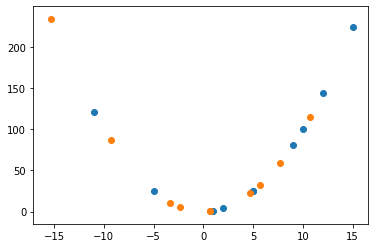

In [48]:
plt.scatter(x1, x1**2)
plt.scatter(x1_cent, x1_cent**2)

In [43]:
x1 = np.array([5, 10, 1, 2, 9, -11, -5, 12, 15, 5])
x2 = np.array([21, 203, 293, 1, -13, -53, -31, 1, -45, -76])

x1_cent = x1 - np.mean(x1)
x2_cent = x2 - np.mean(x2)

print(spearmanr(x1, x1 * x2)[0])
print(spearmanr(x1_cent, x1_cent * x2_cent)[0])

-0.480245379507251
-0.4620082131968491


In [36]:
x1 - np.mean(x1)

array([ -9.,  -4., -13., -12.,  -5., -25., -19.,  -2.,   1.,  88.])

In [37]:
np.mean(x1)

14.0

In [19]:
x1 * x2

array([-126,   20,   12,  196,  -45, -352,   10,  372,  315])

In [51]:
a = np.array([34.6, 45.0, 62.3, 58.9, 42.5, 44.3, 67.9, 58.5, 35.6, 49.6, 33.0])

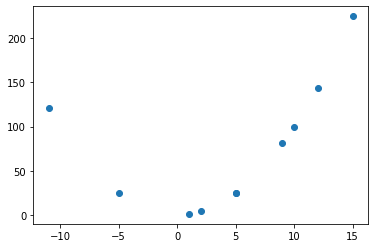

In [54]:
plt.scatter(x1, x1 ** 2)

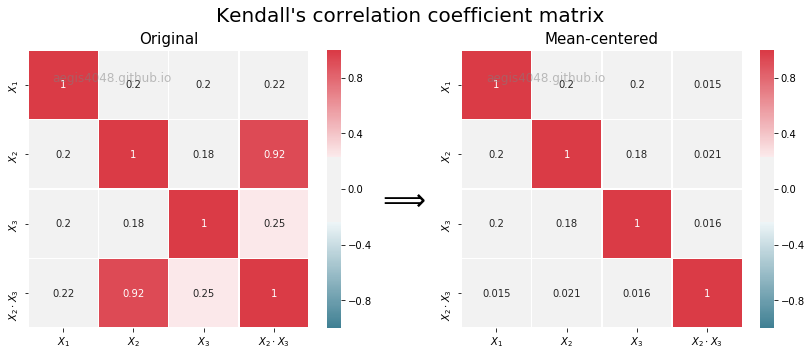

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

############################################# create collinear data #############################################

np.random.seed(1)

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]

    return X, y

# settings
correlation = 0.3                          # degree of collinearity (HIGH)

kwargs = {
    'n': 1000,
    'true_coefs': [13, 0.5, 5],    # linear regression coefficients, 2 features
    'true_intercept': 2,                    # y-intercept
    'feature_means': [15, 1, 8],       # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1                              # standard deviation of gaussian noise
}

# high collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

X, y = generate_collinear_data(cov, **kwargs)

############################################ Add interaction terms ###############################################

features = ['$X_1$', '$X_2$', '$X_3$']

# original
df_org = pd.DataFrame(X, columns=features)
df_org['$X_2 \cdot X_3$'] = df_org['$X_2$'].values * df_org['$X_3$'].values
corr_org = df_org.corr(method='kendall').values

# mean-centered
scaler = StandardScaler(with_mean=True, with_std=False)
X_cnt = scaler.fit_transform(X)
df_cnt = pd.DataFrame(X_cnt, columns=features)
df_cnt['$X_2 \cdot X_3$'] = df_cnt['$X_2$'].values * df_cnt['$X_3$'].values
corr_cnt = df_cnt.corr(method='kendall').values

###################################################### plot ######################################################

fig, axes = plt.subplots(1, 2, figsize=(11.5, 5))
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=60)

sns.heatmap(corr_org, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5, ax=axes[0], annot=True)
sns.heatmap(corr_cnt, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5, ax=axes[1], annot=True)

axes[0].set_xticklabels(list(df_org.columns))
axes[0].set_yticklabels(list(df_org.columns))
axes[0].set_title('Original', fontsize=15)
axes[0].text(0.3, 0.9, 'aegis4048.github.io', fontsize=12, ha='center', va='center', 
             transform=axes[0].transAxes, color='grey', alpha=0.5)

axes[1].set_xticklabels(list(df_cnt.columns))
axes[1].set_yticklabels(list(df_cnt.columns))
axes[1].set_title('Mean-centered', fontsize=15)
axes[1].text(0.3, 0.9, 'aegis4048.github.io', fontsize=12, ha='center', va='center', 
             transform=axes[1].transAxes, color='grey', alpha=0.5)

axes[1].text(-0.3, 0.43, r'$\Longrightarrow$', transform=axes[1].transAxes, fontsize=30)

fig.suptitle('Kendall\'s correlation coefficient matrix', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.94])

In [7]:
fig.savefig('multicollinearity_mean_centered_kendall.png', dpi=400)

In [38]:
spearmanr(df['$X_1$'].values, df['$X_2$'].values)

SpearmanrResult(correlation=0.38305295905295905, pvalue=2.683974867916312e-36)

In [18]:
import numpy as np

df['$X_2 \cdot X_3$'] = df['$X_2$'].values * df['$X_3$'].values

In [19]:
np.linalg.inv(df.corr().values).diagonal()

array([ 67.44330961,  70.24218782, 124.87759573, 131.95192727])

In [17]:
np.linalg.inv(df.corr().values).diagonal()

array([66.18666789, 60.01401724, 36.63775074])

1. Changes the interpretation of coefficients.

2. Intercept has more meaningful interpretation.

1. Interaction terms are unaffected.

2. Variables not involved with interaction terms are unaffected

4. Intercept has more meaningful interpretation.


As far as the interpretation is concerned: Before centering α, its meaning is the height of a person with weight 0. Thus, α would be a just a numerical intercept (possibly negative) without any real world interpretation. Centering the data around the mean of the weight, will lead to α representing the height of a person with average weight. In this case, the numeric value of α has a real world interpretation.

Figure. 

https://online.stat.psu.edu/stat462/node/182/

<div id="Principle component regression"></div>

### 5.4 Principle component regression

One major use of PCA lies in overcoming the multicollinearity problem. PCA can aptly deal with such situations by excluding some of the low-variance principal components in the regression step. In addition, by usually regressing on only a subset of all the principal components, PCR can result in dimension reduction through substantially lowering the effective number of parameters characterizing the underlying model.

* Handles with feature elimination & lowering collinearity

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

############################################# import data #############################################

file = 'sample_data/collinear.csv'
features = ['$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_5$']
df = pd.read_csv(file)
df = df[features]

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

############################################# import data #############################################

file = 'sample_data/collinear.csv'
features = ['$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_5$']
df = pd.read_csv(file)
df = df[features]

####################################### VIFs with original data #######################################

vifs_orig = np.linalg.inv(df.corr().values).diagonal()

df_vif_orig = pd.DataFrame()
df_vif_orig['Features'] = df.columns
df_vif_orig['VIF'] = vifs_orig

##################################### VIFs with interaction terms #####################################

df['$X_2 \cdot X_3$'] = df['$X_2$'].values * df['$X_3$'].values
df['$X_1^2$'] = df['$X_1$'].values ** 2

vifs_inter = np.linalg.inv(df.corr().values).diagonal()

df_vif_inter = pd.DataFrame()
df_vif_inter['Features'] = df.columns
df_vif_inter['VIF'] = vifs_inter

print(df_vif_orig)
print()
print(df_vif_inter)

  Features       VIF
0    $X_1$  5.398315
1    $X_2$  2.378517
2    $X_3$  8.598212
3    $X_4$  2.157740
4    $X_5$  3.700524

          Features       VIF
0            $X_1$  5.420306
1            $X_2$  2.379443
2            $X_3$  8.655563
3            $X_4$  2.186982
4            $X_5$  3.708457
5  $X_2 \cdot X_3$  1.243502
6          $X_1^2$  1.160139


Structural multicollinearity

Data multicollinearity

https://stats.stackexchange.com/questions/223432/standardising-non-normally-distributed-predictors-for-regression

Centering is just a linear transformation, so it will not change anything about the shapes of the distributions or the relationship between them. Instead, it just slides them in one direction or the other.

When the model is additive and linear, centering has nothing to do with collinearity. Centering can only help when there are multiple terms per variable such as square or interaction terms.

Making zero intercept makes the model more interpretable

https://www3.nd.edu/~rwilliam/stats2/l53.pdf

Standardized coefficients interpretation is difficult.

Why does centering work? Read (here)[https://stats.stackexchange.com/questions/65898/why-could-centering-independent-variables-change-the-main-effects-with-moderation]

<div id="Elimination"></div>

### 5.3 Elimination

#### Demonstration

<div id="fig-12" class="row full_screen_margin_70 mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_standardization_remedy.png"></div>
    <div class="col-12"><p class="image-description">Figure 12: Effect of interaction terms on VIF</p></div>
</div>

#### In practice....

Used to reduce the std error of statsmodel linear regression analysis

In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

######################################## Collinear random data generation #########################################

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1, 
                            true_coefs_interaction=[0, 0]):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]
        
    #y += true_coefs_interaction[0] * (X[:, 0] ** 2) + true_coefs_interaction[1] * X[:, 1] * X[:, 2]

    return X, y

# settings
m = 1000                                   # number of simulations
correlation = 0.01                          # degree of collinearity (HIGH)

kwargs = {
    'n': 10000,                             # sample size
    'true_coefs': [13, 0.5, 5, 42],         # linear regression coefficients, 2 features
    'true_intercept': 15,                   # y-intercept
    'feature_means': [-12, 14, 2, -20],     # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1,                             # standard deviation of gaussian noise
    'true_coefs_interaction': [-2, 9]       # linear regression coefficients of interaction terms
}

# high collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

print('True intercept + coefficients:  ', [kwargs['true_intercept']] + kwargs['true_coefs'] + kwargs['true_coefs_interaction'])
print()

############################################# Original #############################################

X_org, y_org = generate_collinear_data(cov, **kwargs)

#interaction_org_1 = X_org[:, 0].reshape(-1, 1) ** 2                            # x1^2
#interaction_org_2 = X_org[:, 1].reshape(-1, 1) * X_org[:, 2].reshape(-1, 1)    # x2 * x3
#X_org = np.concatenate([X_org, interaction_org_1, interaction_org_2], axis=1)

X_st_org = sm.add_constant(X_org)
model_org = sm.OLS(y_org, X_st_org).fit()

print('Original: ', [ '%.2f' % elem for elem in model_org.params ])

########################################## Mean-centered ###########################################

X_std, y_std = generate_collinear_data(cov, **kwargs)

# centering
scaler = StandardScaler(with_mean=True, with_std=False)
X_std = scaler.fit_transform(X_std)

# X_std, y_std = scaler.fit_transform(X_std), scaler.fit_transform(y_std.reshape(-1, 1)).flatten()

# add interaction terms
#interaction_std_1 = X_std[:, 0].reshape(-1, 1) ** 2                            # x1^2
#interaction_std_2 = X_std[:, 1].reshape(-1, 1) * X_std[:, 2].reshape(-1, 1)    # x2 * x3
#X_std = np.concatenate([X_std, interaction_std_1, interaction_std_2], axis=1)

# fit
X_std = sm.add_constant(X_std)
model_std = sm.OLS(y_std, X_std).fit()

print('Centering:  ', [ '%.2f' % elem for elem in model_std.params ])

True intercept + coefficients:   [15, 13, 0.5, 5, 42, -2, 9]

Original:  ['14.81', '13.00', '0.50', '4.99', '41.99']
Centering:   ['-963.70', '13.00', '0.51', '5.00', '42.01']


In [3]:
np.mean(y_std)

-963.7033929573824

In [15]:
vifs_std = np.linalg.inv(pd.DataFrame(X_org).corr().values).diagonal()  

In [21]:
df = pd.DataFrame(X_org)
vifs = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

vifs

[5086.798113631407,
 913.5323590009473,
 922.5802364981283,
 391.91660765629143,
 1408.0394090339094,
 921.8096453141474]

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

############################################# create collinear data #############################################

np.random.seed(1)

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]

    return X, y

# settings
correlation = 0.98                           # degree of collinearity (LOW)

kwargs = {
    'n': 1000,
    'true_coefs': [13, 0.5, 5],             # linear regression coefficients, 2 features
    'true_intercept': 2,                    # y-intercept
    'feature_means': [15, 1, 8],            # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1                              # standard deviation of gaussian noise
}

# low collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

X, y = generate_collinear_data(cov, **kwargs)

############################################ Add interaction terms ###############################################

features = ['$X_1$', '$X_2$', '$X_3$']

# original
df_org = pd.DataFrame(X, columns=features)

# interaction
df_int = pd.DataFrame(X, columns=features)
df_int['$X_2 \cdot X_3$'] = df_int['$X_2$'].values * df_int['$X_3$'].values
corr_int = df_int.corr(method='kendall').values

# mean-centered
scaler = StandardScaler(with_mean=True, with_std=False)
X_cnt = scaler.fit_transform(X)
df_cnt = pd.DataFrame(X_cnt, columns=features)
df_cnt['$X_2 \cdot X_3$'] = df_cnt['$X_2$'].values * df_cnt['$X_3$'].values

################################################## Commput VIFs ##################################################

vifs_org = np.linalg.inv(df_org.corr().values).diagonal()
df_vif_org = pd.DataFrame()
df_vif_org['Features'] = df_org.columns
df_vif_org['VIF'] = vifs_org
print(df_vif_org)

print()

vifs_int = np.linalg.inv(df_int.corr().values).diagonal()
df_vif_int = pd.DataFrame()
df_vif_int['Features'] = df_int.columns
df_vif_int['VIF'] = vifs_int
print(df_vif_int)

print()

vifs_cnt = np.linalg.inv(df_cnt.corr().values).diagonal()
df_vif_cnt = pd.DataFrame()
df_vif_cnt['Features'] = df_cnt.columns
df_vif_cnt['VIF'] = vifs_cnt
print(df_vif_cnt)

  Features        VIF
0    $X_1$  31.424442
1    $X_2$  33.921560
2    $X_3$  32.850339

          Features        VIF
0            $X_1$  31.449014
1            $X_2$  69.808368
2            $X_3$  33.896329
3  $X_2 \cdot X_3$  47.816783

          Features        VIF
0            $X_1$  31.449014
1            $X_2$  33.926453
2            $X_3$  32.928956
3  $X_2 \cdot X_3$   1.005069


In [18]:
X_std.shape

(10000, 7)

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [8]:
print(model_org.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.406e+05
Date:                Sun, 19 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:08:58   Log-Likelihood:                -1389.1
No. Observations:                1000   AIC:                             2788.
Df Residuals:                     995   BIC:                             2813.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7842      5.521      2.315      0.0

In [9]:
print(model_std.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.617e+05
Date:                Sun, 19 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:08:59   Log-Likelihood:                -1431.0
No. Observations:                1000   AIC:                             2872.
Df Residuals:                     995   BIC:                             2896.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -961.9543      0.032     -3e+04      0.0

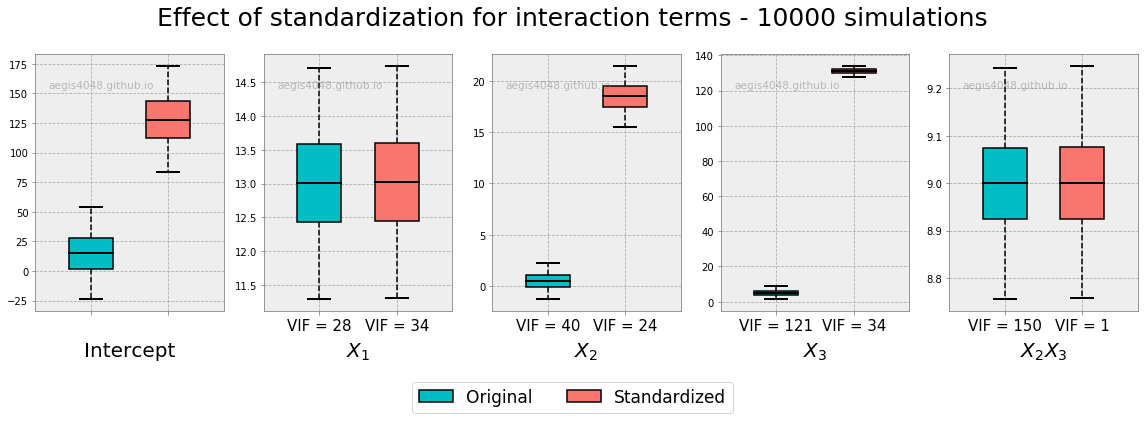

In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1, 
                            true_coefs_interaction=[0, 0]):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]
        
    y += true_coefs_interaction[0] * X[:, 1] * X[:, 2]

    return X, y

# settings
m = 10000                                   # number of simulations
correlation = 0.98                          # degree of collinearity (HIGH)

kwargs = {
    'n': 50,                              # sample size
    'true_coefs': [13, 0.5, 5],         # linear regression coefficients, 2 features
    'true_intercept': 15,                    # y-intercept
    'feature_means': [-12, 14, 2],     # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1,                             # standard deviation of gaussian noise
    'true_coefs_interaction': [9]       # linear regression coefficients of interaction terms
}

# high collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

# simulation
org_params = []
std_params = []
for i in range(m):
    
    ################################################ Original ################################################
    
    # generate high collinearity data
    X_org, y_org = generate_collinear_data(cov, **kwargs)
    
    # add interaction terms
    interaction_org_1 = X_org[:, 0].reshape(-1, 1) ** 2                            # x1^2
    interaction_org_1 = X_org[:, 1].reshape(-1, 1) * X_org[:, 2].reshape(-1, 1)    # x2 * x3
    X_org = np.concatenate([X_org, interaction_org_1], axis=1)
    
    # VIF
    vifs_org = np.linalg.inv(pd.DataFrame(X_org).corr().values).diagonal()
    
    # fit linear regression model
    X_st_org = sm.add_constant(X_org)
    model_org = sm.OLS(y_org, X_st_org).fit()
    org_params.append(model_org.params)
    
    ############################################## Mean-centered ##############################################
    
    # generate high collinearity data
    X_std, y_std = generate_collinear_data(cov, **kwargs)

    # mean-center independent variables
    scaler = StandardScaler(with_std=False)
    X_std = scaler.fit_transform(X_std)
    
    # add interaction terms
    interaction_std_1 = X_std[:, 0].reshape(-1, 1) ** 2                            # x1^2
    interaction_std_1 = X_std[:, 1].reshape(-1, 1) * X_std[:, 2].reshape(-1, 1)    # x2 * x3
    X_std = np.concatenate([X_std, interaction_std_1], axis=1)
    
    # VIF
    vifs_std = np.linalg.inv(pd.DataFrame(X_std).corr().values).diagonal()    
    
    # fit linear regression model
    X_st_std = sm.add_constant(X_std)
    model_std = sm.OLS(y_std, X_st_std).fit()
    std_params.append(model_std.params)
    
    ##########################################################################################################

# list to numpy conversion
org_params = np.asarray(org_params)
std_params = np.asarray(std_params)

#################################################### Plot ####################################################

# plotting
def styling(ax):
    ax.set_facecolor('#eeeeee')
    ax.grid(True, linestyle='--', color='#acacac')
    ax.tick_params(color='grey')
    _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]
    ax.text(0.35, 0.88, 'aegis4048.github.io', fontsize=10.5, ha='center', va='center',
            transform=ax.transAxes, color='grey', alpha=0.5)

boxplot_styling = {
    'sym': '',
    'whis': [2.5, 97.5],
    'showfliers': False,
    'vert': True,
    'capprops': dict(linewidth=2.0, color='k'),
    'medianprops': dict(linewidth=2.0, color='k'),
    'widths': (0.4),
    'patch_artist': True,
    'whiskerprops': dict(linewidth=1.5, color='k', linestyle='--'),
}

#labels = ['Intercept', '$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_1^2$', '$X_2X_3$']
labels = ['Intercept', '$X_1$', '$X_2$', '$X_3$', '$X_2X_3$']

fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

for i, (ax, label) in enumerate(zip(axes, labels)):
    bp1 = ax.boxplot(org_params[:, i], positions=[1.0], 
                     boxprops=dict(linewidth=1.5, facecolor='#00bfc4'),
                     **boxplot_styling)
    bp2 = ax.boxplot(std_params[:, i], positions=[1.7], 
                     boxprops=dict(linewidth=1.5, facecolor='#f8766d'),
                     **boxplot_styling)
    styling(ax)
    ax.set_title(label, fontsize=20, y=-0.2)
    if i != 0:
        ax.set_xticklabels(['VIF = {}'.format(int(vifs_org[i - 1])), 
                            'VIF = {}'.format(int(vifs_std[i - 1]))], fontsize=15)
    else:
        ax.set_xticklabels([])

fig.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Original', 'Standardized'], 
           loc='lower center', ncol=3, borderaxespad=0.7, fontsize=17)
fig.suptitle('Effect of standardization for interaction terms - %.f simulations' % m, fontsize=25);
fig.tight_layout(rect=[0, 0.1, 1, 0.9])

In [3]:
fig.savefig('multicollinearity_interaction_conf_int.png', dpi=400)

In [7]:
model_org.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.626e+05
Date:                Mon, 20 Jan 2020   Prob (F-statistic):          8.60e-101
Time:                        12:23:12   Log-Likelihood:                -73.984
No. Observations:                  50   AIC:                             158.0
Df Residuals:                      45   BIC:                             167.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.7945     20.675     -0.619      0.539     -54.435      28.846
x1            11.8261      0.898     13.173      0.000      10.018      13.634
x2             1.4098      0.996      1.415      0.164      -0.597       3.417
x3             7.1377      1.967      3.628      0.001       3.175      11.100
x4             8.8867      0.114     77.621      0.000       8.656       9.117
==============================================================================
Omnibus:                        0.384   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.825   Jarque-Bera (JB):                0.394
Skew:                          -0.193   Prob(JB):                        0.821
Kurtosis:                       2.798   Cond. No.                     5.60e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

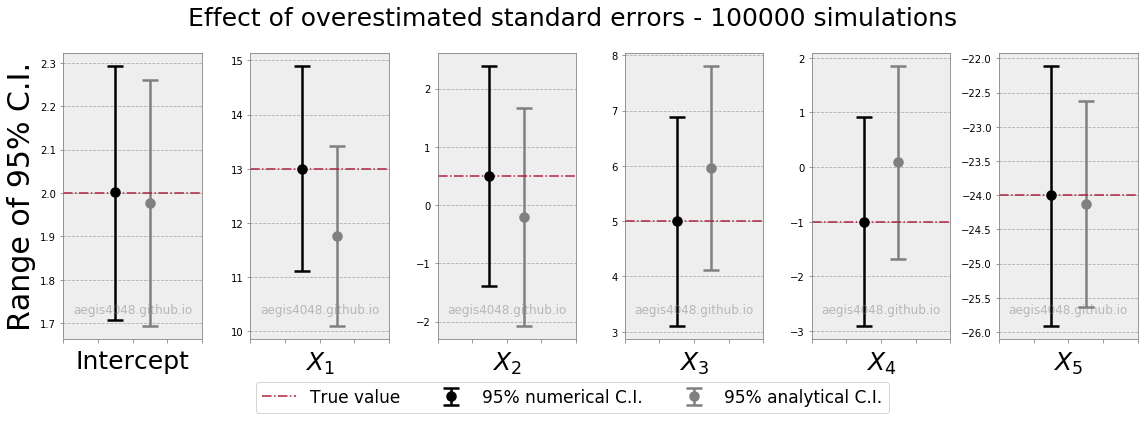

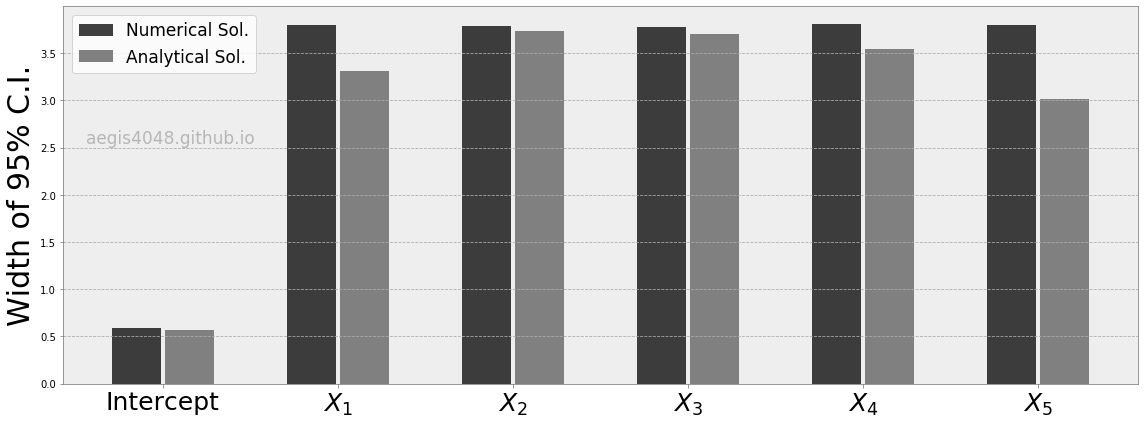

In [40]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]

    return X, y

# simulation settings
m = 100000                                 # number of simulations. WARNING!!! Large m makes execution time very long
correlation = 0.98                          # degree of collinearity (HIGH)
kwargs = {
    'n': 50,                                # sample size
    'true_coefs': [13, 0.5, 5, -1, -24],    # linear regression coefficients, 2 features
    'true_intercept': 2,                    # y-intercept
    'feature_means': [0, 0, 0, 0, 0],       # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1                              # standard deviation of gaussian noise
}

# high collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

######################################### numerical solution ################################################

params = []
for i in range(m):
    X, y = generate_collinear_data(cov, **kwargs)         # generate high collinearity data
    X_st = sm.add_constant(X)
    model = sm.OLS(y, X_st).fit()
    params.append(model.params)

params = np.asarray(params)                               # list to numpy conversion

numerical_means = np.mean(params, axis=0)                 # solution
numerical_lo = np.percentile(params, 2.5, axis=0)         # lower bound of 95% confidence interval
numerical_hi = np.percentile(params, 97.5, axis=0)        # upper bound of 95% confidence interval
numerical_width = abs(numerical_hi - numerical_lo)        # width of confidence interval

######################################### analytical solution ###############################################

X, y = generate_collinear_data(cov, **kwargs)   # generate high collinearity data
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()

analytical_means = model.params                           # solution
analytical_lo = model.conf_int(alpha=0.05)[:, 0]          # lower bound of 95% confidence interval
analytical_hi = model.conf_int(alpha=0.05)[:, 1]          # upper bound of 95% confidence interval
analytical_width = abs(analytical_hi - analytical_lo)     # width of confidence interval

######################################### Plotting:  Error bars ##############################################

def styling(ax, label):
    ax.set_xlabel(label, fontsize=25)
    ax.set_facecolor('#eeeeee')
    ax.grid(True, linestyle='--', color='#acacac', axis='y')
    ax.tick_params(color='grey')
    ax.set_xticklabels([])
    ax.set_xlim(0, 2)
    _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]
    ax.text(0.5, 0.1, 'aegis4048.github.io', fontsize=12, ha='center', va='center',
            transform=ax.transAxes, color='grey', alpha=0.5)

labels = ['Intercept', '$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_5$']
true_params = [kwargs['true_intercept']] + kwargs['true_coefs']
x = np.array([1, 2])

fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

for i, (ax, label, true_param) in enumerate(zip(axes, labels, true_params)):
    yerr_numerical = [[abs(numerical_lo[i] - numerical_means[i])], [abs(numerical_hi[i] - numerical_means[i])]]
    yerr_analytical = [[abs(analytical_lo[i] - analytical_means[i])], [abs(analytical_hi[i] - analytical_means[i])]]

    ax.errorbar(1 - 0.25, numerical_means[i], yerr=yerr_numerical,
               fmt='o', label='95% numerical C.I.', color='k', markersize=8, capsize=8, elinewidth=2.5, markeredgewidth=2.5)
    ax.errorbar(1 + 0.25, analytical_means[i], yerr=yerr_analytical,
               fmt='o', label='95% analytical C.I.', color='grey', markersize=8, capsize=8, elinewidth=2.5, markeredgewidth=2.5)
    ax.axhline(true_param, linestyle='-.', color='#ad203e', label='True value')
    styling(ax, label)

axes[0].set_ylabel('Range of 95% C.I.', fontsize=30)

fig.legend(*ax.get_legend_handles_labels(), loc='lower center', ncol=3, borderaxespad=0.7, fontsize=17)

fig.suptitle('Effect of overestimated standard errors - %.f simulations' % m, fontsize=25);
fig.tight_layout(rect=[0, 0.10, 1, 0.9])

######################################### Plotting:  Bar chart ###############################################

x = np.array([i for i in range(len(analytical_width))])

fig, ax = plt.subplots(figsize=(16, 6))

ax.bar(x - 0.15, numerical_width, align='center', alpha=0.75, width=0.28, color='k', label='Numerical Sol.')
ax.bar(x + 0.15, analytical_width, align='center', width=0.28, color='grey', label='Analytical Sol.')

ax.text(0.1, 0.65, 'aegis4048.github.io', fontsize=17, ha='center', va='center',
        transform=ax.transAxes, color='grey', alpha=0.5)
ax.set_ylabel('Width of 95% C.I.', fontsize=30)
ax.legend(fontsize=17, loc='upper left')
ax.set_xticks(x)
ax.set_xticklabels([str(label) for label in labels], fontsize=25)
ax.set_facecolor('#eeeeee')
ax.grid(True, linestyle='--', color='#acacac', axis='y')
ax.tick_params(color='grey')
_ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]

fig.tight_layout()

In [42]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     770.4
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.20e-41
Time:                        11:52:32   Log-Likelihood:                -62.903
No. Observations:                  50   AIC:                             137.8
Df Residuals:                      44   BIC:                             149.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9780      0.140     14.088      0.0

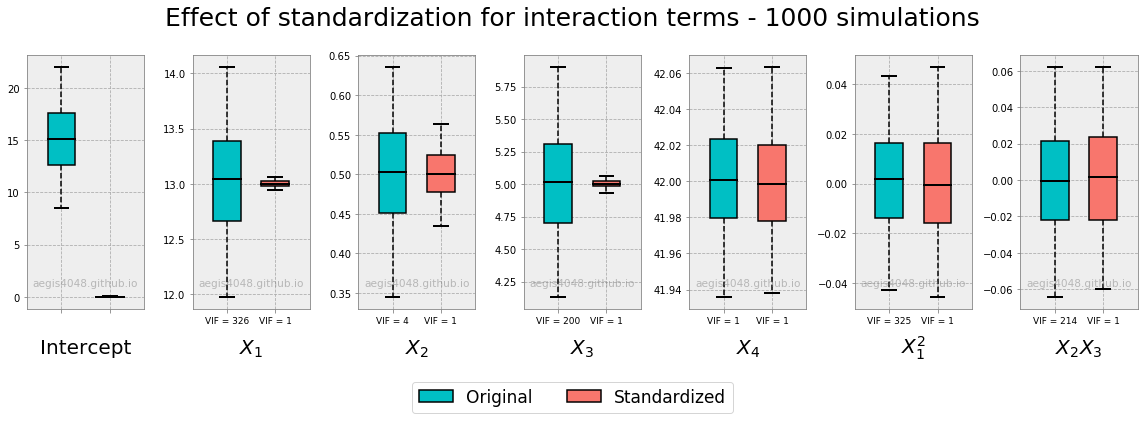

In [24]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]

    return X, y

# settings
m = 1000                                   # number of simulations
correlation = 0.1                          # degree of collinearity (HIGH)

kwargs = {
    'n': 1000,                              # sample size
    'true_coefs': [13, 0.5, 5, 42],         # linear regression coefficients, 2 features
    'true_intercept': 15,                    # y-intercept
    'feature_means': [-12, 14, 2, -20],     # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1                              # standard deviation of gaussian noise
}

# high collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

# simulation
org_params = []
std_params = []
for i in range(m):
    
    ################################################ Original ################################################
    
    # generate high collinearity data
    X_org, y_org = generate_collinear_data(cov, **kwargs)
    
    # add interaction terms
    interaction_org_1 = X_org[:, 0].reshape(-1, 1) ** 2                            # x1^2
    interaction_org_2 = X_org[:, 1].reshape(-1, 1) * X_org[:, 2].reshape(-1, 1)    # x2 * x3
    X_org = np.concatenate([X_org, interaction_org_1, interaction_org_2], axis=1)
    
    # VIF
    vifs_org = np.linalg.inv(pd.DataFrame(X_org).corr().values).diagonal()
    
    # fit linear regression model
    X_st_org = sm.add_constant(X_org)
    model_org = sm.OLS(y_org, X_st_org).fit()
    org_params.append(model_org.params)
    
    ############################################## Standardized ##############################################
    
    # generate high collinearity data
    X_std, y_std = generate_collinear_data(cov, **kwargs)
    
    # standardize
    scaler = StandardScaler(with_std=False)
    X_std, y_std = scaler.fit_transform(X_std), scaler.fit_transform(y_std.reshape(-1, 1)).flatten()
    
    # add interaction terms
    interaction_std_1 = X_std[:, 0].reshape(-1, 1) ** 2                            # x1^2
    interaction_std_2 = X_std[:, 1].reshape(-1, 1) * X_std[:, 2].reshape(-1, 1)    # x2 * x3
    X_std = np.concatenate([X_std, interaction_std_1, interaction_std_2], axis=1)
    
    # VIF
    vifs_std = np.linalg.inv(pd.DataFrame(X_std).corr().values).diagonal()    
    
    # fit linear regression model
    X_st_std = sm.add_constant(X_std)
    model_std = sm.OLS(y_std, X_st_std).fit()
    std_params.append(model_std.params)
    
    ##########################################################################################################

# list to numpy conversion
org_params = np.asarray(org_params)
std_params = np.asarray(std_params)

# plotting
def styling(ax):
    ax.set_facecolor('#eeeeee')
    ax.grid(True, linestyle='--', color='#acacac')
    ax.tick_params(color='grey')
    _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]
    ax.text(0.5, 0.1, 'aegis4048.github.io', fontsize=10.5, ha='center', va='center',
            transform=ax.transAxes, color='grey', alpha=0.5)

boxplot_styling = {
    'sym': '',
    'whis': [2.5, 97.5],
    'showfliers': False,
    'vert': True,
    'capprops': dict(linewidth=2.0, color='k'),
    'medianprops': dict(linewidth=2.0, color='k'),
    'widths': (0.4),
    'patch_artist': True,
    'whiskerprops': dict(linewidth=1.5, color='k', linestyle='--'),
}

labels = ['Intercept', '$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_1^2$', '$X_2X_3$']

fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

for i, (ax, label) in enumerate(zip(axes, labels)):
    bp1 = ax.boxplot(org_params[:, i], positions=[1.0], 
                     boxprops=dict(linewidth=1.5, facecolor='#00bfc4'),
                     **boxplot_styling)
    bp2 = ax.boxplot(std_params[:, i], positions=[1.7], 
                     boxprops=dict(linewidth=1.5, facecolor='#f8766d'),
                     **boxplot_styling)
    styling(ax)
    ax.set_title(label, fontsize=20, y=-0.2)
    if i != 0:
        ax.set_xticklabels(['VIF = {}'.format(int(vifs_org[i - 1])), 
                            'VIF = {}'.format(int(vifs_std[i - 1]))], fontsize=9)
    else:
        ax.set_xticklabels([])

fig.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Original', 'Standardized'], 
           loc='lower center', ncol=3, borderaxespad=0.7, fontsize=17)
fig.suptitle('Effect of standardization for interaction terms - %.f simulations' % m, fontsize=25);
fig.tight_layout(rect=[0, 0.1, 1, 0.9])

In [25]:
    # generate high collinearity data
    X_org, y_org = generate_collinear_data(cov, **kwargs)
    
    # add interaction terms
    interaction_org_1 = X_org[:, 0].reshape(-1, 1) ** 2                            # x1^2
    interaction_org_2 = X_org[:, 1].reshape(-1, 1) * X_org[:, 2].reshape(-1, 1)    # x2 * x3
    X_org = np.concatenate([X_org, interaction_org_1, interaction_org_2], axis=1)
    
    # VIF
    vifs_org = np.linalg.inv(pd.DataFrame(X_org).corr().values).diagonal()
    
    # fit linear regression model
    X_st_org = sm.add_constant(X_org)
    model_org = sm.OLS(y_org, X_st_org).fit()
    #org_params.append(model_org.params)

In [26]:
print(model_org.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.520e+05
Date:                Mon, 20 Jan 2020   Prob (F-statistic):               0.00
Time:                        11:33:18   Log-Likelihood:                -1411.5
No. Observations:                1000   AIC:                             2837.
Df Residuals:                     993   BIC:                             2871.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.6712      3.279      4.779      0.0

In [53]:
kwargs = {
    'n': 10000,                              # sample size
    'true_coefs': [13, 0.5, 5, 42],         # linear regression coefficients, 2 features
    'true_intercept': 15,                    # y-intercept
    'feature_means': [-12, 14, 2, -20],     # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1,                             # standard deviation of gaussian noise
    'true_coefs_interaction': [-2, 9]       # linear regression coefficients of interaction terms
}

In [4]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1, 
                            true_coefs_interaction=[0, 0]):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]
        
    y += true_coefs_interaction[0] * (X[:, 0] ** 2) + true_coefs_interaction[1] * X[:, 1] * X[:, 2]

    return X, y

# settings
m = 1000                                   # number of simulations
correlation = 0.98                          # degree of collinearity (HIGH)

kwargs = {
    'n': 10000,                              # sample size
    'true_coefs': [13, 0.5, 5, 42],         # linear regression coefficients, 2 features
    'true_intercept': 15,                    # y-intercept
    'feature_means': [-12, 14, 2, -20],     # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1,                             # standard deviation of gaussian noise
    'true_coefs_interaction': [-2, 9]       # linear regression coefficients of interaction terms
}

# high collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

X_org, y_org = generate_collinear_data(cov, **kwargs)

interaction_org_1 = X_org[:, 0].reshape(-1, 1) ** 2                            # x1^2
interaction_org_2 = X_org[:, 1].reshape(-1, 1) * X_org[:, 2].reshape(-1, 1)    # x2 * x3
X_org = np.concatenate([X_org, interaction_org_1, interaction_org_2], axis=1)

X_st_org = sm.add_constant(X_org)
model_org = sm.OLS(y_org, X_st_org).fit()

print([ '%.2f' % elem for elem in model_org.params ])

X_std, y_std = generate_collinear_data(cov, **kwargs)

# centering
scaler = StandardScaler(with_std=False)
X_std, y_std = scaler.fit_transform(X_std), scaler.fit_transform(y_std.reshape(-1, 1)).flatten()

# add interaction terms
interaction_std_1 = X_std[:, 0].reshape(-1, 1) ** 2                            # x1^2
interaction_std_2 = X_std[:, 1].reshape(-1, 1) * X_std[:, 2].reshape(-1, 1)    # x2 * x3
X_std = np.concatenate([X_std, interaction_std_1, interaction_std_2], axis=1)

# fit
X_st_std = sm.add_constant(X_std)
model_std = sm.OLS(y_std, X_st_std).fit()

print([ '%.2f' % elem for elem in model_std.params ])

['16.10', '14.03', '0.78', '5.73', '41.96', '-1.95', '8.94']
['-6.94', '60.97', '18.50', '130.88', '42.04', '-2.02', '9.01']


In [4]:
pd.DataFrame(X_std).describe()

,0,1,2,3
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,1.941949e-14,6.028493e-14,1.024576e-14,-8.558416e-14
std,9.999832e-01,1.000894e+00,1.001148e+00,9.989619e-01
min,-3.798131e+00,-3.658011e+00,-3.961630e+00,-3.853892e+00
25%,-6.674661e-01,-6.768570e-01,-6.702250e-01,-6.601235e-01
50%,1.901851e-03,-2.473357e-03,-1.843201e-03,3.266154e-03
75%,6.722287e-01,6.793375e-01,6.758215e-01,6.720686e-01
max,3.681066e+00,3.746267e+00,3.736197e+00,3.648933e+00


In [4]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

######################################## Collinear random data generation #########################################

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1, 
                            true_coefs_interaction=[0, 0]):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]
        
    y += true_coefs_interaction[0] * (X[:, 0] ** 2) + true_coefs_interaction[1] * X[:, 1] * X[:, 2]

    return X, y

# settings
m = 1000                                   # number of simulations
correlation = 0.01                          # degree of collinearity (HIGH)

kwargs = {
    'n': 10000,                             # sample size
    'true_coefs': [13, 0.5, 5, 42],         # linear regression coefficients, 2 features
    'true_intercept': 15,                   # y-intercept
    'feature_means': [-12, 14, 2, -20],     # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1,                             # standard deviation of gaussian noise
    'true_coefs_interaction': [-2, 9]       # linear regression coefficients of interaction terms
}

# high collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

print('True intercept + coefficients:  ', [kwargs['true_intercept']] + kwargs['true_coefs'] + kwargs['true_coefs_interaction'])
print()

############################################# Original #############################################

X_org, y_org = generate_collinear_data(cov, **kwargs)

interaction_org_1 = X_org[:, 0].reshape(-1, 1) ** 2                            # x1^2
interaction_org_2 = X_org[:, 1].reshape(-1, 1) * X_org[:, 2].reshape(-1, 1)    # x2 * x3
X_org = np.concatenate([X_org, interaction_org_1, interaction_org_2], axis=1)

X_st_org = sm.add_constant(X_org)
model_org = sm.OLS(y_org, X_st_org).fit()

print('Original: ', [ '%.2f' % elem for elem in model_org.params ])

########################################## Mean-centered ###########################################

X_std, y_std = generate_collinear_data(cov, **kwargs)

# centering
scaler = StandardScaler(with_mean=True, with_std=False)
X_std, y_std = scaler.fit_transform(X_std), scaler.fit_transform(y_std.reshape(-1, 1)).flatten()

# add interaction terms
interaction_std_1 = X_std[:, 0].reshape(-1, 1) ** 2                            # x1^2
interaction_std_2 = X_std[:, 1].reshape(-1, 1) * X_std[:, 2].reshape(-1, 1)    # x2 * x3
X_std = np.concatenate([X_std, interaction_std_1, interaction_std_2], axis=1)

# fit
X_std = sm.add_constant(X_std)
model_std = sm.OLS(y_std, X_std).fit()

print('Centering:  ', [ '%.2f' % elem for elem in model_std.params ])

True intercept + coefficients:   [15, 13, 0.5, 5, 42, -2, 9]

Original:  ['16.32', '13.32', '0.54', '5.10', '41.99', '-1.99', '8.99']
Centering:   ['1.95', '60.97', '18.65', '131.01', '42.02', '-1.99', '9.00']


In [48]:
pd.DataFrame(X_std).describe()

,0,1,2,3,4,5,6
count,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,10000.000000
mean,0.0,-2.464642e-14,6.360246e-15,-3.808731e-15,-7.968453e-14,0.0,0.981738
std,0.0,1.000702e+00,1.001144e+00,9.978938e-01,9.985619e-01,0.0,1.391677
min,0.0,-3.593256e+00,-3.634766e+00,-3.633980e+00,-3.655352e+00,0.0,-0.140977
25%,0.0,-6.714428e-01,-6.705416e-01,-6.793161e-01,-6.868794e-01,0.0,0.094322
50%,0.0,1.060143e-02,-3.124346e-03,2.171820e-03,8.096544e-03,0.0,0.441181
75%,0.0,6.784886e-01,6.791995e-01,6.747566e-01,6.819694e-01,0.0,1.311172
max,0.0,4.005803e+00,4.106618e+00,4.215257e+00,3.983645e+00,0.0,16.450301


In [22]:
df_vif_inter

,Features,VIF
0,Por,4.530729
1,Perm,2.970717
2,AI,7.695542
3,Brittle,2.166582
4,TOC,7.404098
5,VR,7.096311
6,Perm $\cdot$ AI,1.297737
7,Por$^2$,1.385846


In [1]:
fig.savefig('multicollinearity_standardization_remedy.png', dpi=400)

NameError: name 'fig' is not defined

In [7]:
pd.DataFrame(size_std_params).describe()

,0,1,2,3,4,5,6
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.000146,13.002801,0.507841,5.000135,41.989179,0.003125,-0.003073
std,0.022944,0.195180,0.197242,0.193441,0.192566,0.092238,0.092788
min,-0.081821,12.294589,-0.128880,4.436567,41.257252,-0.318026,-0.253208
25%,-0.014069,12.880095,0.378706,4.864476,41.862452,-0.055291,-0.067980
50%,-0.000085,12.999420,0.510451,4.997171,41.987201,0.002685,-0.003937
75%,0.014928,13.125545,0.638934,5.134087,42.115930,0.069961,0.058610
max,0.075064,13.621075,1.059333,5.610283,42.577125,0.255312,0.281129


In [8]:
pd.DataFrame(size_org_params).describe()

,0,1,2,3,4,5,6
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,14.748528,12.930296,0.489794,4.957703,42.002232,-0.002818,0.003283
std,12.387985,2.220570,0.266521,1.325275,0.194056,0.092248,0.093669
min,-30.154770,4.770519,-0.344287,0.303128,41.476067,-0.338942,-0.336029
25%,6.069846,11.484334,0.303922,4.087688,41.867228,-0.063095,-0.057960
50%,14.784708,12.884449,0.503656,4.964886,42.002738,-0.004521,0.002031
75%,22.961767,14.346504,0.667748,5.799433,42.132009,0.057205,0.065686
max,52.831490,20.078070,1.316792,9.790690,42.684032,0.293824,0.354703


In [3]:
X_std

array([[ 1.39789552e+00,  1.32063489e+00,  1.24617065e+00,
         1.47789766e+00,  1.95411188e+00,  1.64573644e+00],
       [-2.57071097e+00, -2.71342896e+00, -2.60974932e+00,
        -2.76383754e+00,  6.60855489e+00,  7.08136940e+00],
       [-4.44746527e-01, -1.03586546e+00, -9.12895425e-01,
        -8.41039842e-01,  1.97799474e-01,  9.45636838e-01],
       ...,
       [ 1.72236080e+00,  2.03980480e+00,  1.75588729e+00,
         1.68061094e+00,  2.96652672e+00,  3.58166732e+00],
       [ 1.52632151e+00,  1.60617507e+00,  1.49994393e+00,
         1.43156500e+00,  2.32965735e+00,  2.40917255e+00],
       [ 1.96864983e-02, -1.59830987e-01, -3.22168164e-04,
         1.21220584e-01,  3.87558215e-04,  5.14924556e-05]])

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

############################################# import data #############################################

# data source: https://github.com/GeostatsGuy/GeoDataSets/blob/master/unconv_MV_v5.csv
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
df = pd.read_csv(file)
df = df[features]

####################################### VIFs with original data #######################################

vifs_orig = np.linalg.inv(df.corr().values).diagonal()

df_vif_orig = pd.DataFrame()
df_vif_orig['Features'] = df.columns
df_vif_orig['VIF'] = vifs_orig

##################################### VIFs with interaction terms #####################################

df['Perm $\cdot$ AI'] = df['Perm'].values * df['AI'].values
df['Por$^2$'] = df['Por'].values ** 2

vifs_inter = np.linalg.inv(df.corr().values).diagonal()

df_vif_inter = pd.DataFrame()
df_vif_inter['Features'] = df.columns
df_vif_inter['VIF'] = vifs_inter

print(df_vif_orig)
print()
print(df_vif_inter)

##################################### Mean-centered #####################################

scaler = StandardScaler(with_std=False)
df_st = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_st['Perm $\cdot$ AI'] = df_st['Perm'].values * df_st['AI'].values
df_st['Por$^2$'] = df_st['Por'].values ** 2

vifs_st = np.linalg.inv(df_st.corr().values).diagonal()

df_vif_st = pd.DataFrame()
df_vif_st['Features'] = df_st.columns
df_vif_st['VIF'] = vifs_st
df_vif_st


  Features       VIF
0      Por  4.329838
1     Perm  2.862487
2       AI  7.660318
3  Brittle  2.165476
4      TOC  7.365773
5       VR  7.057671

          Features        VIF
0              Por  69.662331
1             Perm  40.943222
2               AI  14.864118
3          Brittle   2.166582
4              TOC   7.404098
5               VR   7.096311
6  Perm $\cdot$ AI  36.819112
7          Por$^2$  71.261566


,Features,VIF
0,Por,4.530729
1,Perm,2.970717
2,AI,7.695542
3,Brittle,2.166582
4,TOC,7.404098
5,VR,7.096311
6,Perm $\cdot$ AI,1.297737
7,Por$^2$,1.385846


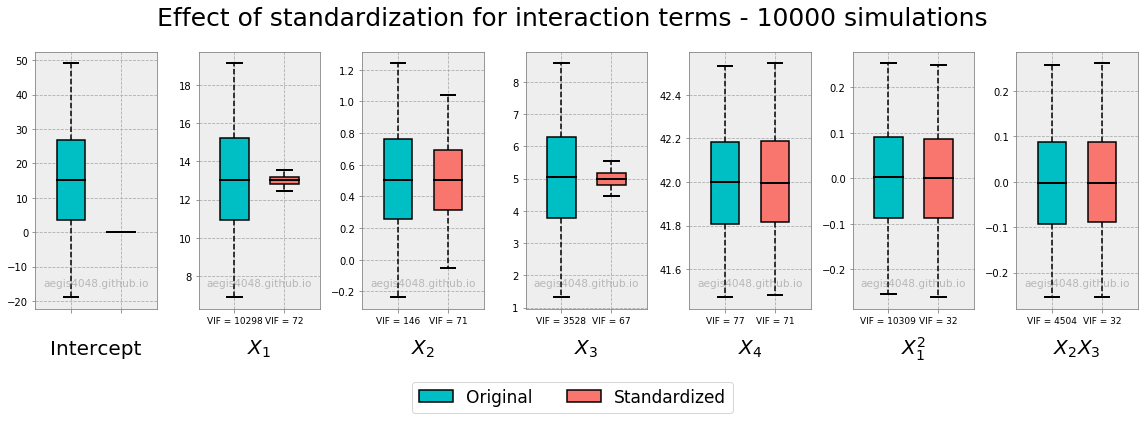

In [19]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]

    return X, y

# settings
m = 10000                                   # number of simulations
correlation = 0.99                          # degree of collinearity (HIGH)

kwargs = {
    'n': 1000,                              # sample size
    'true_coefs': [13, 0.5, 5, 42],         # linear regression coefficients, 2 features
    'true_intercept': 15,                    # y-intercept
    'feature_means': [-12, 14, 2, -20],     # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1                              # standard deviation of gaussian noise
}

# high collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

# simulation
org_params = []
std_params = []
for i in range(m):
    
    ################################################ Original ################################################
    
    # generate high collinearity data
    X_org, y_org = generate_collinear_data(cov, **kwargs)
    
    # add interaction terms
    interaction_org_1 = X_org[:, 0].reshape(-1, 1) ** 2                            # x1^2
    interaction_org_2 = X_org[:, 1].reshape(-1, 1) * X_org[:, 2].reshape(-1, 1)    # x2 * x3
    X_org = np.concatenate([X_org, interaction_org_1, interaction_org_2], axis=1)
    
    # VIF
    vifs_org = np.linalg.inv(pd.DataFrame(X_org).corr().values).diagonal()
    
    # fit linear regression model
    X_st_org = sm.add_constant(X_org)
    model_org = sm.OLS(y_org, X_st_org).fit()
    org_params.append(model_org.params)
    
    ############################################## Standardized ##############################################
    
    # generate high collinearity data
    X_std, y_std = generate_collinear_data(cov, **kwargs)
    
    # standardize
    scaler = StandardScaler(with_std=False)
    X_std, y_std = scaler.fit_transform(X_std), scaler.fit_transform(y_std.reshape(-1, 1)).flatten()
    
    # add interaction terms
    interaction_std_1 = X_std[:, 0].reshape(-1, 1) ** 2                            # x1^2
    interaction_std_2 = X_std[:, 1].reshape(-1, 1) * X_std[:, 2].reshape(-1, 1)    # x2 * x3
    X_std = np.concatenate([X_std, interaction_std_1, interaction_std_2], axis=1)
    
    # VIF
    vifs_std = np.linalg.inv(pd.DataFrame(X_std).corr().values).diagonal()    
    
    # fit linear regression model
    X_st_std = sm.add_constant(X_std)
    model_std = sm.OLS(y_std, X_st_std).fit()
    std_params.append(model_std.params)
    
    ##########################################################################################################

# list to numpy conversion
org_params = np.asarray(org_params)
std_params = np.asarray(std_params)

# plotting
def styling(ax):
    ax.set_facecolor('#eeeeee')
    ax.grid(True, linestyle='--', color='#acacac')
    ax.tick_params(color='grey')
    _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]
    ax.text(0.5, 0.1, 'aegis4048.github.io', fontsize=10.5, ha='center', va='center',
            transform=ax.transAxes, color='grey', alpha=0.5)

boxplot_styling = {
    'sym': '',
    'whis': [2.5, 97.5],
    'showfliers': False,
    'vert': True,
    'capprops': dict(linewidth=2.0, color='k'),
    'medianprops': dict(linewidth=2.0, color='k'),
    'widths': (0.4),
    'patch_artist': True,
    'whiskerprops': dict(linewidth=1.5, color='k', linestyle='--'),
}

labels = ['Intercept', '$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_1^2$', '$X_2X_3$']

fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

for i, (ax, label) in enumerate(zip(axes, labels)):
    bp1 = ax.boxplot(org_params[:, i], positions=[1.0], 
                     boxprops=dict(linewidth=1.5, facecolor='#00bfc4'),
                     **boxplot_styling)
    bp2 = ax.boxplot(std_params[:, i], positions=[1.7], 
                     boxprops=dict(linewidth=1.5, facecolor='#f8766d'),
                     **boxplot_styling)
    styling(ax)
    ax.set_title(label, fontsize=20, y=-0.2)
    if i != 0:
        ax.set_xticklabels(['VIF = {}'.format(int(vifs_org[i - 1])), 
                            'VIF = {}'.format(int(vifs_std[i - 1]))], fontsize=9)
    else:
        ax.set_xticklabels([])

fig.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Original', 'Standardized'], 
           loc='lower center', ncol=3, borderaxespad=0.7, fontsize=17)
fig.suptitle('Effect of standardization for interaction terms - %.f simulations' % m, fontsize=25);
fig.tight_layout(rect=[0, 0.1, 1, 0.9])

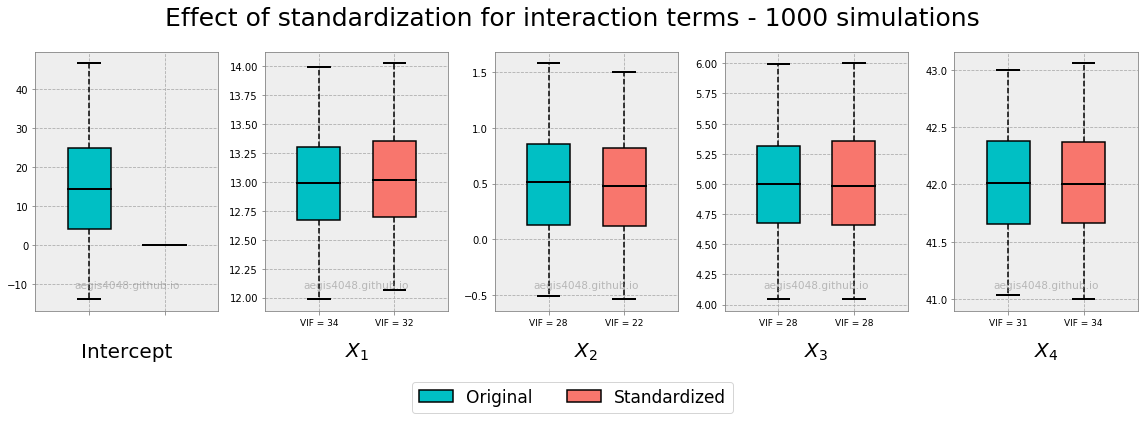

In [9]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]

    return X, y

# settings
m = 1000                                   # number of simulations
correlation = 0.97                          # degree of collinearity (HIGH)

kwargs = {
    'n': 100,                              # sample size
    'true_coefs': [13, 0.5, 5, 42],         # linear regression coefficients, 2 features
    'true_intercept': 15,                    # y-intercept
    'feature_means': [-12, 14, 2, -20],     # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1                              # standard deviation of gaussian noise
}

# high collinearity covariance matrix
cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
np.fill_diagonal(cov, 1)

# simulation
org_params = []
std_params = []
for i in range(m):
    
    ################################################ Original ################################################
    
    # generate high collinearity data
    X_org, y_org = generate_collinear_data(cov, **kwargs)
    
    # VIF
    vifs_org = np.linalg.inv(pd.DataFrame(X_org).corr().values).diagonal()
    
    # fit linear regression model
    X_st_org = sm.add_constant(X_org)
    model_org = sm.OLS(y_org, X_st_org).fit()
    org_params.append(model_org.params)
    
    ############################################## Standardized ##############################################
    
    # generate high collinearity data
    X_std, y_std = generate_collinear_data(cov, **kwargs)
    
    # standardize
    scaler = StandardScaler(with_std=False)
    X_std, y_std = scaler.fit_transform(X_std), scaler.fit_transform(y_std.reshape(-1, 1)).flatten()

    # VIF
    vifs_std = np.linalg.inv(pd.DataFrame(X_std).corr().values).diagonal()    
    
    # fit linear regression model
    X_st_std = sm.add_constant(X_std)
    model_std = sm.OLS(y_std, X_st_std).fit()
    std_params.append(model_std.params)
    
    ##########################################################################################################

# list to numpy conversion
org_params = np.asarray(org_params)
std_params = np.asarray(std_params)

# plotting
def styling(ax):
    ax.set_facecolor('#eeeeee')
    ax.grid(True, linestyle='--', color='#acacac')
    ax.tick_params(color='grey')
    _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]
    ax.text(0.5, 0.1, 'aegis4048.github.io', fontsize=10.5, ha='center', va='center',
            transform=ax.transAxes, color='grey', alpha=0.5)

boxplot_styling = {
    'sym': '',
    'whis': [2.5, 97.5],
    'showfliers': False,
    'vert': True,
    'capprops': dict(linewidth=2.0, color='k'),
    'medianprops': dict(linewidth=2.0, color='k'),
    'widths': (0.4),
    'patch_artist': True,
    'whiskerprops': dict(linewidth=1.5, color='k', linestyle='--'),
}

labels = ['Intercept', '$X_1$', '$X_2$', '$X_3$', '$X_4$']

fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

for i, (ax, label) in enumerate(zip(axes, labels)):
    bp1 = ax.boxplot(org_params[:, i], positions=[1.0], 
                     boxprops=dict(linewidth=1.5, facecolor='#00bfc4'),
                     **boxplot_styling)
    bp2 = ax.boxplot(std_params[:, i], positions=[1.7], 
                     boxprops=dict(linewidth=1.5, facecolor='#f8766d'),
                     **boxplot_styling)
    styling(ax)
    ax.set_title(label, fontsize=20, y=-0.2)
    if i != 0:
        ax.set_xticklabels(['VIF = {}'.format(int(vifs_org[i - 1])), 
                            'VIF = {}'.format(int(vifs_std[i - 1]))], fontsize=9)
    else:
        ax.set_xticklabels([])

fig.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Original', 'Standardized'], 
           loc='lower center', ncol=3, borderaxespad=0.7, fontsize=17)
fig.suptitle('Effect of standardization for interaction terms - %.f simulations' % m, fontsize=25);
fig.tight_layout(rect=[0, 0.1, 1, 0.9])

<div id="Elimination"></div>

### 5.3 Elimination

Elimination means to drop collinear features to remove multicollinearity. However, 

However, this technique requires expertise in each features, or understanding of feature ranking techniques. 

This is a two step process: rank -> detect 

If you have small number of features, try multiple different combinations of features until you get stable coefficient values. 

Removing the predictor with the highest VIF won’t necessarily remove all the multicollinearity, but it is a recommended procedure.



<div id="Principle component regression"></div>

### 5.4 Principle component regression

## Ridge

Ridge regression allows you to analyze data even when severe multicollinearity is present and helps prevent overfitting. This type of model reduces the large, problematic variance that multicollinearity causes by introducing a slight bias in the estimates. The procedure trades away much of the variance in exchange for a little bias, which produces more useful coefficient estimates when multicollinearity is present.

**Bias vs Vairance trade off**

Bias due to elimination vs multicollinearity precision

## Lasso

Lasso regression (least absolute shrinkage and selection operator) performs variable selection that aims to increase prediction accuracy by identifying a simpler model. It is similar to Ridge regression but with variable selection.

### Linearly combine

## Confounding variables

https://statisticsbyjim.com/regression/confounding-variables-bias/

This correlation structure causes confounding variables that are not in the model to bias the estimates that appear in your regression results. For example, removing either X variable will bias the other X variable.

When I fit a regression model with only activity, the model had to attribute both opposing effects to activity alone. Hence, the zero correlation. However, when I fit the model with both activity and weight, it could assign the opposing effects to each variable separately.

**Pythonic Tip:**

In [13]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

features = ['Por']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target]

ols = linear_model.LinearRegression()
model = ols.fit(X, y)
model_pred = model.predict(X)

In [29]:
res = y - model_pred
res = res.values.reshape(-1, 1)

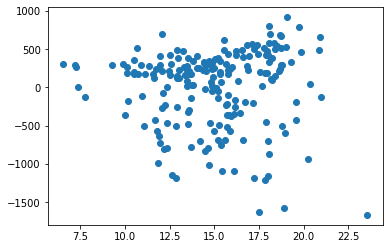

In [16]:
plt.scatter(X, res)

In [44]:
temp = np.concatenate([X, res], axis=1)
df = pd.DataFrame(temp)
df.corr()

,0,1
0,1.000000e+00,1.123793e-15
1,1.123793e-15,1.000000e+00


#### LASSO or Ridge Regression

In [91]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]

    return X, y

# settings
m = 10000                                   # number of simulations
correlation_lo = 0.95                       # degree of collinearity (LOW)

kwargs = {
    'n': 100,                               # sample size
    'true_coefs': [13, 0.5],    # linear regression coefficients, 2 features
    'true_intercept': 2,                    # y-intercept
    'feature_means': [0, 0],       # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1                              # standard deviation of gaussian noise
}

# low collinearity covariance matrix
cov_lo = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation_lo)
np.fill_diagonal(cov_lo, 1)

# simulation
hi_col_params = []
lo_col_params = []

X_lo, y_lo = generate_collinear_data(cov_lo, **kwargs)
df = pd.DataFrame(X_lo, columns=['$X_%s$' % str(i + 1) for i in range(len(kwargs['true_coefs']))])

vifs = np.linalg.inv(df.corr().values).diagonal()

df_vif = pd.DataFrame()
df_vif['Features'] = df.columns
df_vif['VIF'] = vifs
df_vif

,Features,VIF
0,$X_1$,6.907328
1,$X_2$,6.907328


In [92]:
df['$X_1^2$'] = df['$X_1$'].values ** 2
df['$X_1 \cdot X_2$'] = df['$X_1$'].values * df['$X_2$'].values
df['$X_1 \cdot X_2$'] = df['$X_1$'].values * df['$X_2$'].values
df.head()

,$X_1$,$X_2$,$X_1^2$,$X_1 \cdot X_2$
0,-0.116359,0.136477,0.013539,-0.015880
1,-0.221138,-0.222141,0.048902,0.049124
2,0.242903,0.527453,0.059002,0.128120
3,-0.694996,-0.413896,0.483020,0.287656
4,-0.630917,-0.614348,0.398056,0.387603


In [123]:
import pandas as pd
import numpy as np

# data source: https://github.com/GeostatsGuy/GeoDataSets/blob/master/unconv_MV_v5.csv
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
df = pd.read_csv(file)
df = df[features]

vifs = np.linalg.inv(df.corr().values).diagonal()

df_vif = pd.DataFrame()
df_vif['Features'] = df.columns
df_vif['VIF'] = vifs
df_vif

,Features,VIF
0,Por,4.329838
1,Perm,2.862487
2,AI,7.660318
3,Brittle,2.165476
4,TOC,7.365773
5,VR,7.057671


In [131]:
import pandas as pd
import numpy as np

# data source: https://github.com/GeostatsGuy/GeoDataSets/blob/master/unconv_MV_v5.csv
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
df = pd.read_csv(file)
df = df[features]

df['Perm $\cdot$ AI'] = df['Perm'].values * df['AI'].values
df['Por$^2$'] = df['Por'].values ** 2

df = df.iloc[:, 2:]

vifs = np.linalg.inv(df.corr().values).diagonal()

df_vif = pd.DataFrame()
df_vif['Features'] = df.columns
df_vif['VIF'] = vifs
df_vif

,Features,VIF
0,AI,9.211312
1,Brittle,2.135223
2,TOC,7.281669
3,VR,6.784278
4,Perm $\cdot$ AI,2.552091
5,Por$^2$,3.927284


In [96]:
file = 'sample_data/MulticollinearityExample.csv'

df = pd.read_csv(file)[['%Fat', 'Weight kg', 'Activity']]
df['fat * weight'] = df['%Fat'].values * df['Weight kg'].values

vifs = np.linalg.inv(df.corr().values).diagonal()

df_vif = pd.DataFrame()
df_vif['Features'] = df.columns
df_vif['VIF'] = vifs
df_vif

,Features,VIF
0,%Fat,14.931555
1,Weight kg,33.948375
2,Activity,1.053005
3,fat * weight,75.059251


In [17]:
file = 'sample_data/MulticollinearityExample.csv'

df = pd.read_csv(file)[['%Fat', 'Weight kg', 'Activity']]

scaler = StandardScaler(with_std=False)
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df['fat * weight'] = df['%Fat'].values * df['Weight kg'].values

vifs = np.linalg.inv(df.corr().values).diagonal()

df_vif = pd.DataFrame()
df_vif['Features'] = df.columns
df_vif['VIF'] = vifs
df_vif

,Features,VIF
0,%Fat,3.323870
1,Weight kg,4.745648
2,Activity,1.053005
3,fat * weight,1.991063


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# data source: https://github.com/GeostatsGuy/GeoDataSets/blob/master/unconv_MV_v5.csv
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
df = pd.read_csv(file)
df = df[features]

#scaler = StandardScaler(with_std=False)
#df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df['Perm $\cdot$ AI'] = df['Perm'].values * df['AI'].values
#df['Por$^2$'] = df['Por'].values ** 2

vifs = np.linalg.inv(df.corr().values).diagonal()

df_vif = pd.DataFrame()
df_vif['Features'] = df.columns
df_vif['VIF'] = vifs
df_vif

,Features,VIF
0,Por,4.329870
1,Perm,31.111442
2,AI,13.097525
3,Brittle,2.165532
4,TOC,7.401731
5,VR,7.072402
6,Perm $\cdot$ AI,28.679073


In [48]:
df = df.iloc[:, 1:]

In [49]:
df_cor = df.corr()
pd.DataFrame(np.linalg.inv(df.corr().values), index = df_cor.index, columns=df_cor.columns)

,Por,Perm,AI,Brittle,TOC,VR,Prod
Por,16.176635,0.949103,-1.737039,6.897739,-0.963265,2.655457,-17.175719
Perm,0.949103,3.886711,-2.852903,1.072081,-1.333245,2.810110,-5.050239
AI,-1.737039,-2.852903,8.736127,0.781396,6.358676,-7.846188,5.175854
Brittle,6.897739,1.072081,0.781396,5.321840,2.147779,-0.686299,-8.865597
TOC,-0.963265,-1.333245,6.358676,2.147779,7.400963,-6.199942,0.936102
VR,2.655457,2.810110,-7.846188,-0.686299,-6.199942,8.462222,-5.914026
Prod,-17.175719,-5.050239,5.175854,-8.865597,0.936102,-5.914026,24.901696


In [40]:
exogs = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']

data = df[exogs]

vif_dict, tolerance_dict = {}, {}
df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})
    vif_dict[exog] = vif

# create formula for each exogenous variable
for exog in exogs:
    not_exog = [i for i in exogs if i != exog]
    formula = f"{exog} ~ {' + '.join(not_exog)}"

    # extract r-squared from the fit
    r_squared = smf.ols(formula, data=data).fit().rsquared

    # calculate VIF
    vif = 1/(1 - r_squared)
    vif_dict[exog] = vif

    # calculate tolerance
    tolerance = 1 - r_squared
    tolerance_dict[exog] = tolerance

# return VIF DataFrame
df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

df_vif

,VIF,Tolerance
AI,7.660318,0.130543
Brittle,2.165476,0.461792
Perm,2.862487,0.349347
Por,4.329838,0.230956
TOC,7.365773,0.135763
VR,7.057671,0.141690


In [27]:
exogs = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']

data = df[exogs]

vif_dict, tolerance_dict = {}, {}

# form input data for each exogenous variable
for exog in exogs:
    not_exog = [i for i in exogs if i != exog]
    X, y = data[not_exog], data[exog]

    # extract r-squared from the fit
    r_squared = LinearRegression().fit(X, y).score(X, y)

    # calculate VIF
    vif = 1/(1 - r_squared)
    vif_dict[exog] = vif

    # calculate tolerance
    tolerance = 1 - r_squared
    tolerance_dict[exog] = tolerance

# return VIF DataFrame
df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

df_vif

,VIF,Tolerance
AI,7.660318,0.130543
Brittle,2.165476,0.461792
Perm,2.862487,0.349347
Por,4.329838,0.230956
TOC,7.365773,0.135763
VR,7.057671,0.141690


In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
import statsmodels.api as sm

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

features = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']

X = df[features].values.reshape(-1, len(features))

vif = pd.DataFrame()
X = sm.add_constant(X)
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

In [53]:
vif

,Features,VIF
0,Por,161.797377
1,Brittle,4.329838
2,Perm,2.165476
3,TOC,2.862487
4,AI,7.365773
5,VR,7.660318


In [34]:
y = X[:, 0]
X_new = X[:, 1:]

In [35]:
X_new.shape

(200, 5)

In [36]:
from sklearn import linear_model

ols = linear_model.LinearRegression()
model = ols.fit(X_new, y)
model.score(X_new, y)

0.7690444904327748

In [37]:
1 / (1 - model.score(X_new, y)**2)

2.447557580452999

In [66]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

features = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']

df_features = df[features]

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
import numpy as np

In [79]:
df = pd.DataFrame(
    {'a': [1, 1, 2, 3, 4],
     'b': [2, 2, 3, 2, 1],
     'c': [4, 6, 7, 8, 9],
     'd': [4, 3, 4, 5, 4]}
)

In [80]:
X = add_constant(df)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const    136.875
a         22.950
b          3.000
c         12.950
d          3.000
dtype: float64

In [81]:
df_cor = df.corr()
temp = pd.DataFrame(np.linalg.inv(df_cor.values), index = df_cor.index, columns=df_cor.columns)
np.diag(temp)

array([22.95,  3.  , 12.95,  3.  ])

In [68]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

features = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']

df_features = df[features]

In [82]:
X = add_constant(df_features)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const      161.797377
Por          4.329838
Brittle      2.165476
Perm         2.862487
TOC          7.365773
AI           7.660318
VR           7.057671
dtype: float64

In [78]:
k_vars = exog.shape[1]
x_i = exog[:, exog_idx]
mask = np.arange(k_vars) != exog_idx
x_noti = exog[:, mask]
r_squared_i = OLS(x_i, x_noti).fit().rsquared
vif = 1. / (1. - r_squared_i)

AttributeError: 'str' object has no attribute 'shape'

In [84]:
import pandas as pd
import statsmodels.formula.api as smf

def get_vif(exogs, data):
    '''Return VIF (variance inflation factor) DataFrame

    Args:
    exogs (list): list of exogenous/independent variables
    data (DataFrame): the df storing all variables

    Returns:
    VIF and Tolerance DataFrame for each exogenous variable

    Notes:
    Assume we have a list of exogenous variable [X1, X2, X3, X4].
    To calculate the VIF and Tolerance for each variable, we regress
    each of them against other exogenous variables. For instance, the
    regression model for X3 is defined as:
                        X3 ~ X1 + X2 + X4
    And then we extract the R-squared from the model to calculate:
                    VIF = 1 / (1 - R-squared)
                    Tolerance = 1 - R-squared
    The cutoff to detect multicollinearity:
                    VIF > 10 or Tolerance < 0.1
    '''

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # create formula for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        formula = f"{exog} ~ {' + '.join(not_exog)}"

        # extract r-squared from the fit
        r_squared = smf.ols(formula, data=data).fit().rsquared

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

In [96]:
get_vif(['a', 'b', 'c', 'd'], df)

,VIF,Tolerance
a,22.95,0.043573
b,3.00,0.333333
c,12.95,0.077220
d,3.00,0.333333


In [95]:
df = pd.DataFrame(
    {'a': [1, 1, 2, 3, 4],
     'b': [2, 2, 3, 2, 1],
     'c': [4, 6, 7, 8, 9],
     'd': [4, 3, 4, 5, 4]}
)

In [101]:
data = df

not_exog = ['b', 'c', 'd']
exog = 'a'
X, y = data[not_exog], data[exog]

# extract r-squared from the fit
r_squared = LinearRegression().fit(X, y).score(X, y)

# calculate VIF
vif = 1/(1 - r_squared)

vif

22.949999999999985


1. Introduction
    - Nfoi + Gfgi example, standard error is important (possibly estimating OOIP + OGIP after PCA treament?)
    - Note that this multicollinearity does not degrade the prediction power of a model
            
2. Key Takeaways
    - Multicollinearity occurs when (can be described by ...)
    - Multicollinearity makes the values of individual regression coefficients are unreliable
        * It can cause change in the signs as well as in the magnitudes from one sample to another sample. If you concluded that feature x1 has a positive impact on a response variable y because the regression coefficient of x1 is positive, this might be wrong. I show this here and here. 
    - Multicollinearity does not affect the prediction power on a response variable (bundle)
    - Use VIF to detect and remove collinear features (if VIF > 10, its problematic)
    - Sometimes multicollinearity can be safely ignored (https://statisticalhorizons.com/multicollinearity)
    - Multicollinearity among independent variables will result in less reliable statistical inferences.
    
3. Concept
    - Thought experiment
    
4. Causes
    - Generally occurs when features are highly correlated
    - Incorrect dummy variable encoding
    - Repetition of the same feature (different units)
    - A feature computed from other features is in the data set.
    
5. Effects    
    - (This makes interpretation unreliable)
    - Model Instability with sampling
        * Python simulation, 2D plot
    - Model instability with feature selection
        * Same screenshot used in previous post
    - Overestimated standard errors
        * 95% conf int Box plots for each regression coefficients, paired with sampling vs regression analysis
    - Notes: Value of regression coefficient is not feature importance
    - (Perhaps significance test)

6. Detection
    - Correlation matrix
    - VIF score
        * A Caution Regarding Rules of Thumb for Variance Inflation Factors
        * https://link.springer.com/article/10.1007/s11135-006-9018-6
    
7. Remedies
    - Removal (VIF score + correlation matrix) (If that features is necessary, tough luck)
    - Principle Component Regression
        * PCA is generally used when the aim is to retrieve a latent unmeasured variable or set of variables proxied by measured manifestation variables: for example, economic openness is not directly measured but there are indicators for it such as trade volume, trade tariffs, exchange policy, etc. So pca is implemented in order to assess a synthetic variable for the Economic openness. You will have to find a “meaning” for your principal components based on the coordinates of the original variables relative to each component
        * Warning: Interpretation of principle components. Do it only if you really understand what PCA does. 
    - Mean centering
        * Do not standardize, by Jim
        * Notes: STD dividing for non-normal distributions
        * https://statisticsbyjim.com/regression/standardize-variables-regression/
        
8. Excuses to ignore multicollinearity (or Pitfalls)

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm

In [122]:
features = ['a1', 'a2']
true_coefs = [2, 4]
true_intercept = 1
n = 100

In [182]:
correlation = 0

cov = [[1, correlation], 
       [correlation, 1]]

model_coefs_low = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4], cov=cov, size=n)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=1, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_low.append(model.coef_)
    
model_coefs_low = np.array(model_coefs_low)

In [184]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

features = ['a1', 'a2']

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,3.893106
1,a2,3.893106


In [185]:
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     851.7
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.97e-62
Time:                        21:12:33   Log-Likelihood:                -140.88
No. Observations:                 100   AIC:                             287.8
Df Residuals:                      97   BIC:                             295.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3984      0.488      2.868      0.0

In [168]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

features = ['a1', 'a2']

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,18.710929
1,a2,18.710929


In [169]:
correlation = 0.99

# construct 2D positive-semidefinite covariance matrix
cov = [[1, correlation], 
       [correlation, 1]]

model_coefs_high = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4], cov=cov, size=n)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=1, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_high.append(model.coef_)
    
model_coefs_high = np.array(model_coefs_high)

In [170]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,28.032218
1,a2,28.032218


In [171]:
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1207.
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.96e-69
Time:                        21:11:33   Log-Likelihood:                -143.14
No. Observations:                 100   AIC:                             292.3
Df Residuals:                      97   BIC:                             300.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9978      1.587      1.259      0.2

Text(0, 0.5, 'a2')

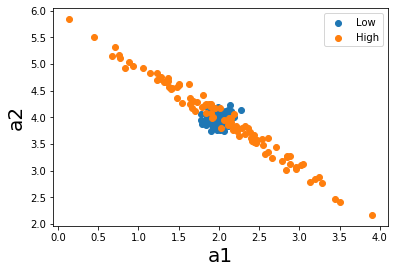

In [172]:
fig, ax = plt.subplots()

ax.scatter(model_coefs_low[:, 0], model_coefs_low[:, 1], label='Low')
ax.scatter(model_coefs_high[:, 0], model_coefs_high[:, 1], label='High')
ax.legend()
ax.set_xlabel('a1', fontsize=20)
ax.set_ylabel('a2', fontsize=20)

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Original

In [92]:
features = ['a1', 'a2']
true_coefs = [10, 15]
true_intercept = 2
n = 100

In [121]:
correlation = 0.99

# construct 2D positive-semidefinite covariance matrix
cov = [[1, correlation], 
       [correlation, 1]]

model_coefs_orig = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4], cov=cov, size=n)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=1, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_orig.append(model.coef_)
    
model_coefs_orig = np.array(model_coefs_orig)

In [122]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,19.583652
1,a2,19.583652


In [123]:
X_st = sm.add_constant(X)
sm_model = sm.OLS(y, X_st).fit()
predictions = sm_model.predict(X_st)
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.036e+04
Date:                Fri, 29 Nov 2019   Prob (F-statistic):          2.17e-136
Time:                        21:58:41   Log-Likelihood:                -139.20
No. Observations:                 100   AIC:                             284.4
Df Residuals:                      97   BIC:                             292.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9605      1.506      1.966      0.0

In [124]:
print('a1 = [%.2f' % np.percentile(model_coefs_orig[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_orig[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 1], 97.5))

a1 = [8.86  11.52]
a2 = [13.52  16.08]


# PCA

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [126]:
features = ['a1', 'a2']
true_coefs = [10, 15]
true_intercept = 2
n = 100

In [127]:
correlation = 0.95

# construct 2D positive-semidefinite covariance matrix
cov = [[1, correlation], 
       [correlation, 1]]

model_coefs_pca = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4], cov=cov, size=n)
    
    scalar = StandardScaler()
    X = scalar.fit_transform(X)

    # PCA
    pca = PCA(n_components=len(features))
    X = pca.fit_transform(X)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=1, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_pca.append(model.coef_)
    
model_coefs_pca = np.array(model_coefs_pca)

In [128]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,1.0
1,a2,1.0


In [129]:
X_st = sm.add_constant(X)
sm_model = sm.OLS(y, X_st).fit()
predictions = sm_model.predict(X_st)
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     8396.
Date:                Fri, 29 Nov 2019   Prob (F-statistic):          2.09e-109
Time:                        21:58:47   Log-Likelihood:                -150.29
No. Observations:                 100   AIC:                             306.6
Df Residuals:                      97   BIC:                             314.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0979      0.110     18.999      0.0

In [130]:
print('a1 = [%.2f' % np.percentile(model_coefs_pca[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_pca[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 1], 97.5))

a1 = [9.84  10.13]
a2 = [14.01  15.98]


# Centering

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [132]:
features = ['a1', 'a2']
true_coefs = [10, 15]
true_intercept = 2
n = 100

In [133]:
correlation = 0.95

# construct 2D positive-semidefinite covariance matrix
cov = [[1, correlation], 
       [correlation, 1]]

model_coefs_center = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4], cov=cov, size=n)
    
    scalar = StandardScaler(with_std=False)
    X = scalar.fit_transform(X)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=1, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_center.append(model.coef_)
    
model_coefs_center = np.array(model_coefs_center)

In [134]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,11.76716
1,a2,11.76716


In [135]:
X_st = sm.add_constant(X)
sm_model = sm.OLS(y, X_st).fit()
predictions = sm_model.predict(X_st)
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.898e+04
Date:                Fri, 29 Nov 2019   Prob (F-statistic):          1.20e-141
Time:                        21:59:00   Log-Likelihood:                -134.28
No. Observations:                 100   AIC:                             274.6
Df Residuals:                      97   BIC:                             282.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1242      0.094     22.575      0.0

In [137]:
print('a1 = [%.2f' % np.percentile(model_coefs_center[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_center[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 1], 97.5))

a1 = [9.37  10.76]
a2 = [14.29  15.65]


Text(0, 0.5, 'a2')

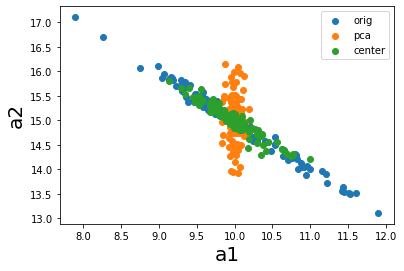

In [136]:
fig, ax = plt.subplots()

ax.scatter(model_coefs_orig[:, 0], model_coefs_orig[:, 1], label='orig')
ax.scatter(model_coefs_pca[:, 0], model_coefs_pca[:, 1], label='pca')
ax.scatter(model_coefs_center[:, 0], model_coefs_center[:, 1], label='center')
ax.legend()
ax.set_xlabel('a1', fontsize=20)
ax.set_ylabel('a2', fontsize=20)

# 3 features

# original

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [152]:
features = ['a1', 'a2', 'a3']
true_coefs = [2, 4, 10]
true_intercept = 2
n = 100

In [159]:
# construct 2D positive-semidefinite covariance matrix
cov = [[1, 0.95, 0.93], 
       [0.95, 1, 0.95],
       [0.93, 0.95, 1]]

model_coefs_orig = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4, 10], cov=cov, size=n)

    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=2, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + true_coefs[2] * X[:, 2] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_orig.append(model.coef_)
    
model_coefs_orig = np.array(model_coefs_orig)

In [160]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,41.566893
1,a2,246.401621
2,a3,113.336348


In [161]:
X_st = sm.add_constant(X)
sm_model = sm.OLS(y, X_st).fit()
predictions = sm_model.predict(X_st)
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1298.
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.54e-77
Time:                        22:03:37   Log-Likelihood:                -214.78
No. Observations:                 100   AIC:                             437.6
Df Residuals:                      96   BIC:                             448.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2692      4.590      0.712      0.4

In [162]:
print('a1 = [%.2f' % np.percentile(model_coefs_orig[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_orig[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 1], 97.5))
print('a3 = [%.2f' % np.percentile(model_coefs_orig[:, 2], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 2], 97.5))

a1 = [0.80  3.09]
a2 = [2.95  5.45]
a3 = [8.42  11.17]


# PCA

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [171]:
features = ['a1', 'a2', 'a3']
true_coefs = [2, 4, 10]
true_intercept = 2
n = 100

In [174]:
# construct 2D positive-semidefinite covariance matrix
cov = [[1, 0.95, 0.93], 
       [0.95, 1, 0.95],
       [0.93, 0.95, 1]]

model_coefs_pca = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4, 10], cov=cov, size=n)

    scalar = StandardScaler()
    X = scalar.fit_transform(X)

    # PCA
    pca = PCA(n_components=len(features))
    X = pca.fit_transform(X)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=2, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + true_coefs[2] * X[:, 2] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_pca.append(model.coef_)
    
model_coefs_pca = np.array(model_coefs_pca)

In [175]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,1.0
1,a2,1.0
2,a3,1.0


In [176]:
X_st = sm.add_constant(X)
sm_model = sm.OLS(y, X_st).fit()
predictions = sm_model.predict(X_st)
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     172.9
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.43e-38
Time:                        22:07:19   Log-Likelihood:                -206.91
No. Observations:                 100   AIC:                             421.8
Df Residuals:                      96   BIC:                             432.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6930      0.196      8.658      0.0

In [177]:
print('a1 = [%.2f' % np.percentile(model_coefs_pca[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_pca[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 1], 97.5))
print('a3 = [%.2f' % np.percentile(model_coefs_pca[:, 2], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 2], 97.5))

a1 = [1.82  2.24]
a2 = [2.64  5.85]
a3 = [8.33  11.93]


# Centering

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [143]:
features = ['a1', 'a2', 'a3']
true_coefs = [2, 4, 10]
true_intercept = 2
n = 100

In [164]:
# construct 2D positive-semidefinite covariance matrix
cov = [[1, 0.95, 0.93], 
       [0.95, 1, 0.95],
       [0.93, 0.95, 1]]

model_coefs_center = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4, 10], cov=cov, size=n)
    
    scalar = StandardScaler(with_std=False)
    X = scalar.fit_transform(X)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=2, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + true_coefs[2] * X[:, 2] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_center.append(model.coef_)
    
model_coefs_center = np.array(model_coefs_center)

In [145]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,11.866335
1,a2,17.993888
2,a3,11.526422


In [146]:
X_st = sm.add_constant(X)
sm_model = sm.OLS(y, X_st).fit()
predictions = sm_model.predict(X_st)
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2215.
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.82e-88
Time:                        22:00:06   Log-Likelihood:                -203.14
No. Observations:                 100   AIC:                             414.3
Df Residuals:                      96   BIC:                             424.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2459      0.188     11.927      0.0

In [168]:
print('a1 = [%.2f' % np.percentile(model_coefs_center[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_center[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 1], 97.5))
print('a3 = [%.2f' % np.percentile(model_coefs_center[:, 2], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 2], 97.5))

a1 = [0.76  3.29]
a2 = [2.49  5.35]
a3 = [8.65  11.24]


In [180]:
print('Original')
print('a1 = [%.2f' % np.percentile(model_coefs_orig[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_orig[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 1], 97.5))
print('a3 = [%.2f' % np.percentile(model_coefs_orig[:, 2], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 2], 97.5))
print('\nPCA')
print('a1 = [%.2f' % np.percentile(model_coefs_pca[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_pca[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 1], 97.5))
print('a3 = [%.2f' % np.percentile(model_coefs_pca[:, 2], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 2], 97.5))
print('\nCenter')
print('a1 = [%.2f' % np.percentile(model_coefs_center[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_center[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 1], 97.5))
print('a3 = [%.2f' % np.percentile(model_coefs_center[:, 2], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 2], 97.5))

Original
a1 = [0.80  3.09]
a2 = [2.95  5.45]
a3 = [8.42  11.17]

PCA
a1 = [1.82  2.24]
a2 = [2.64  5.85]
a3 = [8.33  11.93]

Center
a1 = [0.76  3.29]
a2 = [2.49  5.35]
a3 = [8.65  11.24]


In [ ]:
true_coefs = [2, 4, 10]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2252.
Date:                Wed, 27 Nov 2019   Prob (F-statistic):           9.23e-31
Time:                        19:04:04   Log-Likelihood:                -362.09
No. Observations:                  29   AIC:                             728.2
Df Residuals:                      27   BIC:                             730.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          9.023e+07   8.73e+06     10.340      0.0

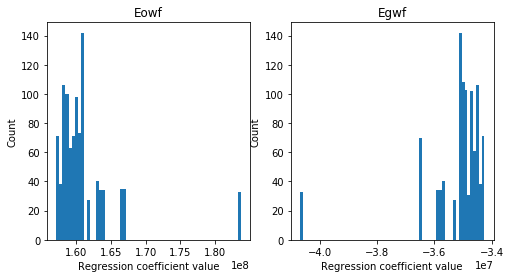

In [20]:
file = 'sample_data/ooip_ogip.csv'
df = pd.read_csv(file)

features = ['Eowf', 'Egwf']
target = 'F'

# preprocessing required by sklearn
X = df[features].values.reshape(-1, len(features))
y = df[target].values

# Compute VIF
vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

# statsmodel
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())

print('\n\n\n\n')
print(vif)

coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.95)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')

<class 'numpy.ndarray'>
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     2.992
Date:                Fri, 29 Nov 2019   Prob (F-statistic):             0.0671
Time:                        21:09:39   Log-Likelihood:                -433.47
No. Observations:                  29   AIC:                             870.9
Df Residuals:                      27   BIC:                             873.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.412e+05   1.02

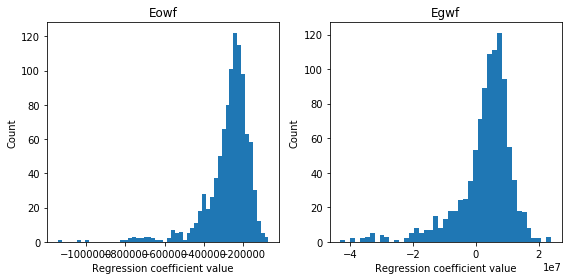

In [163]:
file = 'sample_data/ooip_ogip.csv'
df = pd.read_csv(file)

features = ['Eowf', 'Egwf']
target = 'F'

# Standardization
scalar = StandardScaler()
X = scalar.fit_transform(df[features])

# PCA
pca = PCA(n_components=len(features))
X = pca.fit_transform(X)

print(type(X))

# Reconstruct df with transformed features
df_trans = pd.DataFrame(X)
df_trans[target] = df[target]
df_trans.columns = features + [target]

# preprocessing required by sklearn
X = df_trans[features].values.reshape(-1, len(features))
y = df_trans[target].values

# statsmodel
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

print(vif)

coefs = []
for i in range(1000):
    
    # randomly sample 70% of the original data. This is essentially bootstrapping
    df_temp = df_trans.sample(frac=0.7)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression(fit_intercept=False)
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')
    
fig.tight_layout()

In [17]:
sm_model.params

array([ 3844830.39400844, -3503719.21148126])

In [18]:
pca_inverse = pca.inverse_transform(sm_model.params)
pca_inverse

array([-5196209.2579275 ,  -241202.03030353])

In [19]:
pca_inverse = pca.inverse_transform(sm_model.params)

scalar.inverse_transform(pca_inverse)

array([-124291.81061746,  -24081.35939605])

In [6]:
coefs

array([[  -251725.52996658,   6784667.67113444],
       [  -659868.94590499, -11829722.22955466],
       [  -191775.09498549,  -1408872.44269721],
       ...,
       [  -298643.41037758,   3678384.98523384],
       [  -264200.68853622,   2165056.06443315],
       [  -201849.14634761,   4924510.92333155]])

In [6]:
file = 'sample_data/ooip_ogip.csv'
df = pd.read_csv(file)

features = ['Eowf', 'Egwf']
target = 'F'

In [9]:
X = df[features].values.reshape(-1, len(features))
y = df[target].values

ols = linear_model.LinearRegression(fit_intercept=False)
model = ols.fit(X, y)

print(model.score(X, y))
print(model.coef_)

0.9734009040213185
[ 89137384.70067914 -18363222.42705864]


In [10]:
# statsmodel
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     798.1
Date:                Wed, 27 Nov 2019   Prob (F-statistic):           1.14e-28
Time:                        17:31:02   Log-Likelihood:                -442.12
No. Observations:                  36   AIC:                             890.2
Df Residuals:                      33   BIC:                             895.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.183e+05   3.68e+04      3.215      0.0

multicollinearity is a problem with Mahalanobis distance. 

https://python-data-science.readthedocs.io/en/latest/unsupervised.html
While powerful, its use of correlation can be detrimantal when there is multicollinearity (strong correlations among features).

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     768.8
Date:                Wed, 27 Nov 2019   Prob (F-statistic):          8.13e-132
Time:                        04:57:10   Log-Likelihood:                -1341.7
No. Observations:                 200   AIC:                             2697.
Df Residuals:                     193   BIC:                             2721.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1230.2620    181.565     -6.776      0.0

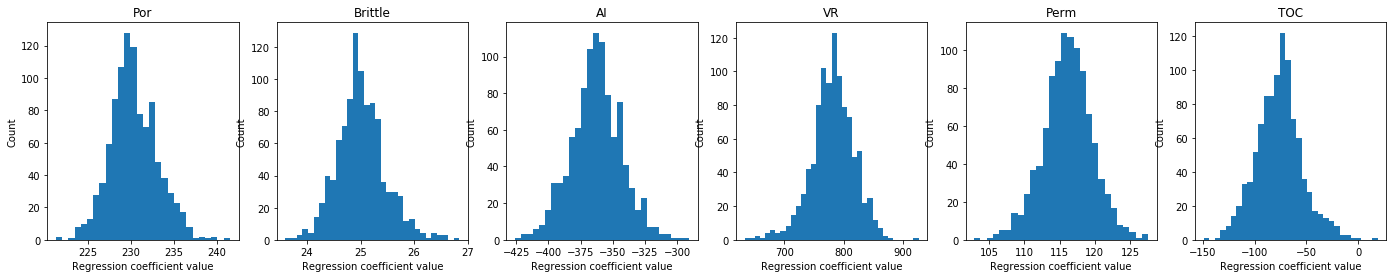

In [23]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

# preprocessing required by sklearn
X = df[features].values.reshape(-1, len(features))
y = df[target].values

# Compute VIF
vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

# statsmodel
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

print('\n\n\n\n')
print(vif)

coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.95)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     768.8
Date:                Wed, 27 Nov 2019   Prob (F-statistic):          8.13e-132
Time:                        04:57:23   Log-Likelihood:                -1341.7
No. Observations:                 200   AIC:                             2697.
Df Residuals:                     193   BIC:                             2721.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1230.2620    181.565     -6.776      0.0

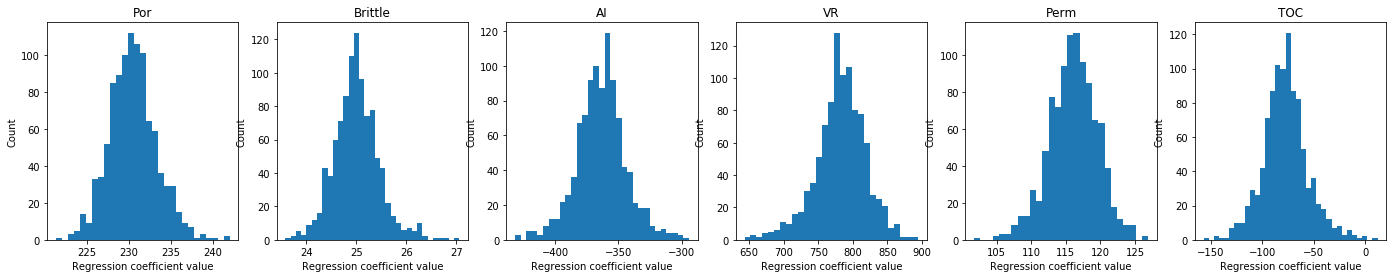

In [24]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

# preprocessing required by sklearn
X = df[features].values.reshape(-1, len(features))
y = df[target].values

# statsmodel
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

# Compute VIF
vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

print('\n\n\n\n')
print(vif)

coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.95)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Raw

In [3]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,7.363348
1,Brittle,7.363348


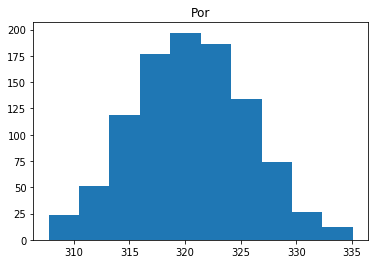

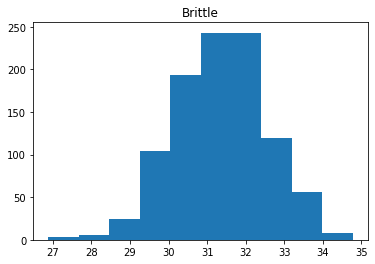

In [3]:
coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.7)
    
    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

for i, feature in enumerate(features):
    fig, ax = plt.subplots()
    ax.hist(coefs[:, i])
    ax.set_title(feature)

In [11]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,225.857649
1,Brittle,39.077458
2,AI,208.845031
3,VR,362.619204
4,Perm,27.982176
5,TOC,35.538260
6,Prod,401.944335


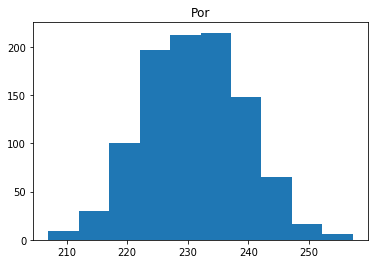

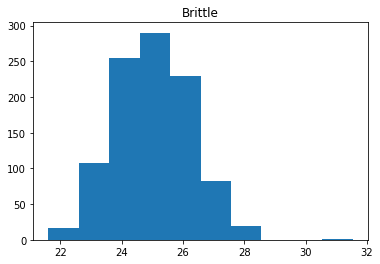

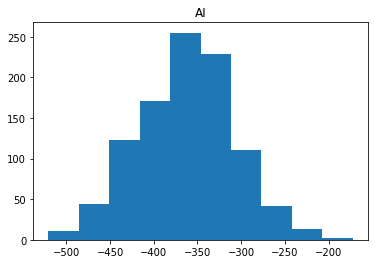

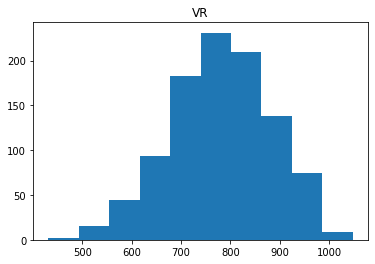

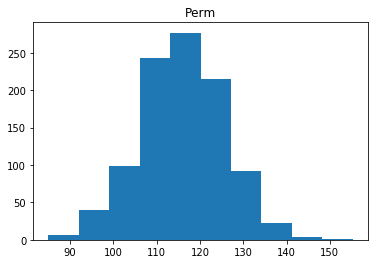

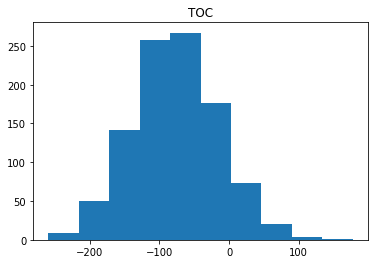

In [5]:
coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.7)
    
    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

for i, feature in enumerate(features):
    fig, ax = plt.subplots()
    ax.hist(coefs[:, i])
    ax.set_title(feature)

# Centered

In [55]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle']
target = 'Prod'

scalar = StandardScaler(with_std=False)
X = scalar.fit_transform(df[features])

X = X.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,1.05017
1,Brittle,1.05017


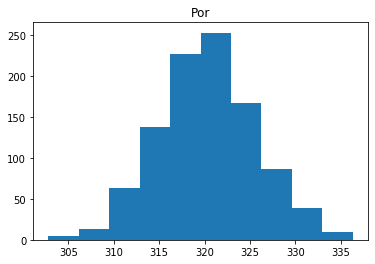

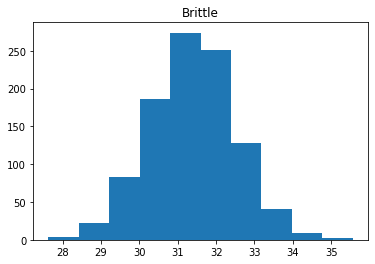

In [56]:
coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.7)
    
    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

for i, feature in enumerate(features):
    fig, ax = plt.subplots()
    ax.hist(coefs[:, i])
    ax.set_title(feature)

In [57]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

scalar = StandardScaler(with_std=False)
X = scalar.fit_transform(df[features])

X = X.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,4.329838
1,Brittle,2.165476
2,AI,7.660318
3,VR,7.057671
4,Perm,2.862487
5,TOC,7.365773


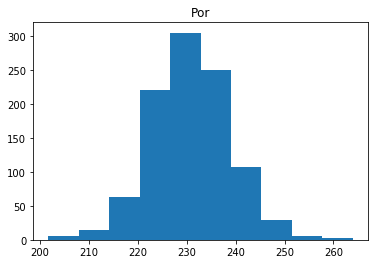

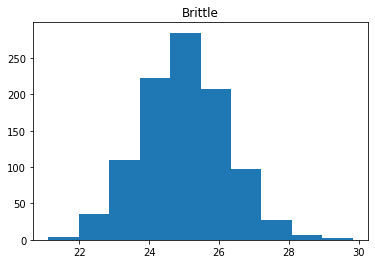

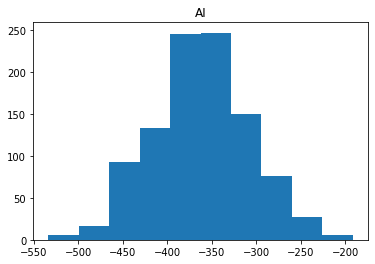

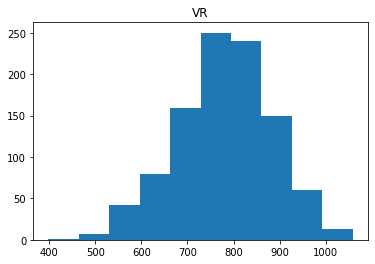

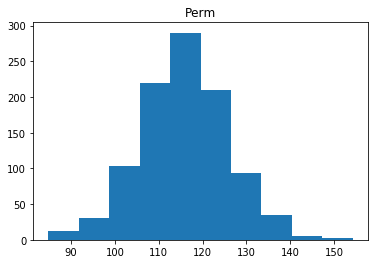

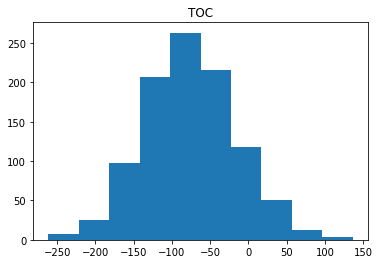

In [58]:
coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.7)
    
    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

for i, feature in enumerate(features):
    fig, ax = plt.subplots()
    ax.hist(coefs[:, i])
    ax.set_title(feature)

# PCA

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     768.8
Date:                Wed, 27 Nov 2019   Prob (F-statistic):          8.13e-132
Time:                        04:57:36   Log-Likelihood:                -1341.7
No. Observations:                 200   AIC:                             2697.
Df Residuals:                     193   BIC:                             2721.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4311.2199     14.274    302.032      0.0

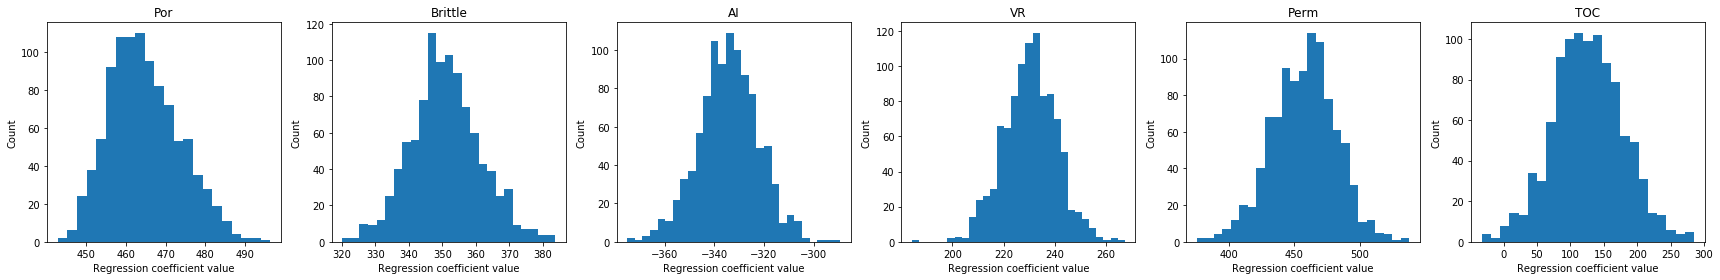

In [25]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

# Standardization
scalar = StandardScaler()
X = scalar.fit_transform(df[features])

# PCA
pca = PCA(n_components=len(features))
X = pca.fit_transform(X)

# Reconstruct df with transformed features
df_trans = pd.DataFrame(X)
df_trans[target] = df[target]
df_trans.columns = features + [target]

# preprocessing required by sklearn
X = df_trans[features].values.reshape(-1, len(features))
y = df_trans[target].values

# statsmodel
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

print(vif)

coefs = []
for i in range(1000):
    
    # randomly sample 70% of the original data. This is essentially bootstrapping
    df_temp = df_trans.sample(frac=0.7)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')
    
fig.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     766.9
Date:                Wed, 27 Nov 2019   Prob (F-statistic):          4.69e-118
Time:                        04:57:42   Log-Likelihood:                -1381.5
No. Observations:                 200   AIC:                             2773.
Df Residuals:                     195   BIC:                             2790.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4311.2199     17.324    248.857      0.0

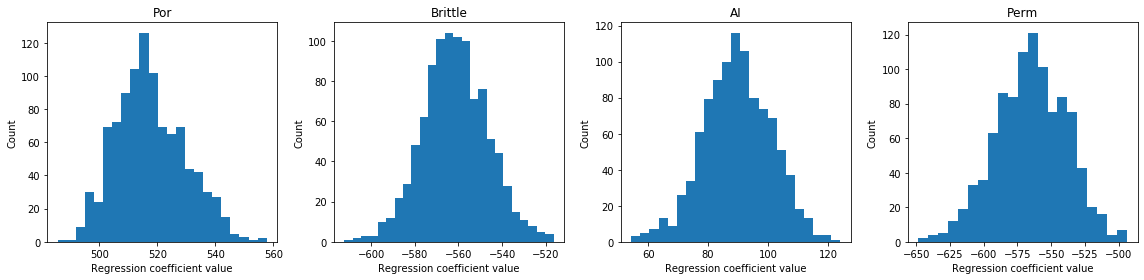

In [26]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'Perm']
target = 'Prod'

# Standardization
scalar = StandardScaler()
X = scalar.fit_transform(df[features])

# PCA
pca = PCA(n_components=len(features))
X = pca.fit_transform(X)

# Reconstruct df with transformed features
df_trans = pd.DataFrame(X)
df_trans[target] = df[target]
df_trans.columns = features + [target]

# preprocessing required by sklearn
X = df_trans[features].values.reshape(-1, len(features))
y = df_trans[target].values

# statsmodel
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

print(vif)

coefs = []
for i in range(1000):
    df_temp = df_trans.sample(frac=0.7)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')
    
fig.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1373.
Date:                Wed, 27 Nov 2019   Prob (F-statistic):          2.14e-116
Time:                        04:57:46   Log-Likelihood:                -1392.8
No. Observations:                 200   AIC:                             2792.
Df Residuals:                     197   BIC:                             2802.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4311.2199     18.241    236.347      0.0

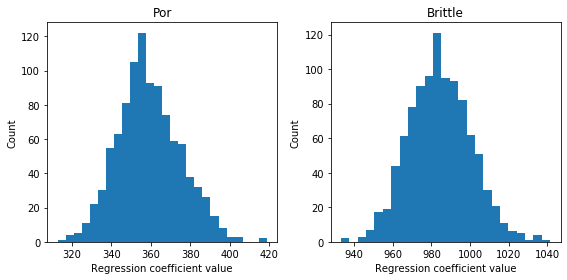

In [27]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle']
target = 'Prod'

# Standardization
scalar = StandardScaler()
X = scalar.fit_transform(df[features])

# PCA
pca = PCA(n_components=len(features))
X = pca.fit_transform(X)

# Reconstruct df with transformed features
df_trans = pd.DataFrame(X)
df_trans[target] = df[target]
df_trans.columns = features + [target]

# preprocessing required by sklearn
X = df_trans[features].values.reshape(-1, len(features))
y = df_trans[target].values

# statsmodel
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

print(vif)

coefs = []
for i in range(1000):
    df_temp = df_trans.sample(frac=0.7)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')
    
fig.tight_layout()

In [4]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'Perm', 'AI']
target = 'Prod'

scalar = StandardScaler()
X = scalar.fit_transform(df[features])

pca = PCA(n_components=len(features))
X = pca.fit_transform(X)

X = X.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,1.0
1,Brittle,1.0
2,Perm,1.0
3,AI,1.0


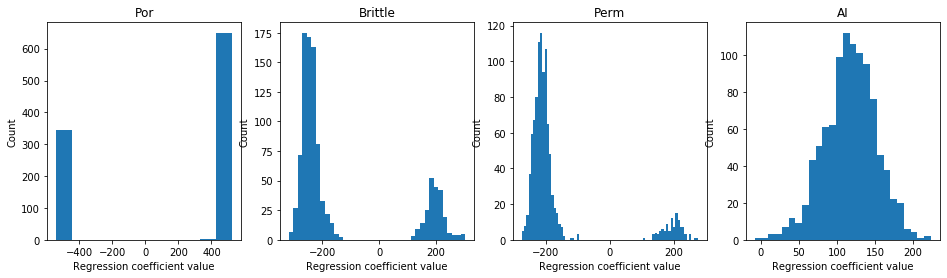

In [5]:
coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.7)
    
    scalar = StandardScaler()
    X = scalar.fit_transform(df_temp.values)

    pca = PCA(n_components=len(features))
    X = pca.fit_transform(X)

    X = X.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')

In [6]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

scalar = StandardScaler()
X = scalar.fit_transform(df.values)

pca = PCA(n_components=len(features))
X = pca.fit_transform(X)

X = X.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,1.0
1,Brittle,1.0
2,AI,1.0
3,VR,1.0
4,Perm,1.0
5,TOC,1.0


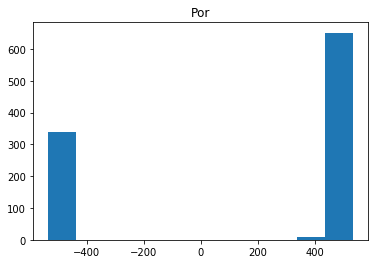

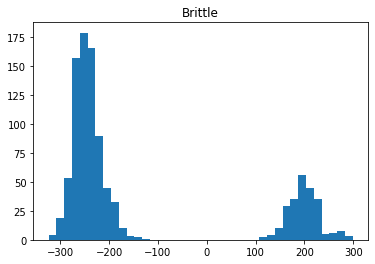

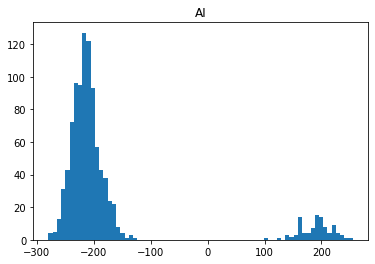

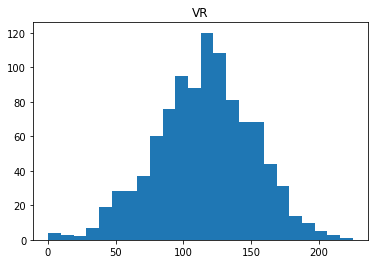

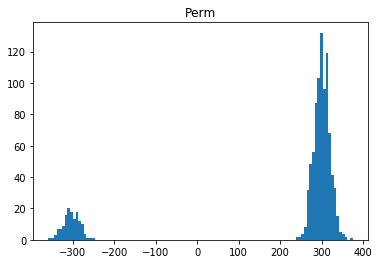

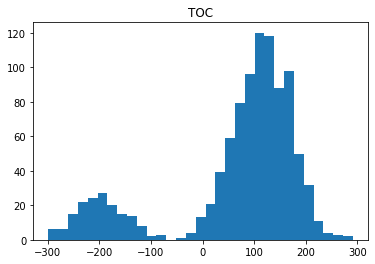

In [7]:
coefs = []
r = []
for i in range(1000):
    df_temp = df.sample(frac=0.7)
    
    scalar = StandardScaler()
    X = scalar.fit_transform(df_temp.values)

    pca = PCA(n_components=len(features))
    X = pca.fit_transform(X)

    X = X.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
    r.append(model.score(X, y))
    
coefs = np.array(coefs)

for i, feature in enumerate(features):
    fig, ax = plt.subplots()
    ax.hist(coefs[:, i], bins='auto')
    ax.set_title(feature)

In [9]:
coefs[:, -1]

array([-214.5982385 ,  123.74342539,   70.77110659,   56.87212411,
         56.53388293,  164.46445716,  131.33881182,   55.34281759,
        166.52876831,   58.30200155,  129.30784068,  110.76253426,
         -8.5205867 ,   75.96285387,  162.9913495 ,  134.23211329,
         86.28961524,  258.79667236,   41.25975719,  174.58824505,
        165.76815614,  192.83252518,  162.09912498,  181.0609212 ,
        133.6041303 ,   91.74225786,  162.3437963 ,  134.25806308,
        167.63417848, -243.73087435,  151.58283645, -182.96664201,
        -73.94919992, -143.68758187,  211.68019925,  141.48369222,
       -252.84766516,  238.54549752,  170.26866752,  103.30889493,
       -216.32541621,   97.50450336,   62.22314081,  122.47958225,
       -182.42362655,  120.40220087,   82.49752192,  105.8806393 ,
         78.66881573,   88.34884903,  126.40364343,    7.58734101,
        118.10461083,  141.16959885, -241.62083627,  -12.79692893,
        105.66806216,   67.33793977, -182.7729212 , -185.66768

In [59]:
    df_temp = df.sample(frac=0.7)
    
    scalar = StandardScaler()
    X = scalar.fit_transform(df_temp.values)

    pca = PCA(n_components=len(features))
    X = pca.fit_transform(X)

In [61]:
pca.explained_variance_

array([3.36520575, 1.6300189 , 1.05796411, 0.75059836, 0.17773085,
       0.04717506])

In [62]:
features

['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']

In [70]:
import statsmodels.api as sm

res = sm.OLS(y, X).fit()

ImportError: cannot import name 'factorial'

In [28]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

########################################################################################

features = ['Por', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

pca = PCA(n_components=len(features))
X_new = pca.fit_transform(X)

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X_new, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,1.0
1,AI,1.0
2,VR,1.0
3,Perm,1.0
4,TOC,1.0


In [29]:
ols = linear_model.LinearRegression()
model = ols.fit(X_new, y)

print('Features                :  %s' % features)
print('Regression Coefficients : ', model.coef_)
print('R-squared               :  %.2f' % model.score(X_new, y))
print('Y-intercept             :  %.2f' % model.intercept_)
print('')

Features                :  ['Por', 'AI', 'VR', 'Perm', 'TOC']
Regression Coefficients :  [  260.59912732   -18.97712619    90.43637731  -404.33137156
 -2682.99310784]
R-squared               :  0.90
Y-intercept             :  4311.22



In [18]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

scalar = StandardScaler(with_std=False)
X_new = scalar.fit_transform(df.values)

df = pd.DataFrame(X_new, columns=df.columns)

########################################################################################

features = ['Por', 'Brittle', 'AI']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,1.313968
1,Brittle,1.051171
2,AI,1.271905


In [19]:
ols = linear_model.LinearRegression()
model = ols.fit(X, y)

print('Features                :  %s' % features)
print('Regression Coefficients : ', model.coef_)
print('R-squared               :  %.2f' % model.score(X, y))
print('Y-intercept             :  %.2f' % model.intercept_)
print('')

Features                :  ['Por', 'Brittle', 'AI']
Regression Coefficients :  [319.43449102  31.38905371 -11.04275682]
R-squared               :  0.93
Y-intercept             :  -0.00



In [37]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

########################################################################################

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,62.645242
1,Brittle,19.370696
2,AI,122.734765
3,VR,259.597778
4,Perm,16.887354
5,TOC,33.668133


In [25]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

file = '500_Person_Gender_Height_Weight_Index.csv'
df = pd.read_csv(file)[['Height', 'Weight', 'Index']]

vif = pd.DataFrame()
vif['Features'] = df.columns
vif['VIF'] = np.array([variance_inflation_factor(df.values, i) for i in range(df.shape[1])])

In [26]:
vif

,Features,VIF
0,Height,11.213321
1,Weight,37.566315
2,Index,20.881544


In [64]:
features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']

In [68]:
features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)[features]

vif = pd.DataFrame()
vif['Features'] = df.columns
vif['VIF'] = np.array([variance_inflation_factor(df.values, i) for i in range(df.shape[1])])

In [69]:
vif

,Features,VIF
0,Por,42.751102
1,Brittle,8.576566
2,Perm,15.590663
3,TOC,10.075020


In [59]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

########################################################################################

features = ['Por', 'Brittle']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

ols = linear_model.LinearRegression()
model = ols.fit(X, y)

print('Features                :  %s' % features)
print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
print('R-squared               :  %.2f' % model.score(X, y))
print('Y-intercept             :  %.2f' % model.intercept_)
print('')

Features                :  ['Por', 'Brittle']
Regression Coefficients :  [320.39, 31.38]
R-squared               :  0.93
Y-intercept             :  -2003.01



In [62]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)
df = df.iloc[:, 1:-1]

vif = pd.DataFrame()
vif['Features'] = df.columns
vif['VIF'] = np.array([variance_inflation_factor(df.values, i) for i in range(df.shape[1])])
vif

,Features,VIF
0,Por,62.645242
1,Perm,16.887354
2,AI,122.734765
3,Brittle,19.370696
4,TOC,33.668133
5,VR,259.597778


Multicollinearity can affect any regression model with more than one predictor. It occurs when two or more predictor variables overlap so much in what they measure that their effects are indistinguishable.

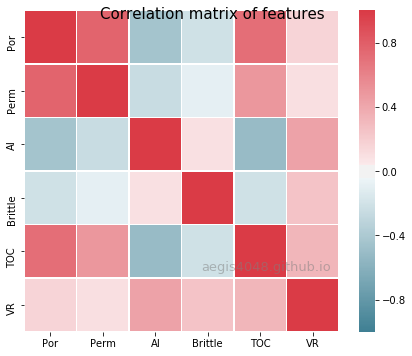

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

df = df.iloc[:, 1:-1]

corr = df.corr(method='spearman')

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=10)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

fig.suptitle('Correlation matrix of features', fontsize=15)
ax.text(0.77, 0.2, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
         transform=ax.transAxes, color='grey', alpha=0.5)

fig.tight_layout()